## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [2]:
# ref: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# calibration images has 9x6 inner corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)


cv2.destroyAllWindows()

#http://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv
for i in range (1,5):
    cv2.waitKey(1)

In [3]:
# Do camera calibration given object points and image points
import pickle

img_1 = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img_1.shape[1], img_1.shape[0]) # dimensions reversed
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/calibration_pickle.p", "wb" ) )

## 2. UnDistort Images

Should now have objpoints and imgpoints needed for camera calibration. Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

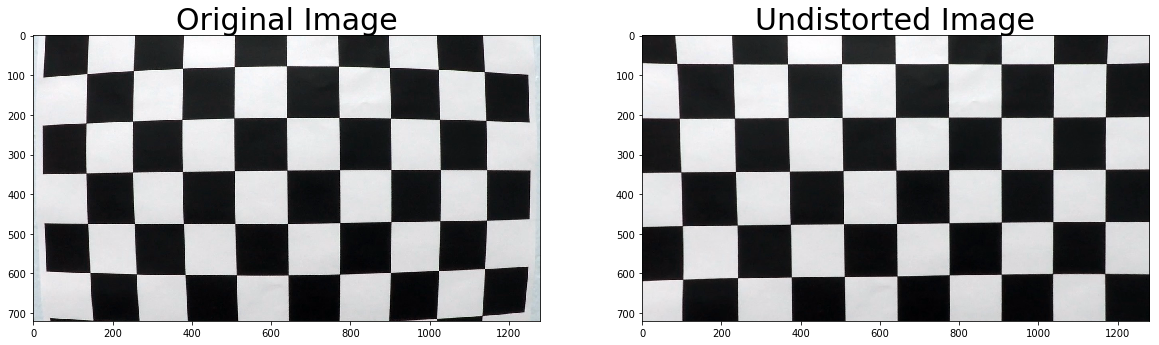

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/test_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
import numpy as np
import cv2

def abs_sobel_thresh(img, orient='x', ksize=3, thresh_min=0, thresh_max=255):
    """Absolute Sobel Gradient Thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        thresh_min (int)
        thresh_max (int)
    """
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
        
    # 3) Take the absolute value of the gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """Magnitude of Sobel in x and y directions and thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        sobel_kernel (int)
        mag_thresh (tuple) : (min, max) 2 element tuple 
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt( sobel_x**2 + sobel_y**2 )
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Direction of Sobel gradient in x and y combined then thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        sobel_kernel (int)
        thresh (tuple) : (min, max) 2 element tuple, default 0 to 90 degrees
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like( gradient )
    
    # 6) Return this mask as your binary_output image
    binary_output[(gradient >= thresh[0]) & (gradient <= thresh[1])] = 1

    return binary_output


In [6]:
def colorAndGradientThresholdBinary(img, 
                                    color_thresh=(170, 255), 
                                    sobel_thresh=(20, 100), 
                                    ksize=3):
    """Use Sobel gradient and Color transforms to create a thresholded binary image

    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        color_thresh (tuple): Color channel threshold. Two element tuple.
        sobel_thresh (tuple): Sobel operator threshold. Two element tuple.
        ksize (int): Sobel operator kernel size.

    Returns:
        (color_binary, sx_binary, s_binary): color_binary, sx_binary, s_binary
    """
    img = np.copy(img)
    
    ### Sobel Gradient in x direction ( x direction accentuates vertical lines )
    #sx_binary = abs_sobel_thresh(img, orient='x', ksize=3, thresh_min=sobel_thresh[0], thresh_max=sobel_thresh[1])
    
    ### Sobel magnitude
    mag_binary = mag_thresh(img, sobel_kernel=5, mag_thresh=sobel_thresh) # (30,100) seems to work well
    
    ### Sobel direction (0.5 to 1.4) is about (30 to 80 degrees)
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0.5, 1.5))
    
    ### Combine magnitude and direction where both thresholds are satisfied
    # (note that magnitude and direction takes both individual Sobel x and y into account)
    sobel_combined_binary = np.zeros_like(dir_binary)
    sobel_combined_binary[((mag_binary == 1) & (dir_binary == 1))] = 1

    ### Color Channel
    # Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    
    s_gradiented_binary = ((s_binary == 1) & (dir_binary == 1)) # s_binary filtered by gradient
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 15) & (h_channel <= 30)] = 1
    
    color_combined_binary = np.zeros_like(s_binary)
    color_combined_binary[ (s_binary == 1) & ( h_binary == 1)] =1

    color_gradiented_binary = ((color_combined_binary == 1) & (dir_binary == 1)) # s_binary filtered by gradient
        
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sobel_combined_binary), sobel_combined_binary, color_gradiented_binary))
    
    # Combine sobel and color results
    combined_binary = np.zeros_like(sobel_combined_binary)
    combined_binary[ (sobel_combined_binary == 1) | (color_gradiented_binary == 1) ] = 1
    
    return combined_binary, color_binary, \
        sobel_combined_binary, mag_binary, dir_binary, \
        s_gradiented_binary, s_binary, h_binary, color_gradiented_binary
    

type(image)=<class 'numpy.ndarray'>, image.shape=(720, 1280, 3)
type(color_binary)=<class 'numpy.ndarray'>, color_binary.shape=(720, 1280, 3)
type(sobel_binary)=<class 'numpy.ndarray'>, sobel_binary.shape=(720, 1280)


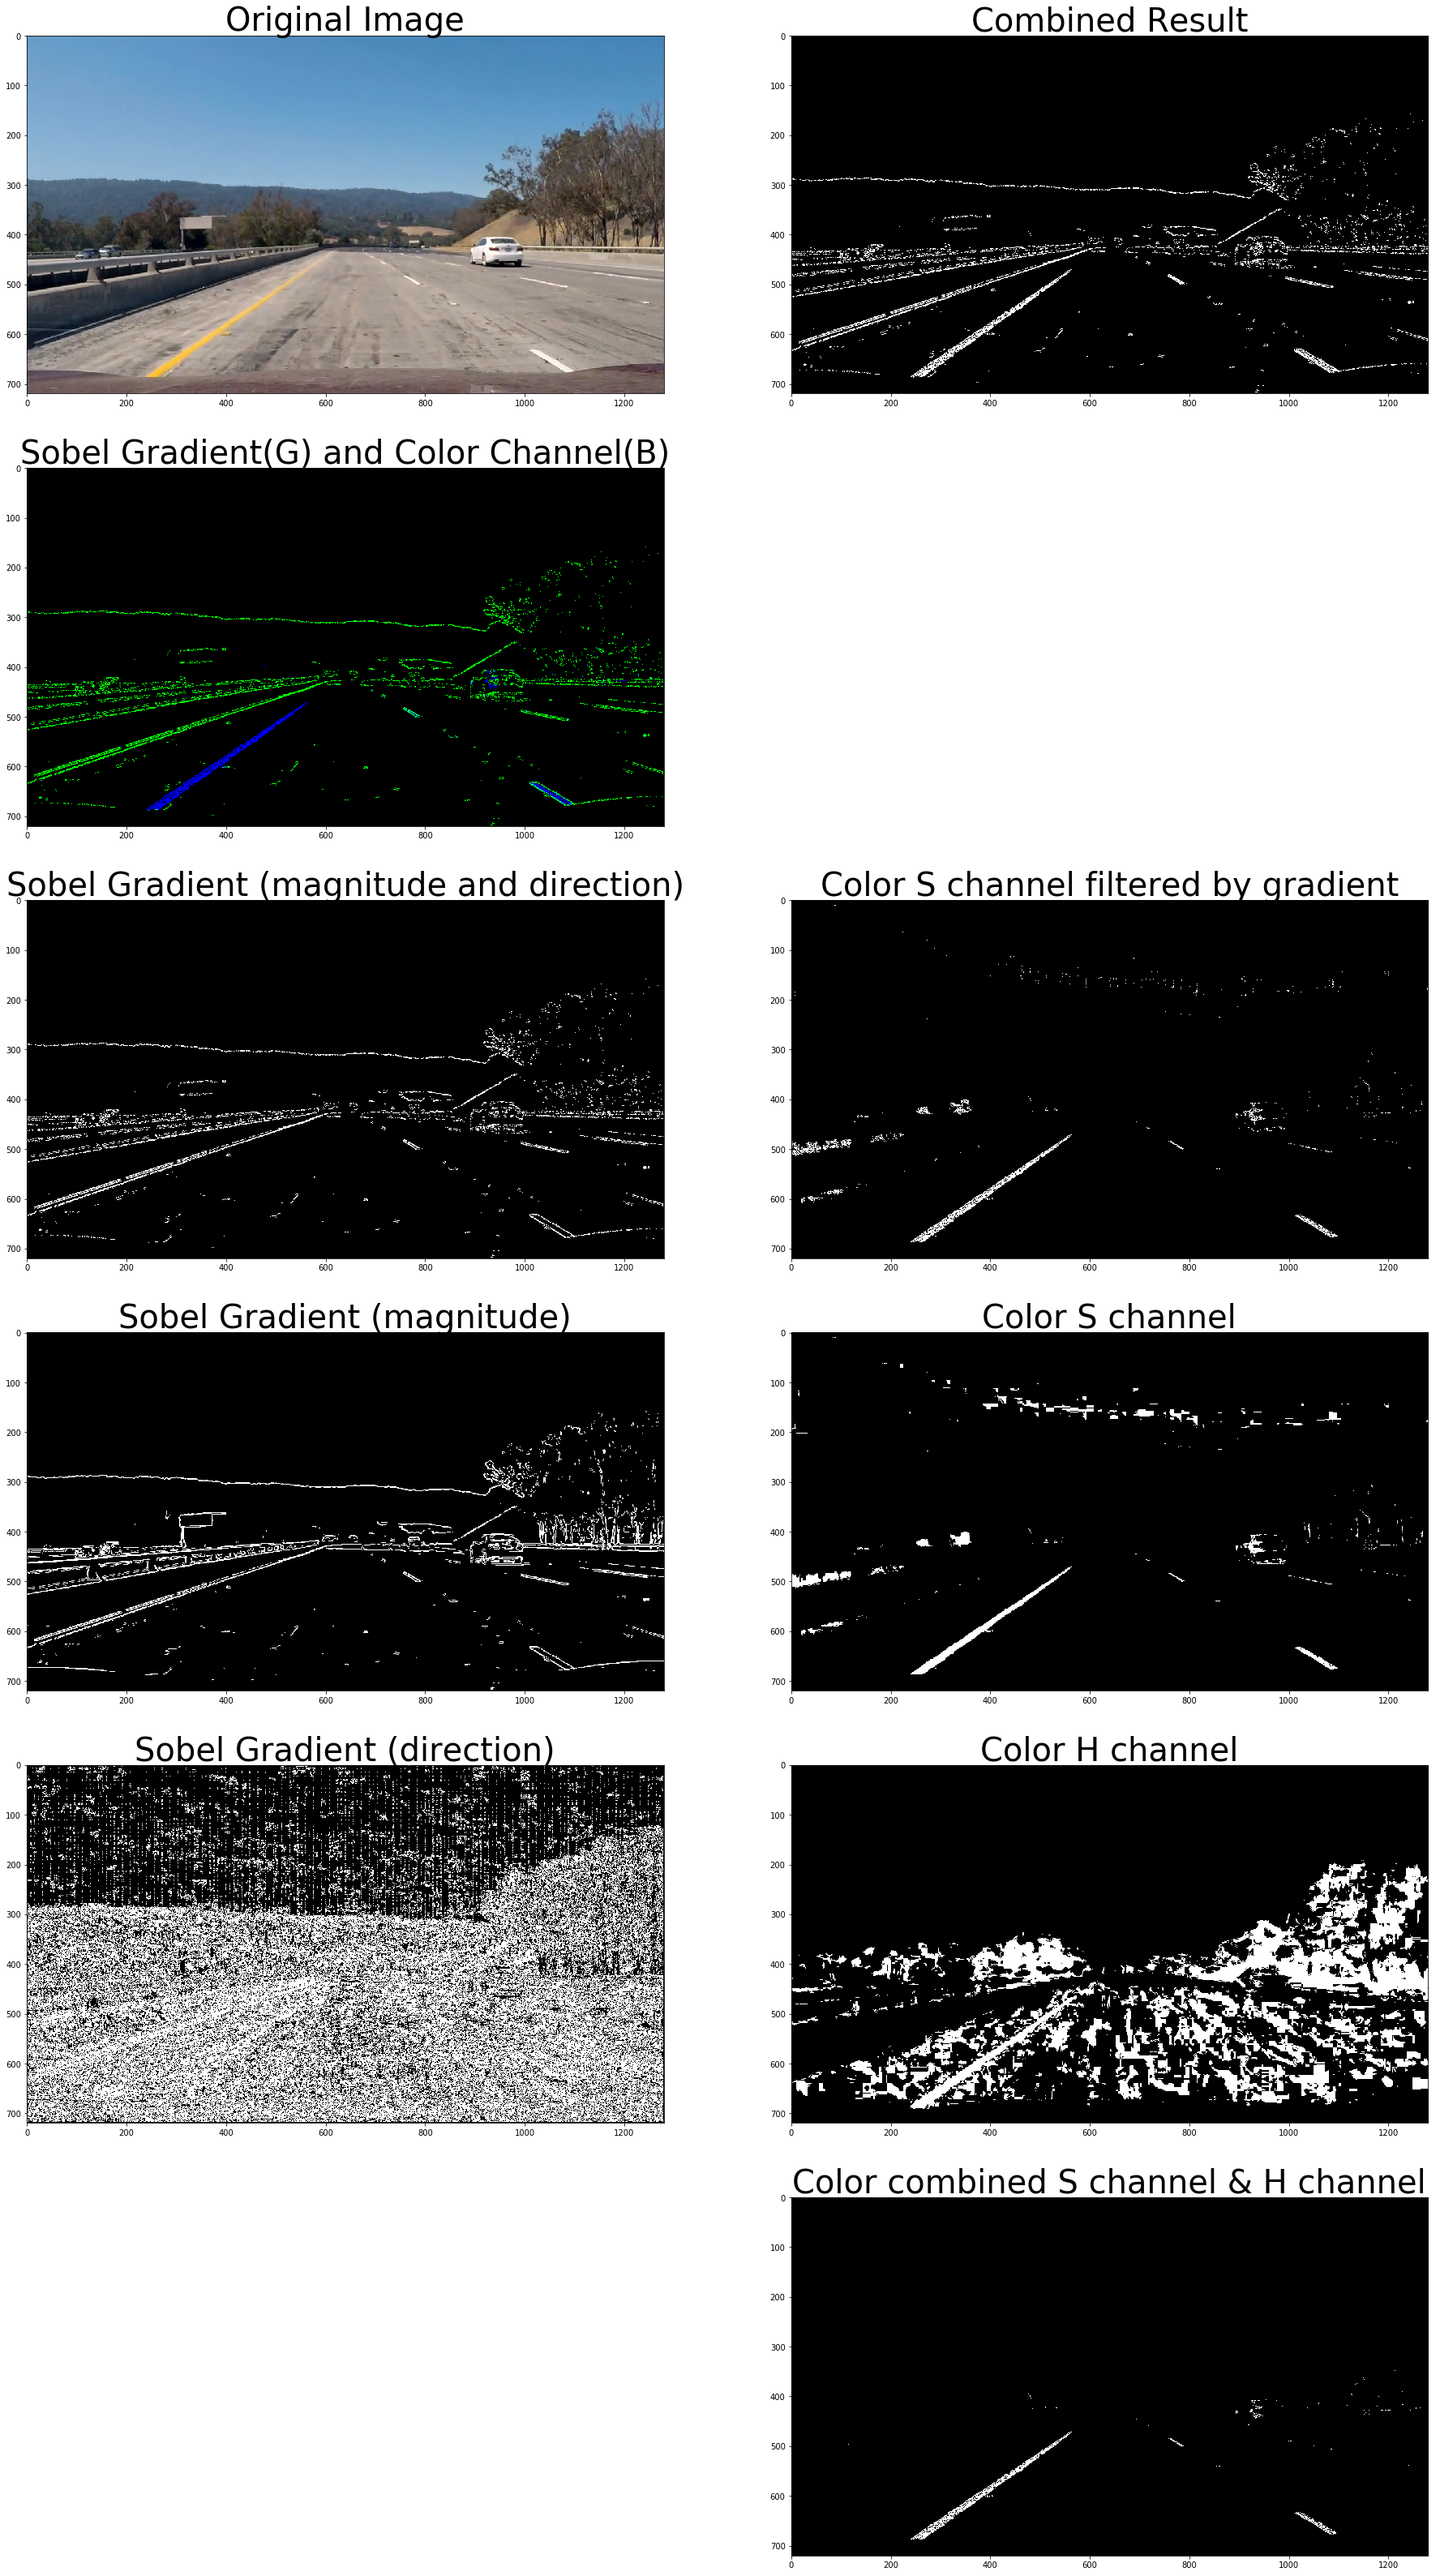

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# NOTE jpg and png format pixel values are different ranges? jpg = 8bit?
# image = mpimg.imread('./signs_vehicles_xygrad.png') 
###image = mpimg.imread('./test_images/test5.jpg')
###image = mpimg.imread('./debug_images/orig/frame532.jpg')
image = mpimg.imread('./debug_images/orig/frame563.jpg')

print("type(image)={}, image.shape={}".format( type(image), image.shape ))

combined_binary, color_binary, sobel_binary, mag_binary, dir_binary, s_gradiented_binary, s_binary, h_binary, color_combined_binary = \
    colorAndGradientThresholdBinary(image, 
                                    color_thresh=(128, 255), 
                                    sobel_thresh=(50, 135), #sobel_thresh=(50, 135),
                                    ksize=5)

print("type(color_binary)={}, color_binary.shape={}".format( type(color_binary), color_binary.shape ))
print("type(sobel_binary)={}, sobel_binary.shape={}".format( type(sobel_binary), sobel_binary.shape ))
#print("color_binary[360][0:10]={}".format( color_binary[360][0:10] ))
# Plot the result
f, axes = plt.subplots(6, 2, squeeze=False, figsize=(24, 48))
# f.tight_layout()

axes[0][0].imshow(image)
axes[0][0].set_title('Original Image', fontsize=40)

axes[0][1].imshow(combined_binary, cmap='gray')
axes[0][1].set_title('Combined Result', fontsize=40)

axes[1][0].imshow(color_binary)
axes[1][0].set_title('Sobel Gradient(G) and Color Channel(B)', fontsize=40)

axes[1][1].axis('off')

axes[2][0].imshow(sobel_binary, cmap='gray')
axes[2][0].set_title('Sobel Gradient (magnitude and direction)', fontsize=40)

axes[3][0].imshow(mag_binary, cmap='gray')
axes[3][0].set_title('Sobel Gradient (magnitude)', fontsize=40)

axes[4][0].imshow(dir_binary, cmap='gray')
axes[4][0].set_title('Sobel Gradient (direction)', fontsize=40)

axes[2][1].imshow(s_gradiented_binary, cmap='gray')
axes[2][1].set_title('Color S channel filtered by gradient', fontsize=40)

axes[3][1].imshow(s_binary, cmap='gray')
axes[3][1].set_title('Color S channel', fontsize=40)

axes[4][1].imshow(h_binary, cmap='gray')
axes[4][1].set_title('Color H channel', fontsize=40)

axes[5][0].axis('off')

axes[5][1].imshow(color_combined_binary, cmap='gray')
axes[5][1].set_title('Color combined S channel & H channel', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Gradient Usage
'And'ing gradient direction to magnitude helps to filter out horizontal lines (like the hood).

### Color Channel Usage
The H channel results in a noisy binary.  
S channel picks up lane lines well but also other features as well,
for example, it picks up the concrete barrier under the tree in image "test_images/test5.jpg".  

The S channel binary can be cleaned up by filtering ('and'ing) with the sobel gradient direction.

Combining S and H channel binaries by 'AND'ing removes noise such as the cars in image "test_images/test5.jpg".
Combining the combine S and H channel result by 'AND'ing with the Sobel gradient direciton further reduces noise.


## Image UnDistort

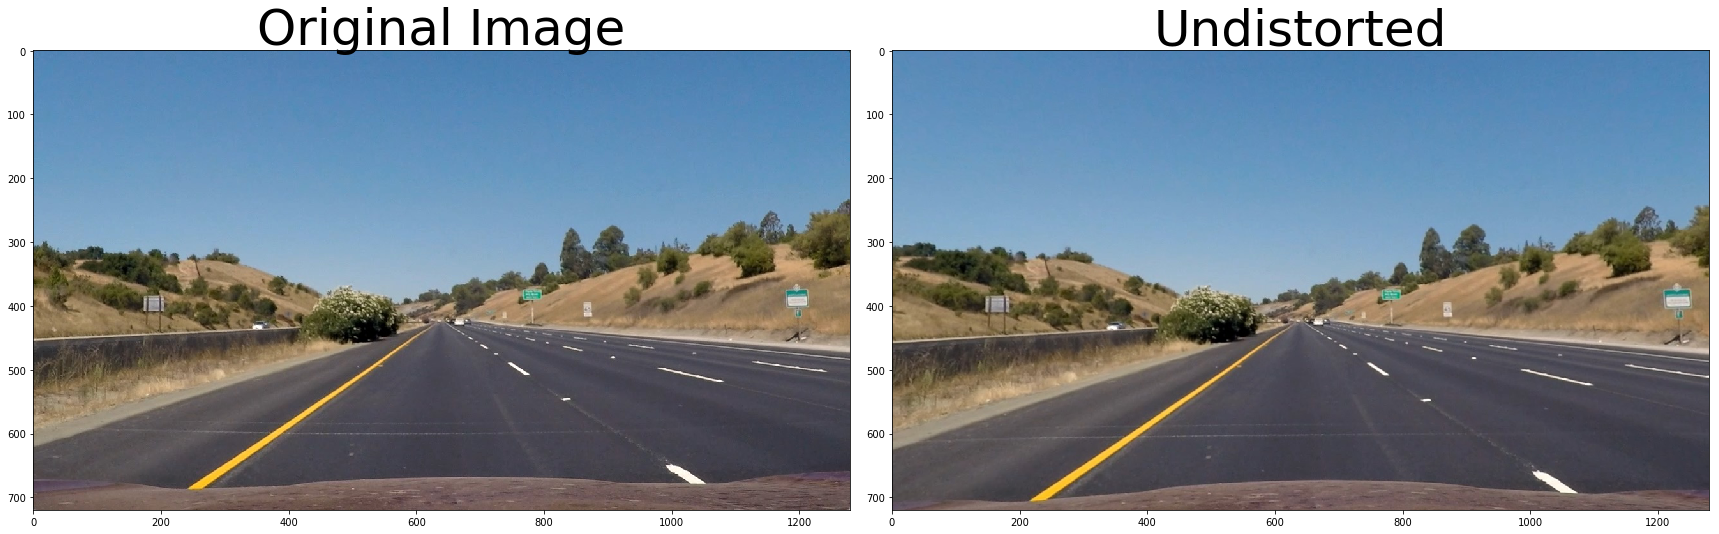

In [8]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
CALIBRATION = {'mtx': mtx, 'dist': dist}

# Read in an image
img_orig = mpimg.imread('test_images/straight_lines1.jpg')

# 1) Undistort using mtx and dist
img = cv2.undistort(img_orig, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_orig)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img)
ax2.set_title('Undistorted', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

In [9]:
import cv2
import numpy as np

def image_warp(img, mtx, dist, M):
    """Warp image using perspective transform
    
    First, undistort image using camera calibration
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        mtx: camera matrix, 
        dist: distortion coefficients
        M: the transform matrix
        
    Returns:
        (warped): warped image
    """
        
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist, None, mtx)

    img_size = (img.shape[1], img.shape[0]) # note switch of x,y order

    # 3) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

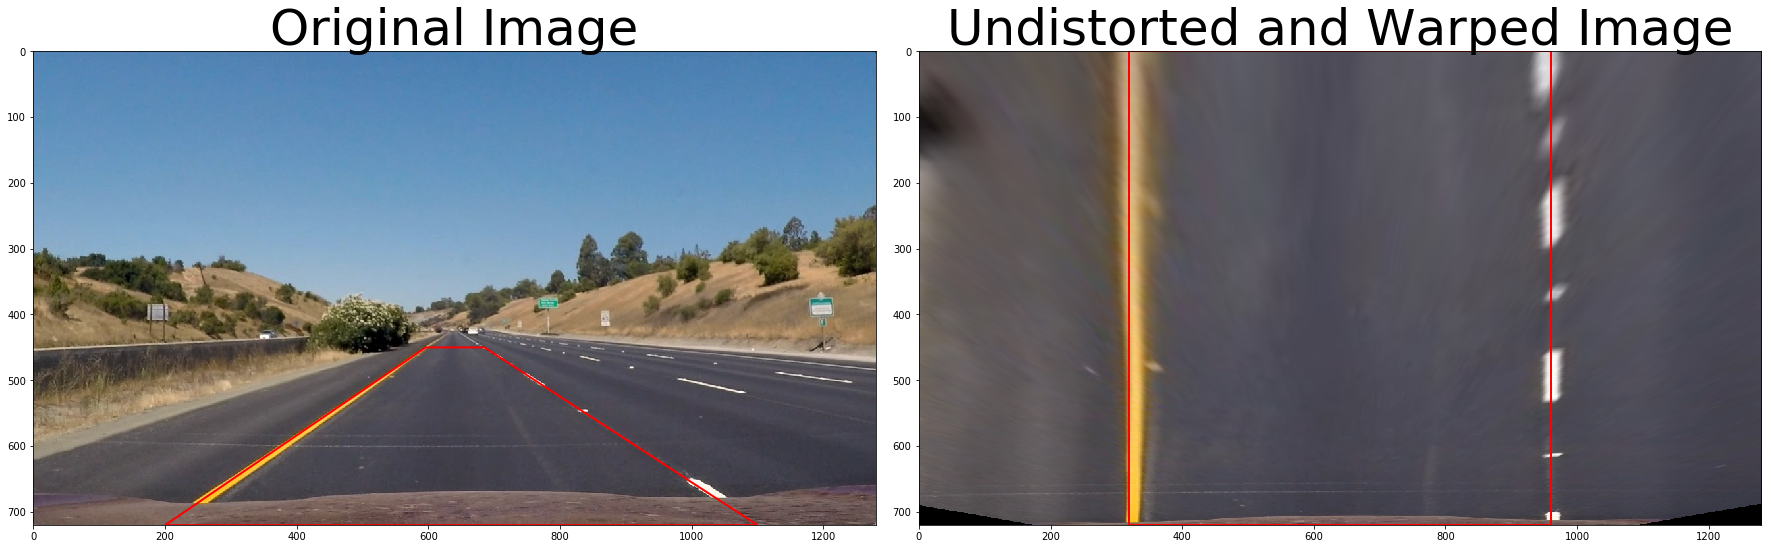

In [10]:
# Calculate the perspective transform matrix M and inverse Minv
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.path import Path
import matplotlib.patches as patches

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Define 4 source points 
# top left [622,435]
# top right [662,435]
# bottom right [1040,675]
# bottom left [272,675]
src_points = [[596,450],[685,450],[1100,720],[200,720]]
src = np.float32(src_points)

# Define 4 destination points
dst_points = [
    [320, 0], 
    [960, 0], 
    [960, 720], 
    [320, 720]]
dst = np.float32(dst_points)

# Use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Inverse transform matrix for transforming warped back to perspective view
Minv = cv2.getPerspectiveTransform(dst, src)

# Save the perspective transform result for later use 
pXform_pickle = {}
pXform_pickle["M"] = M
pXform_pickle["Minv"] = Minv
pickle.dump( pXform_pickle, open( "./camera_cal/perspective_transform_pickle.p", "wb" ) )


# warp image
img_warped = image_warp(img, mtx, dist, M)

# display result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)

# draw the src points boundary
verts = np.float32( src_points + [src_points[0]] )
codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts, codes)
patch = patches.PathPatch(path, edgecolor='red', facecolor='none', lw=2)
ax1.add_patch(patch)

ax1.set_title('Original Image', fontsize=50)

ax2.imshow( img_warped )

# draw the dst points boundary
verts = np.float32( dst_points + [dst_points[0]] )

path = Path(verts, codes)
patch = patches.PathPatch(path, edgecolor='red', facecolor='none', lw=2)
ax2.add_patch(patch)

ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


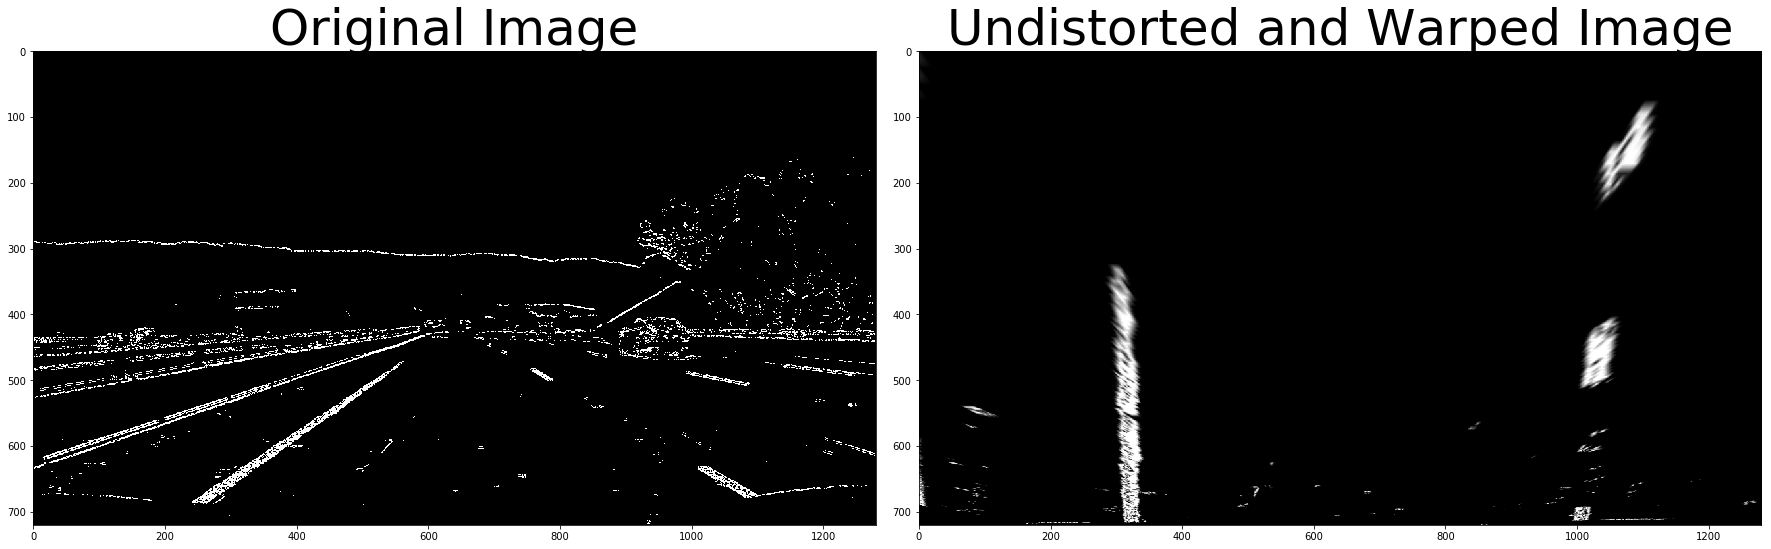

In [11]:
# Check curved lines from Gradient and Color threshold binary

# warp image
combined_binary_warped = image_warp(combined_binary, mtx, dist, M)

# display result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow( combined_binary, cmap='gray' )
ax1.set_title('Original Image', fontsize=50)

ax2.imshow( combined_binary_warped, cmap='gray' )
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

histogram.shape=(1280,)
midpoint=640, leftx_base=311, rightx_base=1024


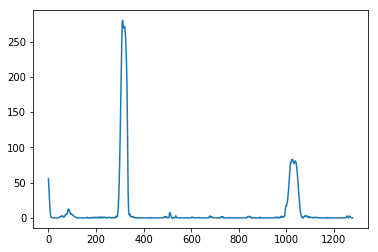

In [12]:
# histogram along all the columns in the lower half of the image
import numpy as np
img = combined_binary_warped
histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
print("histogram.shape={}".format(histogram.shape))
plt.plot(histogram)

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("midpoint={}, leftx_base={}, rightx_base={}".format(midpoint, leftx_base, rightx_base))

combined_binary_warped.shape=(720, 1280), out_img.shape=(720, 1280, 3)
combined_binary_warped[0][400:500]=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
out_img[0][400:500]=[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


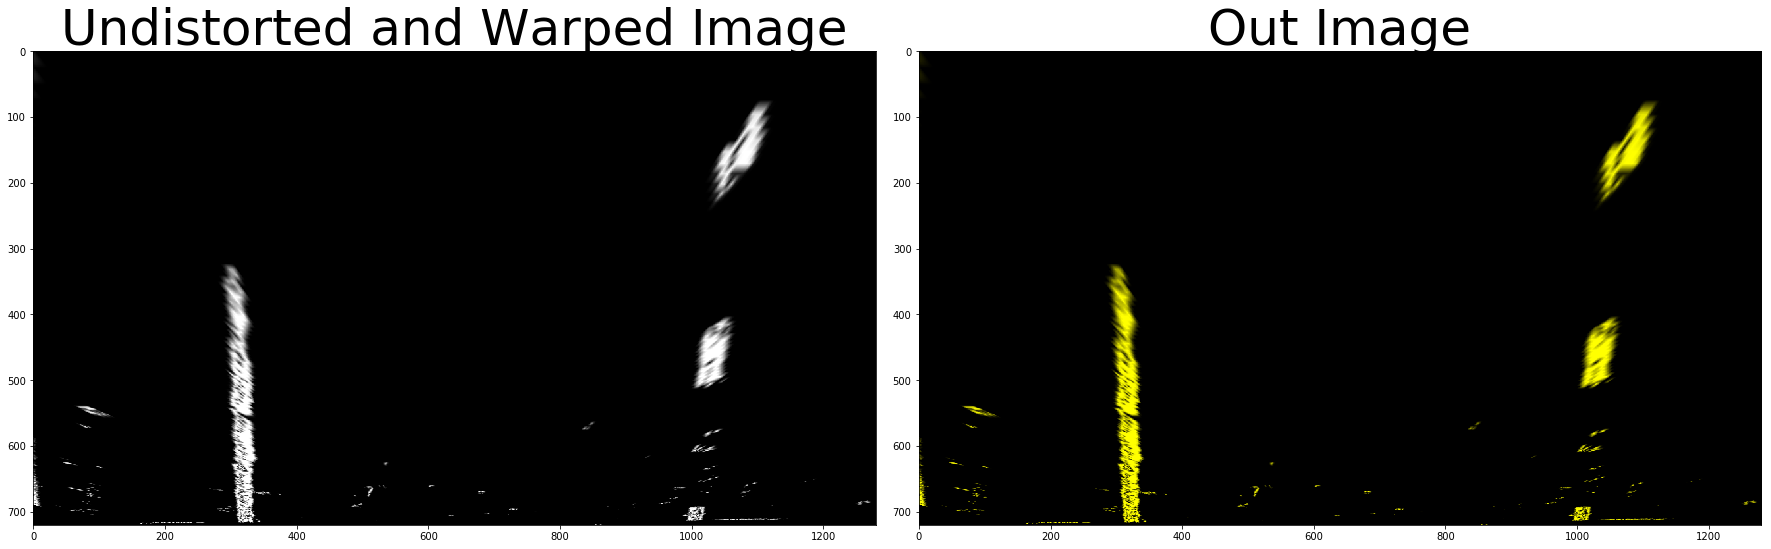

In [13]:
# Trying out how numpy dstack is used to create color images from binary image
binary_warped = combined_binary_warped
zeros = np.zeros_like(binary_warped)
out_img = np.dstack((binary_warped, binary_warped, np.zeros_like(binary_warped)))*255
out_img = out_img.astype(np.uint8) # convert to 8 bit binary for pyplot to interpret color correctly as 0-255

print("combined_binary_warped.shape={}, out_img.shape={}".format(combined_binary_warped.shape, out_img.shape))
print("combined_binary_warped[0][400:500]={}".format(combined_binary_warped[0][400:425]))
print("out_img[0][400:500]={}".format(out_img[0][400:405]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow( combined_binary_warped, cmap='gray' )
ax1.set_title('Undistorted and Warped Image', fontsize=50)

ax2.imshow( out_img )
ax2.set_title('Out Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
import numpy as np
# nonzeros study
a = np.array([[1,0,0,0],[1,1,0,0],[1,1,1,0],[1,1,1,1]])
print("a=\n {}".format(a))
nz = np.nonzero(a)
print ("nz={}".format( nz ))
print ("nz[0]={}".format(nz[0]))
print ("nz[1]={}".format(nz[1]))

nzy = np.array(nz[0])
nzx = np.array(nz[1])
print("nzy={}, nzx={}".format(nzy, nzx))
print ( ((nzy >1) & (nzy <=2)).nonzero()[0] )


win_y_low = 2
win_y_high = 4

win_xleft_low = 0
win_xleft_high = 2

win_xright_low = 2
win_xright_high = 4
good_left_inds = ((nzy >= win_y_low) & (nzy < win_y_high) & (nzx >= win_xleft_low) & (nzx < win_xleft_high)).nonzero()[0]
good_right_inds = ((nzy >= win_y_low) & (nzy < win_y_high) & (nzx >= win_xright_low) & (nzx < win_xright_high)).nonzero()[0]
    
print("good_left_inds={}, good_right_inds{}".format(good_left_inds,good_right_inds))
print( ((nzy >= win_y_low) & (nzy < win_y_high) ).nonzero()[0] )
print( ((nzx >= win_xleft_low) & (nzx < win_xleft_high)).nonzero()[0] )
print( ((nzx >= win_xright_low) & (nzx < win_xright_high)).nonzero()[0] )

print ( "nzx[good_right_inds]={}".format( nzx[good_right_inds] ))
np.int(np.mean(nzx[good_right_inds]))

a=
 [[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]
nz=(array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3]), array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3]))
nz[0]=[0 1 1 2 2 2 3 3 3 3]
nz[1]=[0 0 1 0 1 2 0 1 2 3]
nzy=[0 1 1 2 2 2 3 3 3 3], nzx=[0 0 1 0 1 2 0 1 2 3]
[3 4 5]
good_left_inds=[3 4 6 7], good_right_inds[5 8 9]
[3 4 5 6 7 8 9]
[0 1 2 3 4 6 7]
[5 8 9]
nzx[good_right_inds]=[2 2 3]


2

In [15]:
# Curvature of lane lines
import numpy as np
def lane_curvature( leftx, lefty, rightx, righty, y_eval ):
    """
    Find Lane Curvature
    
    Args:
        leftx (ndarray): left line x pixel positions
        lefty (ndarray): left line y pixel positions
        rightx
        righty
        y_eval (int): y pixel position to evaluate curvature (usually at bottom of image (binary_warped.shape[0] - 1), closest to vehicle)
        
    Returns:
        (left_radius, right_radius)
    """

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in real world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate radius weighted by number of non-zero points on left and right lanes
    left_nonzeros = leftx.shape[0]
    right_nonzeros = rightx.shape[0]
    print("leftx.shape[0]={}, rightx.shape[0]={}".format(left_nonzeros, right_nonzeros))
    weighted_curverad = ((left_curverad * left_nonzeros) + (right_curverad * right_nonzeros))/(left_nonzeros + right_nonzeros)
    
    # # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm', weighted_curverad, 'm')
    # # Example values: 632.1 m    626.2 m
    
    return (left_curverad, right_curverad, weighted_curverad)

In [16]:
# find off center distance and left and right line separation (lane width)
def lane_offset( left_fit, right_fit, warped_shape, xm_per_pix ):
    """
    Find Off Center Distance and Lane Width
    
    Args:
        left_fit, 
        right_fit,
        warped_shape (y_dim, x_dim): shape of warped image used for lane fit
        y_eval (int): y pixel position to evaluate curvature (usually at bottom of image (binary_warped.shape[0] - 1), closest to vehicle)
        xm_per_pix (int): meters per x pixel
        
    Returns:
        (off_center, lane_width)
    """

    y_dim, x_dim = warped_shape
    
    # # Calculate left and right x at bottom of image
    # # Approach 1. adjust pixel value result be xm_per_pix
    y_eval = y_dim - 1
    print("y_eval={}".format(y_eval))
        
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_width = (right_x - left_x) * xm_per_pix

    print("left_x={}, right_x={}".format(left_x, right_x))
    print("lane width={}".format(lane_width) )

    assert 2 < lane_width < 5.5, "lane width should be reasonable: %r" % lane_width
    
    # off center distance
    lane_center = (right_x + left_x)/2
    print("lane_center pixels={}".format(lane_center))
    
    off_center = (lane_center - (x_dim/2) ) * xm_per_pix
    
    half_image_width = ((x_dim/2) * xm_per_pix)
    assert 0.0 < abs(off_center) < half_image_width

    return off_center, lane_width

## Implement Sliding Windows and Fit a Polynomial

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def slidingWindowsPolyFit( binary_warped ):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    # http://stackoverflow.com/questions/24739769/matplotlib-imshow-plots-different-if-using-colormap-or-rgb-array
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            #print("window={}, leftx_current={}".format(window, leftx_current))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            #print("window={}, rightx_current={}".format(window, rightx_current))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # for output image, color left lane points as red, right lane points as blue
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # note that the y,x params ordering int numpy.polyfit
    # "fitting for f(y), rather than f(x), 
    # because the lane lines in the warped image are near vertical and 
    # may have the same x value for more than one y value
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ###print("lefty.shape={}, left_fit={}".format(lefty.shape, left_fit))
    ###print("righty.shape={}, right_fit={}".format(righty.shape, right_fit))
    
    left_radius, right_radius, weighted_radius = lane_curvature( leftx, lefty, rightx, righty, binary_warped.shape[0] - 1 )
    
    return left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius


leftx.shape[0]=14515, rightx.shape[0]=15008
924.437103495 m 576.815563106 m 747.723894195 m
left_fit=[ -1.77653104e-04   2.30889787e-01   2.44523908e+02]
right_fit=[  2.84750325e-04  -3.35498981e-01   1.12133748e+03]
lane radius=747.723894195071
out_img.shape=(720, 1280, 3)


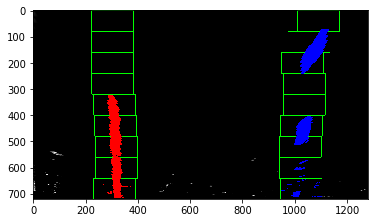

In [18]:
# test slidingWindowsPolyFit
left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius = slidingWindowsPolyFit( combined_binary_warped )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))
print("lane radius={}".format(weighted_radius))
print("out_img.shape={}".format(out_img.shape))
plt.imshow(out_img)

### Visualization

binary_warped.shape=(720, 1280)


(720, 0)

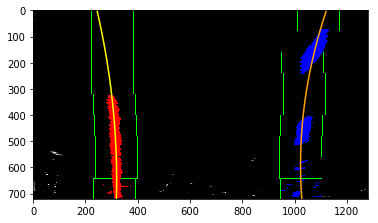

In [19]:
# Generate x and y values for plotting
print("binary_warped.shape={}".format(binary_warped.shape))
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

# left and right lines from polyfit over y range
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='orange')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Look-Ahead Filter
Skip the sliding windows step once you know where the lines are

In [20]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
# (use the same image just to try out)

def lookAheadFilter( left_fit, right_fit, binary_warped, lane_image=False ):
    """Look Ahead Filter
    
    Args:
        left_fit (array): 2nd order polynomial fit of left lane line from previous frame
        right_fit (array): 
        binary_warped (numpy.ndarray): thresholded binary
        lane_image (boolean): create lane image
        
    Return:
        left_fit: 2nd order polynomial fit of left lane line for current frame
        right_fit: 
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    # Get non-zeros within margin to either side of previous frame left, right lines
    left_line = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] 
    left_lane_inds = ((nonzerox > (left_line - margin)) & (nonzerox < (left_line + margin))) 

    right_line = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    right_lane_inds = ((nonzerox > (right_line - margin)) & (nonzerox < (right_line + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if lane_image:
        # Create an image to draw on and an image to show the selection window
        out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img[ ploty.astype(np.uint16), left_fitx.astype(np.uint16) ] = [255,255,0]
        out_img[ ploty.astype(np.uint16), right_fitx.astype(np.uint16) ] = [255,255,0]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    else:
        out_img = None
    
    left_radius, right_radius, weighted_radius = lane_curvature( leftx, lefty, rightx, righty, binary_warped.shape[0] - 1 )
    
    return left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius


leftx.shape[0]=14534, rightx.shape[0]=15066
838.754488345 m 543.977185354 m 688.7168246 m
left_fit=[ -1.95803530e-04   2.48391136e-01   2.40460758e+02]
right_fit=[  3.01955965e-04  -3.46602146e-01   1.12260578e+03]
lane radius=688.7168245999046
out_img.shape=(720, 1280, 3)


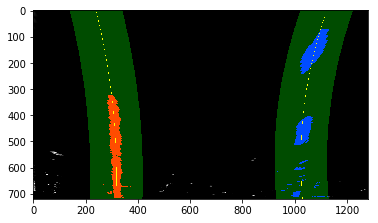

In [21]:
left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius = lookAheadFilter( left_fit, right_fit, binary_warped, lane_image=True )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))
print("lane radius={}".format(weighted_radius))
print("out_img.shape={}".format(out_img.shape))
plt.imshow(out_img)

### Visualize

ploty.shape=(720,), ploty[0:8]=[0 1 2 3 4 5 6 7]
left_fitx.shape=(720,), left_fitx[0:8]=[240 240 240 241 241 241 241 242]


(720, 0)

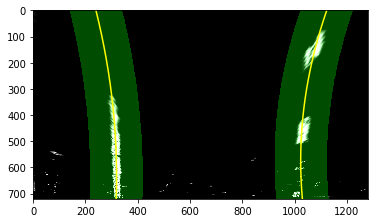

In [22]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print("ploty.shape={}, ploty[0:8]={}".format(ploty.shape, ploty.astype(np.uint16)[0:8]))
print("left_fitx.shape={}, left_fitx[0:8]={}".format(left_fitx.shape, left_fitx.astype(np.uint16)[0:8]))

# Create an image to draw on and an image to show the selection window
out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Project lines on original image

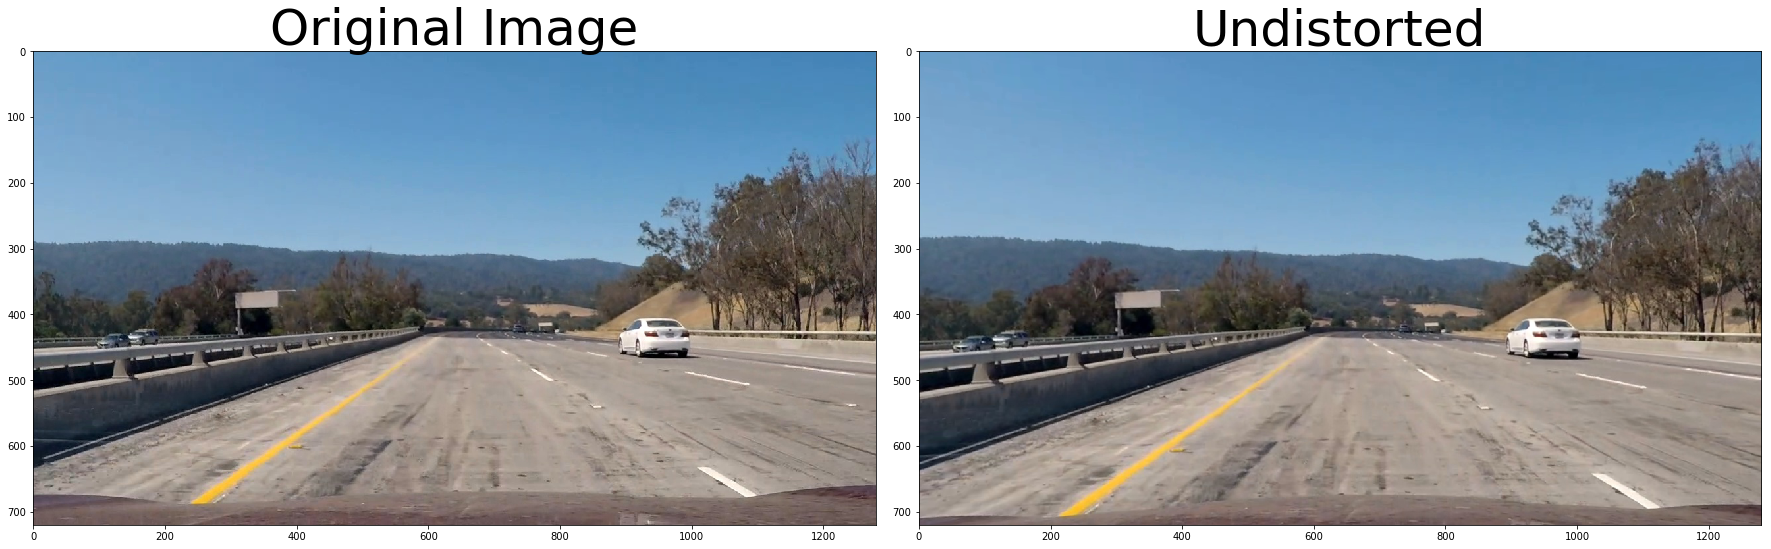

In [23]:
# see what cv2.undistort image looks like (this was done previously with straight lane lines)
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


color_warp.shape=(720, 1280, 3)
y_eval=719
left_x=317.83119606058585, right_x=1029.498294653529
lane width=3.7616689497055567
lane_center pixels=673.6647453570574
off_center=0.17794222545873212, lane_width=3.7616689497055567


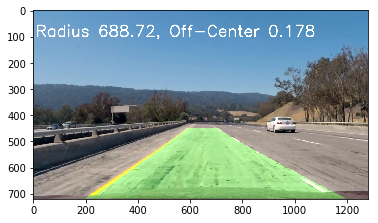

In [24]:
# # Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

warped = binary_warped

# Project lines on original image

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
print("color_warp.shape={}".format(color_warp.shape))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
lane_image = cv2.addWeighted(image_undistorted, 1, newwarp, 0.3, 0)

off_center, lane_width = lane_offset( left_fit, right_fit, warped.shape, xm_per_pix )
print("off_center={}, lane_width={}".format(off_center, lane_width))

font = cv2.FONT_HERSHEY_SIMPLEX
a_str = "Radius {0:.2f}, Off-Center {1:.3f}".format(weighted_radius, off_center)
cv2.putText(lane_image,a_str,(10,100), font, 2,(255,255,255),3,cv2.LINE_AA)
    
plt.imshow(lane_image)

In [25]:
#TODO: leftx,lefty,rightx, righty has to be exposed from lookAheadFilter
# # Curvature of lane lines

# # Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# # evaluate curvature at bottom of image, closest to vehicle
y_eval = binary_warped.shape[0] - 1 

# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')
# # Example values: 632.1 m    626.2 m

In [26]:
# #TODO: need left_fit_cr, from previous block
# # left and right line separation (lane width)
# left_fit_cr.shape

# # Calculate left and right x at bottom of image
# # Approach 1. adjust pixel value result be xm_per_pix
left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
lane_width_1 = (right_x - left_x) * xm_per_pix

print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))
print("y_eval={}".format(y_eval))
print("left_x={}, right_x={}".format(left_x, right_x))
print("lane width={}".format(lane_width_1) )

assert 2 < lane_width_1 < 5.5, "lane width should be reasonable: %r" % lane_width_1

# # Approach 2. calculate from meters polyfit (both should have same result)
# y_eval_adj = y_eval * ym_per_pix
# left_x = left_fit_cr[0]*y_eval_adj**2 + left_fit_cr[1]*y_eval_adj + left_fit_cr[2]
# right_x = right_fit_cr[0]*y_eval_adj**2 + right_fit_cr[1]*y_eval_adj + right_fit_cr[2]
# lane_width_2 = (right_x - left_x)

# print("left_fit_cr={}".format(left_fit_cr))
# print("right_fit_cr={}".format(right_fit_cr))
# print("y_eval={}".format(y_eval))
# print("left_x={}, right_x={}".format(left_x, right_x))
# print( lane_width_2 )

# assert abs(lane_width_1 - lane_width_2) < 0.0001, "both values should be close: %r, %r" % (lane_width_1, lane_width_2)

left_fit=[ -1.95803530e-04   2.48391136e-01   2.40460758e+02]
right_fit=[  3.01955965e-04  -3.46602146e-01   1.12260578e+03]
y_eval=719
left_x=317.83119606058585, right_x=1029.498294653529
lane width=3.7616689497055567


## Measuring Curvature


In [27]:
# import numpy as np
# import matplotlib.pyplot as plt
# # Generate some fake data to represent lane-line pixels
# ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pix
# # of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                               for y in ploty])
# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                 for y in ploty])

# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# # Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# # Plot up the fake data
# mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
# plt.plot(left_fitx, ploty, color='green', linewidth=3)
# plt.plot(right_fitx, ploty, color='green', linewidth=3)
# plt.gca().invert_yaxis() # to visualize as we do the images

In [28]:
# # Define y-value where we want radius of curvature
# # I'll choose the maximum y-value, corresponding to the bottom of the image
# y_eval = np.max(ploty)
# left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
# right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)
# # Example values: 1926.74 1908.48

### calculation of radius of curvature after correct for scale in x and y

In [29]:
# # Define conversions in x and y from pixels space to meters
# ym_per_pix = 30/720 # meters per pixel in y dimension
# xm_per_pix = 3.7/700 # meters per pixel in x dimension

# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')
# # Example values: 632.1 m    626.2 m

## Tracking

In [30]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Sanity Check
Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

Checking that they have similar curvature
Checking that they are separated by approximately the right distance horizontally
Checking that they are roughly parallel

## Reset
If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

## Smoothing
Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

In [31]:
## Collect transforms into pipeline function

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
def find_lane( image, mtx, dist, M, plot=False, left_fit=None, right_fit=None ):
    """
    Find Lane
    
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    
    If lane line polynomial fit is available from previous frame, for current frame poly fit
      Use look ahead filter method
    else:
      Use sliding window method
    
    Args:
        image (numpy.ndarray): Source image. Color channels in RGB order.
        mtx: camera matrix, 
        dist: distortion coefficients
        M: the transform matrix
        left_fit: polyfit from previous frame
        right_fit:
        
    Returns:
        (left_fit, right_fit, warped): warped image
    """
        
    ###print("type(image)={}, image.shape={}".format( type(image), image.shape ))

    # 1. color and gradient binary
    threshold_binaries = \
        colorAndGradientThresholdBinary(image, 
                                        color_thresh=(128, 255), 
                                        sobel_thresh=(50, 135), 
                                        ksize=5)
    combined_binary = threshold_binaries[0]
    
    if plot:
        # Plot the color and gradient result
        f, axes = plt.subplots(1, 2, squeeze=False, figsize=(24, 9))
        f.suptitle('Gradient and Color Threshold', fontsize=32)
        f.tight_layout()
        axes[0][0].imshow(image)
        axes[0][0].set_title('Original Image - undistorted', fontsize=40)
        axes[0][1].imshow(combined_binary, cmap='gray')
        axes[0][1].set_title('Combined Binary', fontsize=40)
    
    # 2. undistort and warp image
    binary_warped = image_warp(combined_binary, mtx, dist, M)

    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.suptitle('Undistort', fontsize=32)
        f.tight_layout()
        ax1.imshow(combined_binary, cmap='gray')
        ax1.set_title('Combined Binary', fontsize=40)
        ax2.imshow(binary_warped, cmap='gray')
        ax2.set_title('Undistorted and Warped', fontsize=40)
    
    # 3. Sliding windows fit on first image
    if left_fit is None:
        left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius = slidingWindowsPolyFit( binary_warped )
        fit_title = 'Sliding window fit'
        ###print("Sliding window fit left_fit={}, right_fit={}".format(left_fit, right_fit))
    else:
        left_fit, right_fit, out_img, left_radius, right_radius, weighted_radius = lookAheadFilter( left_fit, right_fit, binary_warped, lane_image=plot )
        fit_title = 'Look ahead filter fit'
        ###print("Look ahead filter fit left_fit={}, right_fit={}".format(left_fit, right_fit))
    
    if plot:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        # left and right lines from polyfit over y range
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # color left lane points as red, right lane points as blue
        #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        f, (ax1) = plt.subplots(1,1, figsize=(6,4))
        f.tight_layout()
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='orange')
        ax1.set_title(fit_title, fontsize=40)
        
    return left_fit, right_fit, binary_warped, weighted_radius
    

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# NOTE jpg and png format pixel values are different ranges? jpg = 8bit?
#image = mpimg.imread('./test_images/straight_lines1.jpg')
#image = mpimg.imread('./debug_images/orig/frame532.jpg')
image = mpimg.imread('./debug_images/orig/frame563.jpg')


leftx.shape[0]=14515, rightx.shape[0]=15008
924.437103495 m 576.815563106 m 747.723894195 m
left_fit=[ -1.77653104e-04   2.30889787e-01   2.44523908e+02]
right_fit=[  2.84750325e-04  -3.35498981e-01   1.12133748e+03]


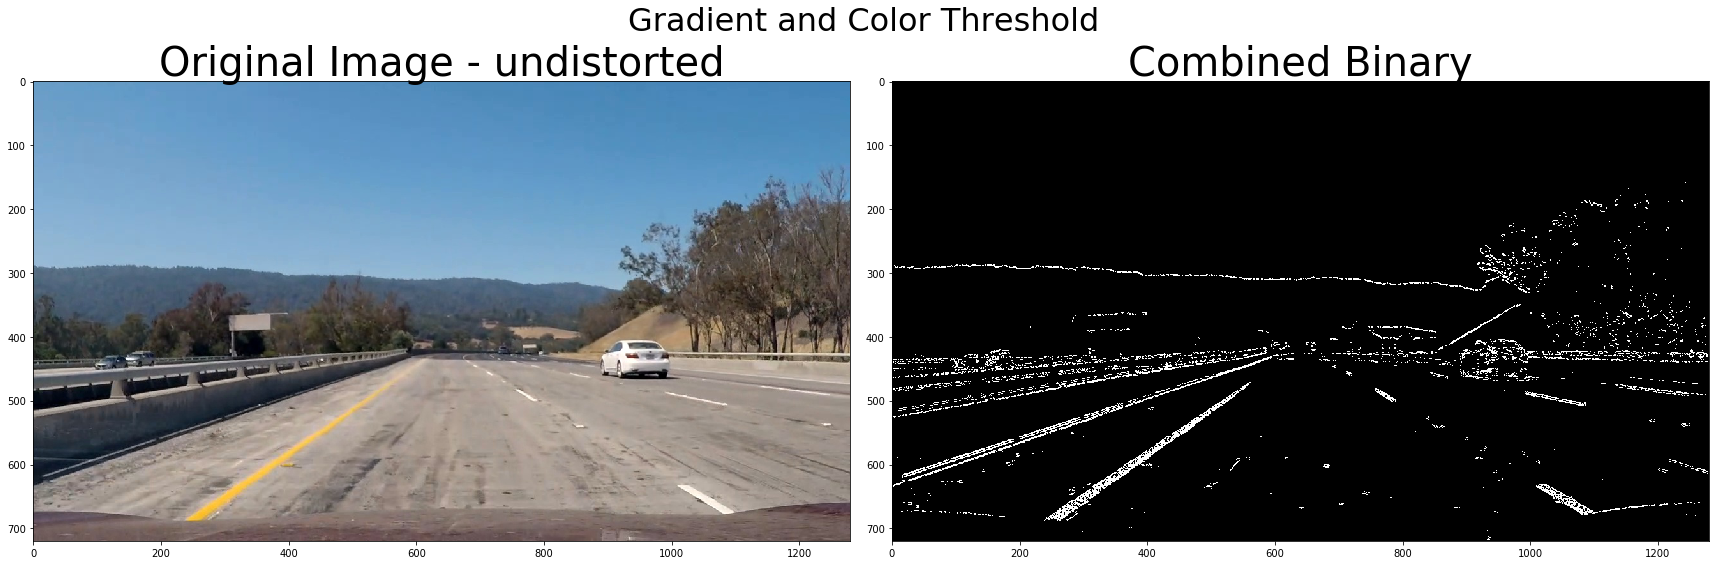

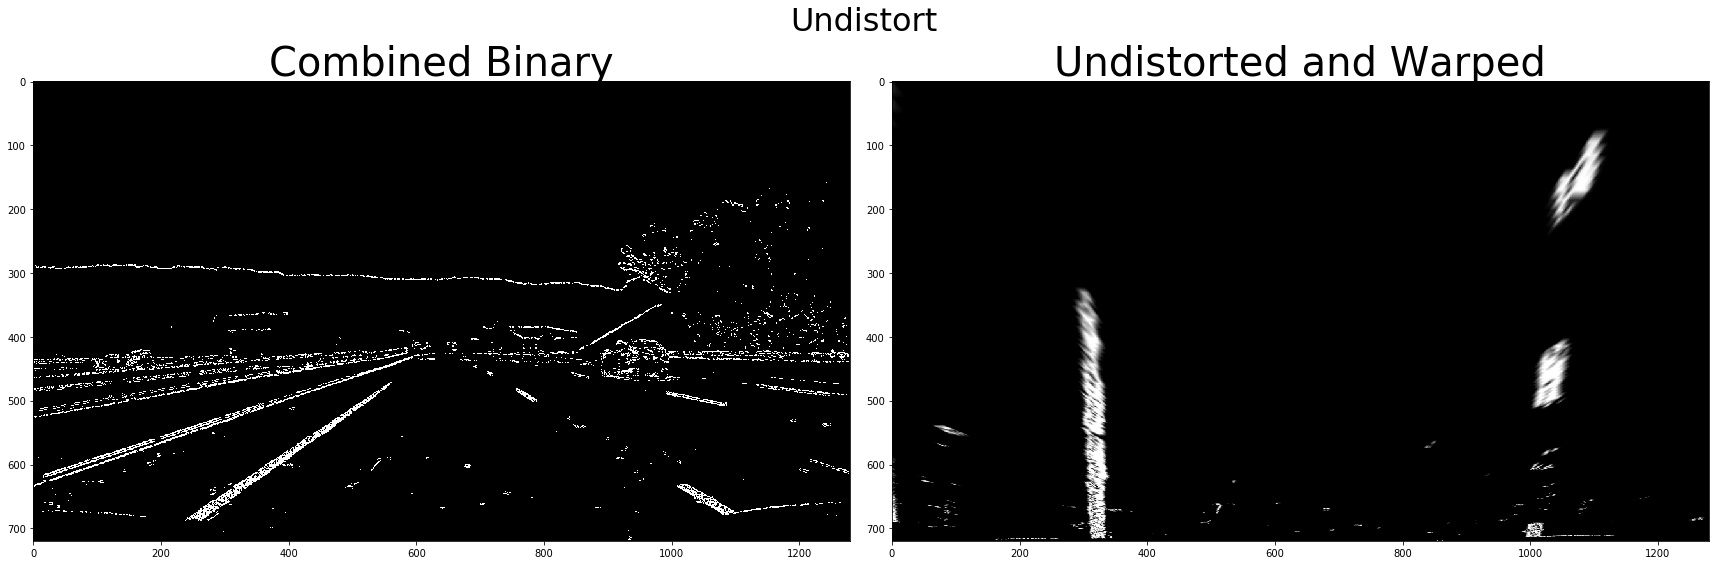

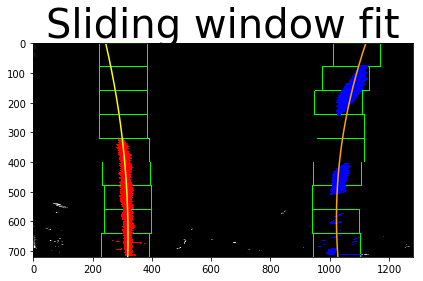

In [33]:
left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M, plot=True )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))

leftx.shape[0]=14534, rightx.shape[0]=15066
838.754488345 m 543.977185354 m 688.7168246 m
left_fit=[ -1.95803530e-04   2.48391136e-01   2.40460758e+02]
right_fit=[  3.01955965e-04  -3.46602146e-01   1.12260578e+03]


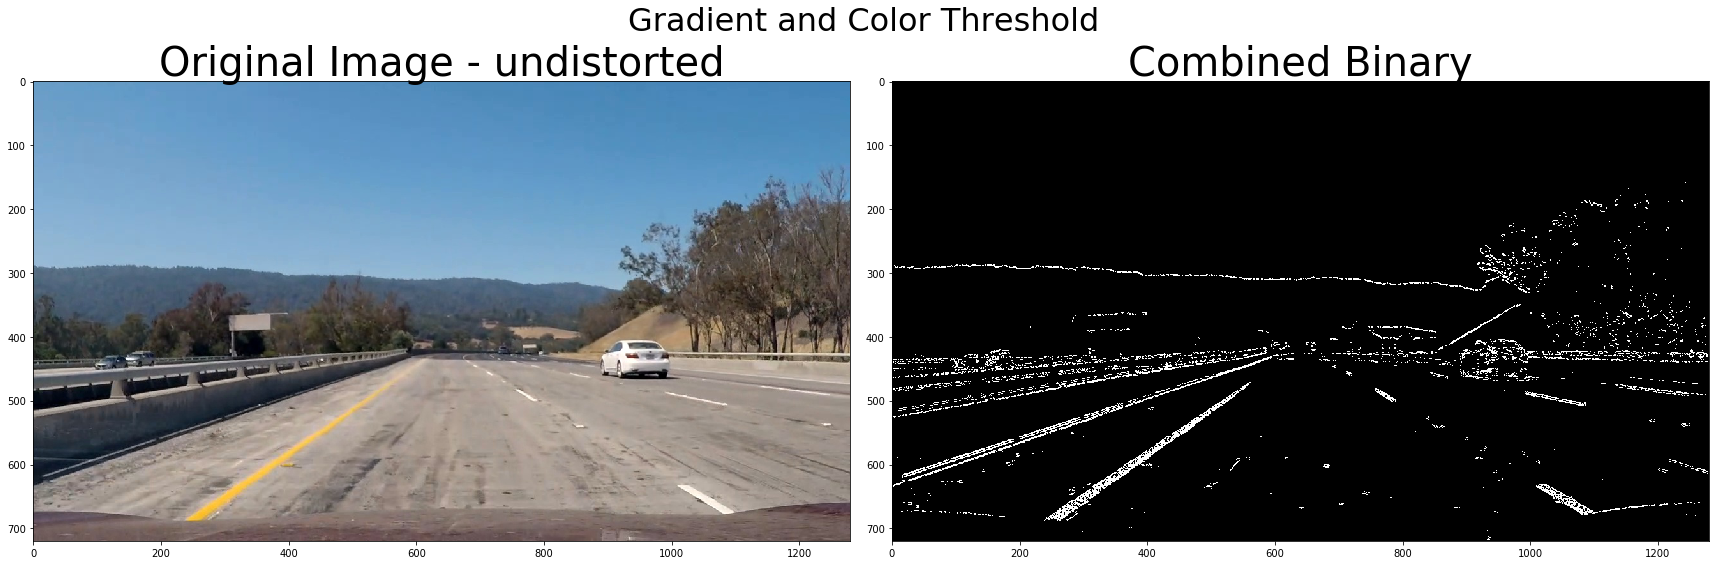

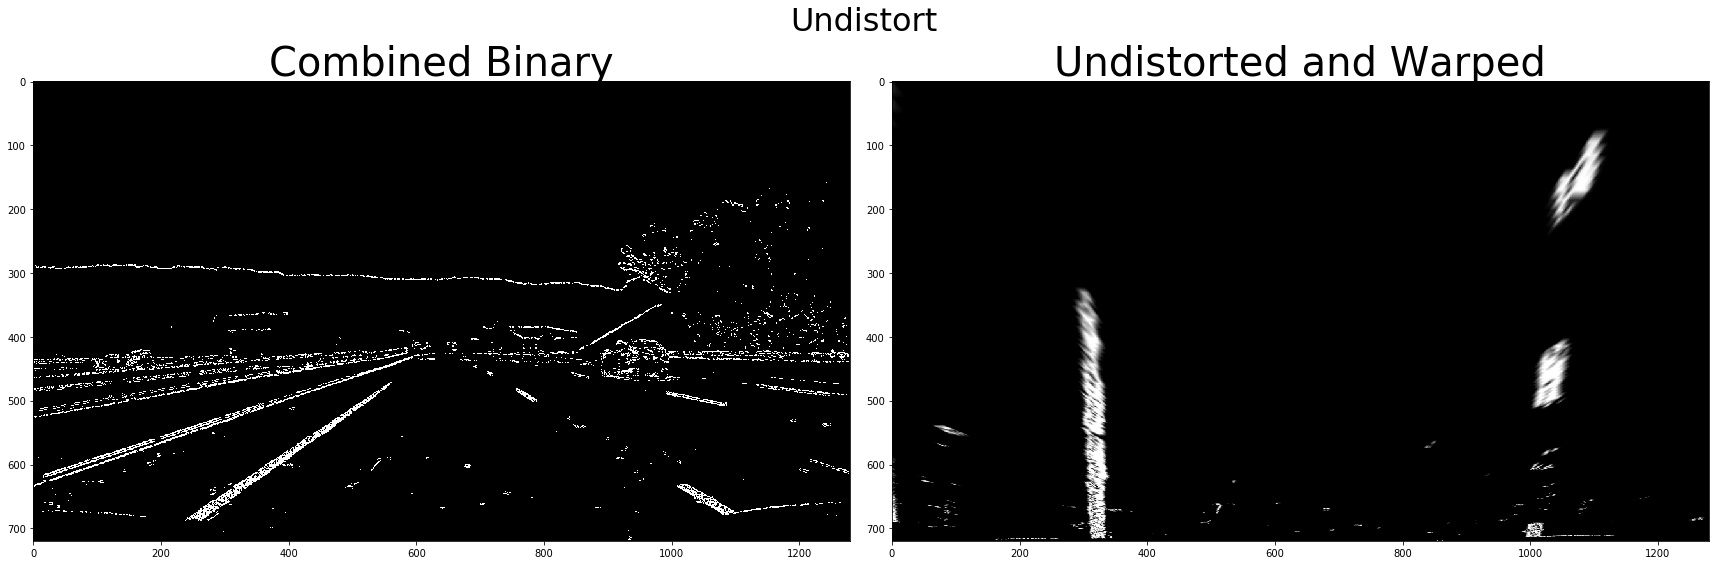

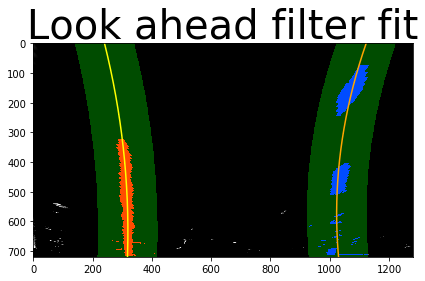

In [34]:
left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M, plot=True, left_fit=left_fit, right_fit=right_fit )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))

In [35]:
# plot lane overlay on original image
def plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist, lane_radius, xm_per_pix ):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Project lines on original image

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ###print("color_warp.shape={}".format(color_warp.shape))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    image_with_lane = cv2.addWeighted(image_undistorted, 1, newwarp, 0.3, 0)
    
    off_center, lane_width = lane_offset( left_fit, right_fit, binary_warped.shape, xm_per_pix )
    print("off_center={}, lane_width={}".format(off_center, lane_width))

    # curve to left or right
    if (left_fit[0] < 0):
        curve_dir = 'L'
    else:
        curve_dir = 'R'
        
    annotate_str = "Radius {0:.2f}({1}), Off-Center {2:.3f}".format(lane_radius, curve_dir, off_center)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image_with_lane,annotate_str,(10,100), font, 2,(255,255,255),3,cv2.LINE_AA)
    
    return image_with_lane



leftx.shape[0]=14515, rightx.shape[0]=15008
924.437103495 m 576.815563106 m 747.723894195 m
left_fit=[ -1.77653104e-04   2.30889787e-01   2.44523908e+02]
right_fit=[  2.84750325e-04  -3.35498981e-01   1.12133748e+03]
y_eval=719
left_x=318.69393806575926, right_x=1027.3185214079333
lane width=3.745587083380063
lane_center pixels=673.0062297368463
off_center=0.1744615000376162, lane_width=3.745587083380063


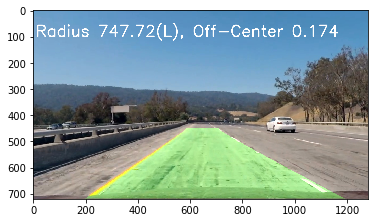

In [36]:
# test plot_lane with find_lane sliding windows
left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))

image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist, lane_radius, xm_per_pix)

plt.imshow(image_with_lane)

leftx.shape[0]=14534, rightx.shape[0]=15066
838.754488345 m 543.977185354 m 688.7168246 m
left_fit=[ -1.95803530e-04   2.48391136e-01   2.40460758e+02]
right_fit=[  3.01955965e-04  -3.46602146e-01   1.12260578e+03]
y_eval=719
left_x=317.83119606058585, right_x=1029.498294653529
lane width=3.7616689497055567
lane_center pixels=673.6647453570574
off_center=0.17794222545873212, lane_width=3.7616689497055567


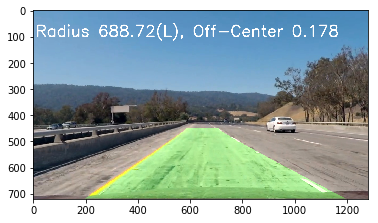

In [37]:
# test plot_lane with find_lane look ahead filter
left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M, left_fit=left_fit, right_fit=right_fit )
print("left_fit={}".format(left_fit))
print("right_fit={}".format(right_fit))

image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist, lane_radius, xm_per_pix)

plt.imshow(image_with_lane)

leftx.shape[0]=48371, rightx.shape[0]=29479
7831.26603193 m 2077.26155459 m 5652.4311188 m
image path=straight_lines1.jpg
left_fit=[ -2.09706570e-05   2.60454707e-02   3.19423500e+02]
right_fit=[ -7.90630171e-05   6.92246701e-02   9.48323450e+02]
y_eval=719
left_x=327.3091814576047, right_x=957.2234918427919
lane width=3.3295470691788465
lane_center pixels=642.2663366501984
off_center=0.011979208008191303, lane_width=3.3295470691788465
leftx.shape[0]=26956, rightx.shape[0]=51179
8776.84867407 m 3417.78239743 m 5266.62082519 m
image path=straight_lines2.jpg
left_fit=[  1.87121343e-05   1.46443411e-02   3.12831681e+02]
right_fit=[ -4.80556329e-05   3.67807076e-03   9.83871193e+02]
y_eval=719
left_x=333.0344055232402, right_x=961.6728373843717
lane width=3.3228031398374096
lane_center pixels=647.353621453806
off_center=0.03886914197011743, lane_width=3.3228031398374096
leftx.shape[0]=31603, rightx.shape[0]=13159
860.641938062 m 342.83489364 m 708.418558911 m
image path=test1.jpg
left_fit=

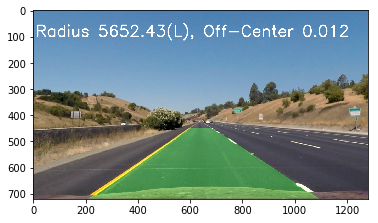

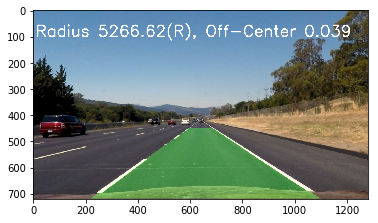

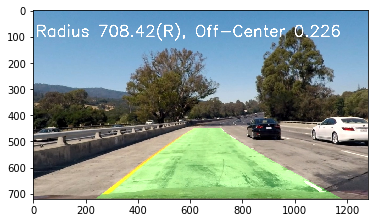

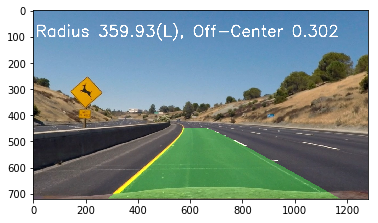

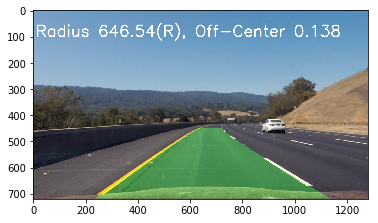

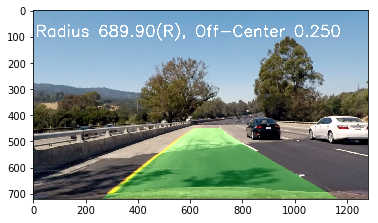

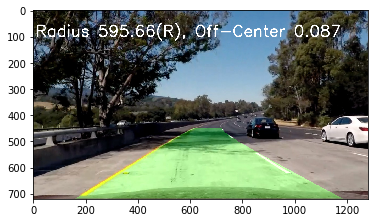

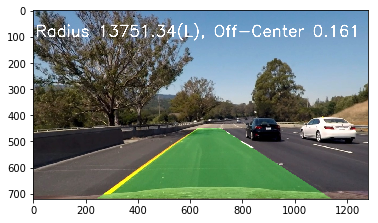

In [38]:
# run find_lane with test images
import os
img_dir = './test_images/'
count=1
for img_path in os.listdir( img_dir ):
    image = mpimg.imread( img_dir + img_path )
    
    left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M )
    print("image path={}".format(img_path))
    print("left_fit={}".format(left_fit))
    print("right_fit={}".format(right_fit))

    image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist, lane_radius, xm_per_pix)

    plt.figure(count)
    plt.imshow(image_with_lane)
    count += 1


In [39]:
# find lane and plot lane on image
def process_image(image):
    
    left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M )
    #image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist)
    image_with_lane = plot_lane( image, binary_warped, left_fit, right_fit, Minv, mtx, dist, lane_radius, xm_per_pix)
    return image_with_lane

leftx.shape[0]=46228, rightx.shape[0]=27431
5270.38901024 m 1690.89812354 m 3937.36772957 m
y_eval=719
left_x=363.07711619301324, right_x=1010.5677804994788
lane width=3.422450654191318
lane_center pixels=686.822448346246
off_center=0.24749008411587176, lane_width=3.422450654191318


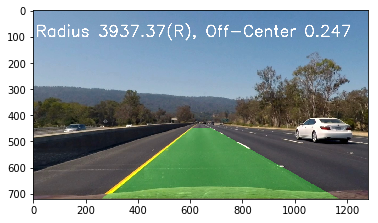

In [40]:
image = mpimg.imread('./debug_images/orig/frame330.jpg')
#left_fit, right_fit, binary_warped, lane_radius = find_lane( image, mtx, dist, M, plot=True )
image_with_lane = process_image(image)
plt.imshow(image_with_lane)

frame.shape=(720, 1280, 3)
leftx.shape[0]=27193, rightx.shape[0]=29644
291.545537556 m 780.057065665 m 546.334420489 m
y_eval=719
left_x=373.1485831072518, right_x=1039.2269713197275
lane width=3.5207000519802283
lane_center pixels=706.1877772134897
off_center=0.34984967955701674, lane_width=3.5207000519802283


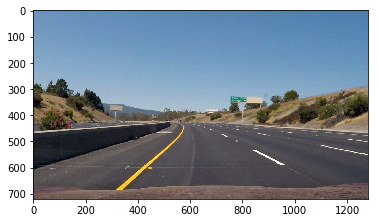

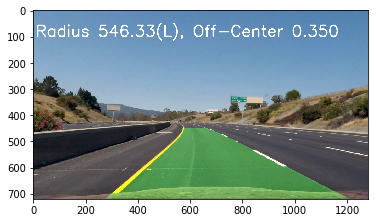

In [41]:
# try images from project video
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

cap = cv2.VideoCapture('project_video.mp4')
ret, frame = cap.read()
print("frame.shape={}".format(frame.shape))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite('./debug_images/project_video_frame1.jpg', frame)
plt.figure(1)
plt.imshow(frame_rgb)

# # 1. color and gradient binary
# threshold_binaries = \
#     colorAndGradientThresholdBinary(frame_rgb, color_thresh=(128, 255), sobel_thresh=(50, 135), ksize=5)
# combined_binary = threshold_binaries[0]

# # Plot the color and gradient result
# f, axes = plt.subplots(1, 2, squeeze=False, figsize=(24, 9))
# f.suptitle('Gradient and Color Threshold', fontsize=32)
# f.tight_layout()
# axes[0][0].imshow(frame_rgb)
# axes[0][0].set_title('Original Image - undistorted', fontsize=40)
# axes[0][1].imshow(combined_binary, cmap='gray')
# axes[0][1].set_title('Combined Binary', fontsize=40)
        
# left_fit, right_fit, binary_warped = find_lane( frame_rgb, mtx, dist, plot=True )
# plt.figure(2)
# plt.imshow(binary_warped)

# image_with_lane = plot_lane( frame_rgb, binary_warped, left_fit, right_fit, Minv, mtx, dist)

image_with_lane = process_image(frame_rgb)
cv2.imwrite('./debug_images/project_video_frame1_lane.jpg', image_with_lane)
plt.figure(2)
plt.imshow(image_with_lane)
        
cap.release()
# cv2.destroyAllWindows()

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

project_output = 'project_output_video.mp4'
clip = VideoFileClip("project_video.mp4").subclip(0,15)
project_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


leftx.shape[0]=31044, rightx.shape[0]=30121
336.73342946 m 930.863409392 m 629.315610864 m
y_eval=719
left_x=373.9322766945166, right_x=1043.2668125493371
lane width=3.537911118089766
lane_center pixels=708.5995446219268
off_center=0.3625975930016133, lane_width=3.537911118089766
[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


  0%|          | 1/376 [00:00<02:24,  2.60it/s]

leftx.shape[0]=31044, rightx.shape[0]=30121
336.73342946 m 930.863409392 m 629.315610864 m
y_eval=719
left_x=373.9322766945166, right_x=1043.2668125493371
lane width=3.537911118089766
lane_center pixels=708.5995446219268
off_center=0.3625975930016133, lane_width=3.537911118089766


  1%|          | 2/376 [00:00<02:29,  2.51it/s]

leftx.shape[0]=28979, rightx.shape[0]=29676
319.777276476 m 846.70147374 m 586.370107062 m
y_eval=719
left_x=375.1689348250528, right_x=1039.962135485799
lane width=3.5139069177782303
lane_center pixels=707.565535155426
off_center=0.35713211439296605, lane_width=3.5139069177782303


  1%|          | 3/376 [00:01<02:31,  2.45it/s]

leftx.shape[0]=30210, rightx.shape[0]=27170
349.952147218 m 686.665952183 m 509.389478708 m
y_eval=719
left_x=378.3867543088911, right_x=1033.8155142144956
lane width=3.464409159501052
lane_center pixels=706.1011342616933
off_center=0.34939170966895056, lane_width=3.464409159501052


  1%|          | 4/376 [00:01<02:30,  2.47it/s]

leftx.shape[0]=30621, rightx.shape[0]=25845
375.255788349 m 698.450760965 m 523.18505671 m
y_eval=719
left_x=381.14993908199494, right_x=1034.111453549282
lane width=3.451368005041375
lane_center pixels=707.6306963156385
off_center=0.3574765376683749, lane_width=3.451368005041375


  1%|▏         | 5/376 [00:02<02:27,  2.51it/s]

leftx.shape[0]=31924, rightx.shape[0]=26930
442.818273114 m 704.169778217 m 562.405659399 m
y_eval=719
left_x=387.42272029119306, right_x=1035.296218183424
lane width=3.4244742031446487
lane_center pixels=711.3594692373085
off_center=0.37718576596863085, lane_width=3.4244742031446487


  2%|▏         | 6/376 [00:02<02:25,  2.54it/s]

leftx.shape[0]=29678, rightx.shape[0]=26008
349.909398618 m 476.042222538 m 408.81940265 m
y_eval=719
left_x=384.8035172714695, right_x=1026.0039379880382
lane width=3.389202223787578
lane_center pixels=705.4037276297538
off_center=0.3457054174715558, lane_width=3.389202223787578


  2%|▏         | 7/376 [00:02<02:23,  2.57it/s]

leftx.shape[0]=31151, rightx.shape[0]=25002
412.629060035 m 487.400399695 m 445.920834903 m
y_eval=719
left_x=388.87541122326195, right_x=1027.3658532151376
lane width=3.3748780505284857
lane_center pixels=708.1206322191997
off_center=0.36006619887291275, lane_width=3.3748780505284857


  2%|▏         | 8/376 [00:03<02:21,  2.59it/s]

leftx.shape[0]=31700, rightx.shape[0]=24526
565.580065964 m 585.720871399 m 574.365563672 m
y_eval=719
left_x=395.7308825399854, right_x=1030.2397063931405
lane width=3.3538323546523916
lane_center pixels=712.9852944665629
off_center=0.3857794136089753, lane_width=3.3538323546523916


  2%|▏         | 9/376 [00:03<02:19,  2.63it/s]

leftx.shape[0]=31827, rightx.shape[0]=26623
543.819509685 m 657.1507867 m 595.440015895 m
y_eval=719
left_x=395.2858057952636, right_x=1032.8869981601383
lane width=3.3701777310714807
lane_center pixels=714.0864019777009
off_center=0.39159955331070484, lane_width=3.3701777310714807


  3%|▎         | 10/376 [00:03<02:20,  2.60it/s]

leftx.shape[0]=32979, rightx.shape[0]=28151
431.236337349 m 754.950692873 m 580.310160715 m
y_eval=719
left_x=390.21646101243823, right_x=1039.1920829343362
lane width=3.4302997158728896
lane_center pixels=714.7042719733872
off_center=0.3948654375736182, lane_width=3.4302997158728896


  3%|▎         | 11/376 [00:04<02:23,  2.55it/s]

leftx.shape[0]=32673, rightx.shape[0]=27247
453.232647291 m 1041.30562165 m 720.642933212 m
y_eval=719
left_x=390.92351437769895, right_x=1043.787122611217
lane width=3.450850500662882
lane_center pixels=717.355318494458
off_center=0.40887811204213487, lane_width=3.450850500662882


  3%|▎         | 12/376 [00:04<02:23,  2.53it/s]

leftx.shape[0]=32182, rightx.shape[0]=28807
525.372993756 m 868.213297276 m 687.307123247 m
y_eval=719
left_x=390.02886270526665, right_x=1040.3729256752547
lane width=3.4375329042699367
lane_center pixels=715.2008941902607
off_center=0.39749044071994927, lane_width=3.4375329042699367


  3%|▎         | 13/376 [00:05<02:24,  2.51it/s]

leftx.shape[0]=33782, rightx.shape[0]=26802
489.355501354 m 1378.63341382 m 882.766742108 m
y_eval=719
left_x=388.5771826539361, right_x=1043.9831459382053
lane width=3.4642886630739946
lane_center pixels=716.2801642960708
off_center=0.40319515413637413, lane_width=3.4642886630739946


  4%|▎         | 14/376 [00:05<02:26,  2.48it/s]

leftx.shape[0]=31555, rightx.shape[0]=28891
436.175954517 m 871.168906359 m 644.086839798 m
y_eval=719
left_x=385.86050184884743, right_x=1040.1277381036537
lane width=3.458269677346833
lane_center pixels=712.9941199762505
off_center=0.38582606273161, lane_width=3.458269677346833


  4%|▍         | 15/376 [00:05<02:27,  2.45it/s]

leftx.shape[0]=30823, rightx.shape[0]=25923
400.321755081 m 776.929692351 m 572.365732768 m
y_eval=719
left_x=385.10683663436237, right_x=1033.613392384825
lane width=3.427820366109588
lane_center pixels=709.3601145095936
off_center=0.36661774812213754, lane_width=3.427820366109588


  4%|▍         | 16/376 [00:06<02:27,  2.44it/s]

leftx.shape[0]=29926, rightx.shape[0]=23927
395.852745759 m 724.652891473 m 541.939334928 m
y_eval=719
left_x=385.5939864033754, right_x=1028.346793052068
lane width=3.397407692285947
lane_center pixels=706.9703897277218
off_center=0.3539863457036724, lane_width=3.397407692285947


  5%|▍         | 17/376 [00:06<02:30,  2.39it/s]

leftx.shape[0]=30972, rightx.shape[0]=25305
465.302767415 m 517.60520215 m 488.820600828 m
y_eval=719
left_x=388.0632801219149, right_x=1022.9369398323539
lane width=3.3557607727551777
lane_center pixels=705.5001099771343
off_center=0.34621486702199583, lane_width=3.3557607727551777


  5%|▍         | 18/376 [00:07<02:24,  2.48it/s]

leftx.shape[0]=30584, rightx.shape[0]=23411
572.300360369 m 451.794688013 m 520.051850405 m
y_eval=719
left_x=390.603421618629, right_x=1015.652741116544
lane width=3.3038321173461225
lane_center pixels=703.1280813675864
off_center=0.3336770015143855, lane_width=3.3038321173461225


  5%|▌         | 19/376 [00:07<02:24,  2.47it/s]

leftx.shape[0]=29061, rightx.shape[0]=23590
526.047753456 m 432.989465872 m 484.353483564 m
y_eval=719
left_x=387.5190707508117, right_x=1014.0426715181278
lane width=3.311624746912957
lane_center pixels=700.7808711344697
off_center=0.32127031885362584, lane_width=3.311624746912957


  5%|▌         | 20/376 [00:08<02:24,  2.47it/s]

leftx.shape[0]=30260, rightx.shape[0]=22776
513.79751637 m 441.471370814 m 482.737476186 m
y_eval=719
left_x=384.4024883811443, right_x=1009.6573681046293
lane width=3.3049186499669925
lane_center pixels=697.0299282428869
off_center=0.30144390642668767, lane_width=3.3049186499669925


  6%|▌         | 21/376 [00:08<02:20,  2.53it/s]

leftx.shape[0]=33135, rightx.shape[0]=23247
506.651332603 m 467.019184088 m 490.310504741 m
y_eval=719
left_x=382.43809996982833, right_x=1008.5552583062996
lane width=3.3094764083499193
lane_center pixels=695.496679138064
off_center=0.29333958972976687, lane_width=3.3094764083499193


  6%|▌         | 22/376 [00:08<02:16,  2.60it/s]

leftx.shape[0]=34427, rightx.shape[0]=23709
468.29169395 m 501.949292327 m 482.017922104 m
y_eval=719
left_x=377.30307635809004, right_x=1015.3382477438917
lane width=3.3724716201820946
lane_center pixels=696.3206620509909
off_center=0.2976949279838091, lane_width=3.3724716201820946


  6%|▌         | 23/376 [00:09<02:11,  2.68it/s]

leftx.shape[0]=34284, rightx.shape[0]=25293
441.555757343 m 540.418025739 m 483.527044158 m
y_eval=719
left_x=373.1120578857641, right_x=1018.5320755008723
lane width=3.4115058073941436
lane_center pixels=695.8220666933182
off_center=0.29505949537896775, lane_width=3.4115058073941436


  6%|▋         | 24/376 [00:09<02:08,  2.75it/s]

leftx.shape[0]=31589, rightx.shape[0]=28392
459.830485429 m 549.547034275 m 502.297804327 m
y_eval=719
left_x=371.386624881825, right_x=1021.6304410580832
lane width=3.437003028360222
lane_center pixels=696.5085329699541
off_center=0.2986879599840431, lane_width=3.437003028360222


  7%|▋         | 25/376 [00:09<02:08,  2.73it/s]

leftx.shape[0]=30326, rightx.shape[0]=26089
483.096438297 m 761.419523769 m 611.806373188 m
y_eval=719
left_x=372.20782040869324, right_x=1026.0820059209605
lane width=3.456192123421984
lane_center pixels=699.1449131648269
off_center=0.3126231124426565, lane_width=3.456192123421984


  7%|▋         | 26/376 [00:10<02:06,  2.76it/s]

leftx.shape[0]=30940, rightx.shape[0]=26208
455.545923149 m 823.899612991 m 624.47245607 m
y_eval=719
left_x=367.6946304059944, right_x=1027.3428034457063
lane width=3.4867117717813345
lane_center pixels=697.5187169258504
off_center=0.30402750375092363, lane_width=3.4867117717813345


  7%|▋         | 27/376 [00:10<02:04,  2.80it/s]

leftx.shape[0]=31051, rightx.shape[0]=27551
356.116323134 m 994.482417066 m 656.236186858 m
y_eval=719
left_x=361.464904746762, right_x=1034.4781663432482
lane width=3.557355811295713
lane_center pixels=697.971535545005
off_center=0.30642097359502674, lane_width=3.557355811295713


  7%|▋         | 28/376 [00:10<02:05,  2.77it/s]

leftx.shape[0]=34019, rightx.shape[0]=29955
367.203056158 m 1179.19155848 m 747.406194732 m
y_eval=719
left_x=359.82733877653686, right_x=1036.0074654345337
lane width=3.5740949551922694
lane_center pixels=697.9174021055353
off_center=0.3061348397006866, lane_width=3.5740949551922694


  8%|▊         | 29/376 [00:11<02:03,  2.82it/s]

leftx.shape[0]=29566, rightx.shape[0]=28497
351.558230369 m 850.507890228 m 596.439970152 m
y_eval=719
left_x=360.12124419052765, right_x=1031.1438035079807
lane width=3.546833527820823
lane_center pixels=695.6325238492542
off_center=0.29405762606034364, lane_width=3.546833527820823


  8%|▊         | 30/376 [00:11<02:01,  2.84it/s]

leftx.shape[0]=30567, rightx.shape[0]=24161
378.655095426 m 667.403462843 m 506.13004984 m
y_eval=719
left_x=364.27517531481675, right_x=1025.3262052534387
lane width=3.494126872532716
lane_center pixels=694.8006902841278
off_center=0.2896607915018182, lane_width=3.494126872532716


  8%|▊         | 31/376 [00:11<02:02,  2.82it/s]

leftx.shape[0]=27745, rightx.shape[0]=24250
313.842825403 m 608.952697937 m 451.479413709 m
y_eval=719
left_x=363.469190542988, right_x=1023.1561836485323
lane width=3.486916963557878
lane_center pixels=693.3126870957601
off_center=0.2817956317918749, lane_width=3.486916963557878


  9%|▊         | 32/376 [00:12<02:00,  2.85it/s]

leftx.shape[0]=25955, rightx.shape[0]=22916
320.266847152 m 399.67695432 m 357.502877023 m
y_eval=719
left_x=366.56915286478744, right_x=1013.2892986454633
lane width=3.418377913412144
lane_center pixels=689.9292257551253
off_center=0.2639116218485197, lane_width=3.418377913412144


  9%|▉         | 33/376 [00:12<02:00,  2.84it/s]

leftx.shape[0]=27042, rightx.shape[0]=22013
359.3239283 m 336.842302913 m 349.235496547 m
y_eval=719
left_x=366.945539539986, right_x=1004.825355596539
lane width=3.371650456298923
lane_center pixels=685.8854475682625
off_center=0.24253736571795906, lane_width=3.371650456298923


  9%|▉         | 34/376 [00:12<02:00,  2.84it/s]

leftx.shape[0]=27816, rightx.shape[0]=21483
344.160767815 m 514.644734099 m 418.452478553 m
y_eval=719
left_x=368.66774243453926, right_x=1023.5284032113525
lane width=3.4614063498202987
lane_center pixels=696.0980728229458
off_center=0.29651838492128507, lane_width=3.4614063498202987


  9%|▉         | 35/376 [00:13<01:59,  2.86it/s]

leftx.shape[0]=26581, rightx.shape[0]=25720
334.726887908 m 484.777600659 m 408.517146831 m
y_eval=719
left_x=369.4603871874946, right_x=1024.6195866071266
lane width=3.4629843397894837
lane_center pixels=697.0399868973107
off_center=0.3014970736000706, lane_width=3.4629843397894837


 10%|▉         | 36/376 [00:13<01:59,  2.84it/s]

leftx.shape[0]=24299, rightx.shape[0]=25901
289.170328002 m 571.623820873 m 434.903951883 m
y_eval=719
left_x=368.625128124831, right_x=1028.6191927218772
lane width=3.488540055727244
lane_center pixels=698.6221604233541
off_center=0.30985999080915744, lane_width=3.488540055727244


 10%|▉         | 37/376 [00:14<01:58,  2.86it/s]

leftx.shape[0]=22289, rightx.shape[0]=22642
254.167991986 m 571.641206529 m 414.151711994 m
y_eval=719
left_x=367.26211109885674, right_x=1024.2695556933993
lane width=3.4727536357140107
lane_center pixels=695.7658333961281
off_center=0.29476226223667695, lane_width=3.4727536357140107


 10%|█         | 38/376 [00:14<01:57,  2.88it/s]

leftx.shape[0]=23225, rightx.shape[0]=24396
261.845886128 m 501.975473762 m 384.863072242 m
y_eval=719
left_x=369.61582954025556, right_x=1023.579628340727
lane width=3.4566657936596354
lane_center pixels=696.5977289404913
off_center=0.2991594243997396, lane_width=3.4566657936596354


 10%|█         | 39/376 [00:14<01:58,  2.85it/s]

leftx.shape[0]=24595, rightx.shape[0]=23451
270.486582292 m 457.634190388 m 361.832345882 m
y_eval=719
left_x=370.0778337878605, right_x=1021.3091740980607
lane width=3.4422227987824865
lane_center pixels=695.6935039429607
off_center=0.29437994941279205, lane_width=3.4422227987824865


 11%|█         | 40/376 [00:15<01:58,  2.83it/s]

leftx.shape[0]=22359, rightx.shape[0]=21182
288.866770946 m 447.598156522 m 366.087050895 m
y_eval=719
left_x=372.6575571658732, right_x=1018.8841112094071
lane width=3.4157689285158224
lane_center pixels=695.7708341876402
off_center=0.2947886949918123, lane_width=3.4157689285158224


 11%|█         | 41/376 [00:15<02:02,  2.73it/s]

leftx.shape[0]=22527, rightx.shape[0]=19723
290.759989996 m 499.83162374 m 388.358092536 m
y_eval=719
left_x=374.7008054127451, right_x=1020.7148776832463
lane width=3.414645810572649
lane_center pixels=697.7078415479957
off_center=0.30502716246797734, lane_width=3.414645810572649


 11%|█         | 42/376 [00:15<02:02,  2.72it/s]

leftx.shape[0]=23505, rightx.shape[0]=20847
295.772171687 m 383.765109034 m 337.13194723 m
y_eval=719
left_x=377.53976273512984, right_x=1017.9242066396156
lane width=3.384889203495139
lane_center pixels=697.7319846873727
off_center=0.30515477620468423, lane_width=3.384889203495139


 11%|█▏        | 43/376 [00:16<02:03,  2.69it/s]

leftx.shape[0]=25153, rightx.shape[0]=23456
312.250613466 m 400.2442939 m 354.711469856 m
y_eval=719
left_x=380.2775398723045, right_x=1021.2283477575015
lane width=3.387882841678899
lane_center pixels=700.752943814903
off_center=0.3211227030216302, lane_width=3.387882841678899


 12%|█▏        | 44/376 [00:16<02:04,  2.66it/s]

leftx.shape[0]=26425, rightx.shape[0]=23362
319.630793218 m 411.154753113 m 362.577400787 m
y_eval=719
left_x=379.44457836704345, right_x=1020.1709022311061
lane width=3.386696283281474
lane_center pixels=699.8077402990748
off_center=0.31612662729510965, lane_width=3.386696283281474


 12%|█▏        | 45/376 [00:17<02:05,  2.63it/s]

leftx.shape[0]=28600, rightx.shape[0]=23187
339.439429081 m 376.2288965 m 355.911466099 m
y_eval=719
left_x=380.7361112915089, right_x=1018.3799830324122
lane width=3.3704033220590603
lane_center pixels=699.5580471619605
off_center=0.31480682071321997, lane_width=3.3704033220590603


 12%|█▏        | 46/376 [00:17<02:03,  2.68it/s]

leftx.shape[0]=31419, rightx.shape[0]=22702
371.836405687 m 348.069429132 m 361.866931698 m
y_eval=719
left_x=382.3054164314117, right_x=1008.7208043168444
lane width=3.311052764537287
lane_center pixels=695.513110374128
off_center=0.2934264405489624, lane_width=3.311052764537287


 12%|█▎        | 47/376 [00:17<02:05,  2.63it/s]

leftx.shape[0]=32188, rightx.shape[0]=23222
382.173732623 m 515.64380364 m 438.110242082 m
y_eval=719
left_x=381.89922930218574, right_x=1026.026451968941
lane width=3.4046724626671354
lane_center pixels=703.9628406355635
off_center=0.338089300502264, lane_width=3.4046724626671354


 13%|█▎        | 48/376 [00:18<02:08,  2.55it/s]

leftx.shape[0]=31560, rightx.shape[0]=26349
386.468287693 m 497.659073151 m 437.060872715 m
y_eval=719
left_x=381.6704223722229, right_x=1028.7087503374355
lane width=3.4200597335304095
lane_center pixels=705.1895863548292
off_center=0.3445735278755258, lane_width=3.4200597335304095


 13%|█▎        | 49/376 [00:18<02:06,  2.59it/s]

leftx.shape[0]=32100, rightx.shape[0]=27752
390.248877376 m 514.354948424 m 447.794016782 m
y_eval=719
left_x=380.0796390183456, right_x=1029.7703834678614
lane width=3.4340796492331553
lane_center pixels=704.9250112431034
off_center=0.34317505942783244, lane_width=3.4340796492331553


 13%|█▎        | 50/376 [00:18<02:05,  2.59it/s]

leftx.shape[0]=30008, rightx.shape[0]=25520
390.21181098 m 634.830051614 m 502.635408102 m
y_eval=719
left_x=380.94079979821237, right_x=1033.175227958094
lane width=3.4475248345593745
lane_center pixels=707.0580138781531
off_center=0.35444950192738084, lane_width=3.4475248345593745


 14%|█▎        | 51/376 [00:19<02:05,  2.60it/s]

leftx.shape[0]=30216, rightx.shape[0]=24974
379.901630724 m 860.66892361 m 597.453404099 m
y_eval=719
left_x=379.35769437873677, right_x=1035.183404840819
lane width=3.4665073267281494
lane_center pixels=707.270549609778
off_center=0.35557290508025496, lane_width=3.4665073267281494


 14%|█▍        | 52/376 [00:19<02:03,  2.63it/s]

leftx.shape[0]=28699, rightx.shape[0]=25318
352.05894159 m 560.547908675 m 449.778616298 m
y_eval=719
left_x=377.6544222405951, right_x=1028.9999796200088
lane width=3.4428265175769015
lane_center pixels=703.327200930302
off_center=0.33472949063159607, lane_width=3.4428265175769015


 14%|█▍        | 53/376 [00:20<02:00,  2.69it/s]

leftx.shape[0]=27514, rightx.shape[0]=24642
395.99544417 m 545.084265191 m 466.435024038 m
y_eval=719
left_x=380.4941410324006, right_x=1025.3581102810244
lane width=3.4085666945998687
lane_center pixels=702.9261256567125
off_center=0.33260952132833776, lane_width=3.4085666945998687


 14%|█▍        | 54/376 [00:20<01:58,  2.71it/s]

leftx.shape[0]=28681, rightx.shape[0]=21703
416.103397504 m 533.676030869 m 466.748024011 m
y_eval=719
left_x=379.71469645425475, right_x=1020.8073962563313
lane width=3.3886328418109763
lane_center pixels=700.261046355293
off_center=0.3185226735922633, lane_width=3.3886328418109763


 15%|█▍        | 55/376 [00:20<01:58,  2.72it/s]

leftx.shape[0]=28705, rightx.shape[0]=25522
461.358854174 m 548.4591069 m 502.352688428 m
y_eval=719
left_x=381.253688903449, right_x=1023.371268071405
lane width=3.3940500613163387
lane_center pixels=702.312478487427
off_center=0.32936595771925714, lane_width=3.3940500613163387


 15%|█▍        | 56/376 [00:21<01:57,  2.73it/s]

leftx.shape[0]=27467, rightx.shape[0]=25244
484.924336129 m 507.158194411 m 495.572427011 m
y_eval=719
left_x=380.245589415122, right_x=1020.7771958487328
lane width=3.3856670625776575
lane_center pixels=700.5113926319275
off_center=0.3198459324830453, lane_width=3.3856670625776575


 15%|█▌        | 57/376 [00:21<01:55,  2.75it/s]

leftx.shape[0]=28004, rightx.shape[0]=25018
433.143644995 m 453.125538372 m 442.571939071 m
y_eval=719
left_x=377.9898379871926, right_x=1018.1842198741551
lane width=3.383884589973945
lane_center pixels=698.0870289306738
off_center=0.3070314386335615, lane_width=3.383884589973945


 15%|█▌        | 58/376 [00:21<01:58,  2.69it/s]

leftx.shape[0]=30693, rightx.shape[0]=23246
588.920638492 m 461.923298056 m 534.18880854 m
y_eval=719
left_x=380.86016867821496, right_x=1013.2065337130472
lane width=3.342402215184113
lane_center pixels=697.0333511956311
off_center=0.30146199917690725, lane_width=3.342402215184113


 16%|█▌        | 59/376 [00:22<01:59,  2.66it/s]

leftx.shape[0]=31862, rightx.shape[0]=27009
411.14606361 m 755.394673197 m 569.081391638 m
y_eval=719
left_x=374.57479175652816, right_x=1031.1822326628312
lane width=3.4706393305047447
lane_center pixels=702.8785122096797
off_center=0.33235785025116404, lane_width=3.4706393305047447


 16%|█▌        | 60/376 [00:22<01:57,  2.68it/s]

leftx.shape[0]=31917, rightx.shape[0]=24230
397.95556476 m 1025.18136861 m 668.632203358 m
y_eval=719
left_x=372.07997598866575, right_x=1030.1893533773475
lane width=3.4785781376258895
lane_center pixels=701.1346646830066
off_center=0.32314037046732047, lane_width=3.4785781376258895


 16%|█▌        | 61/376 [00:23<01:57,  2.67it/s]

leftx.shape[0]=30631, rightx.shape[0]=21887
423.337728715 m 874.647349997 m 611.422074673 m
y_eval=719
left_x=372.7899512852533, right_x=1021.787316877612
lane width=3.430414646702468
lane_center pixels=697.2886340814327
off_center=0.30281135157328737, lane_width=3.430414646702468


 16%|█▋        | 62/376 [00:23<01:57,  2.67it/s]

leftx.shape[0]=31299, rightx.shape[0]=21585
381.190325038 m 769.949277512 m 539.865198141 m
y_eval=719
left_x=370.24308657236463, right_x=1020.2162822312418
lane width=3.435572605625494
lane_center pixels=695.2296844018033
off_center=0.29192833183810313, lane_width=3.435572605625494


 17%|█▋        | 63/376 [00:23<01:57,  2.67it/s]

leftx.shape[0]=33806, rightx.shape[0]=22809
420.487054825 m 977.135345279 m 644.749014676 m
y_eval=719
left_x=370.10954168833564, right_x=1020.4370628128653
lane width=3.4374454688010854
lane_center pixels=695.2733022506004
off_center=0.29215888332460216, lane_width=3.4374454688010854


 17%|█▋        | 64/376 [00:24<01:55,  2.71it/s]

leftx.shape[0]=32103, rightx.shape[0]=21374
403.471494941 m 727.74543665 m 533.07919975 m
y_eval=719
left_x=368.11765306222253, right_x=1014.9682502941304
lane width=3.419067442511513
lane_center pixels=691.5429516781765
off_center=0.2724413160132184, lane_width=3.419067442511513


 17%|█▋        | 65/376 [00:24<01:54,  2.73it/s]

leftx.shape[0]=33478, rightx.shape[0]=19947
428.875062822 m 1047.85758657 m 659.981181704 m
y_eval=719
left_x=367.81986739595783, right_x=1016.2919313599755
lane width=3.4276380523812366
lane_center pixels=692.0558993779666
off_center=0.2751526109978236, lane_width=3.4276380523812366


 18%|█▊        | 66/376 [00:24<01:53,  2.73it/s]

leftx.shape[0]=33195, rightx.shape[0]=23255
422.829973569 m 505.699311721 m 456.968617656 m
y_eval=719
left_x=367.4481878509396, right_x=1007.3719155962511
lane width=3.3824539895109327
lane_center pixels=687.4100517235954
off_center=0.2505959876818615, lane_width=3.3824539895109327


 18%|█▊        | 67/376 [00:25<01:53,  2.72it/s]

leftx.shape[0]=32189, rightx.shape[0]=23814
384.490326985 m 485.014568372 m 427.23597069 m
y_eval=719
left_x=364.42773940172657, right_x=1004.9970627363102
lane width=3.3858664233399427
lane_center pixels=684.7124010690184
off_center=0.2363369770790971, lane_width=3.3858664233399427


 18%|█▊        | 68/376 [00:25<01:52,  2.74it/s]

leftx.shape[0]=31827, rightx.shape[0]=23449
400.061525617 m 501.808764009 m 443.224399071 m
y_eval=719
left_x=364.3215625944539, right_x=1001.6602713468991
lane width=3.3687903176914964
lane_center pixels=682.9909169706765
off_center=0.22723770398786147, lane_width=3.3687903176914964


 18%|█▊        | 69/376 [00:25<01:53,  2.71it/s]

leftx.shape[0]=31152, rightx.shape[0]=23274
404.481419461 m 490.179270244 m 441.128091624 m
y_eval=719
left_x=364.94900242456146, right_x=999.5880806169137
lane width=3.3545208418738617
lane_center pixels=682.2685415207376
off_center=0.22341943375247011, lane_width=3.3545208418738617


 19%|█▊        | 70/376 [00:26<01:51,  2.74it/s]

leftx.shape[0]=32754, rightx.shape[0]=24720
467.21765118 m 503.90231227 m 482.996000036 m
y_eval=719
left_x=365.4102814704759, right_x=999.7075066949094
lane width=3.3527139047577204
lane_center pixels=682.5588940826926
off_center=0.22495415443708963, lane_width=3.3527139047577204


 19%|█▉        | 71/376 [00:26<01:54,  2.66it/s]

leftx.shape[0]=32325, rightx.shape[0]=24429
492.094476315 m 613.821911416 m 544.490422188 m
y_eval=719
left_x=366.5812459937398, right_x=1006.5143206728646
lane width=3.382503394732517
lane_center pixels=686.5477833333023
off_center=0.24603828333316918, lane_width=3.382503394732517


 19%|█▉        | 72/376 [00:27<01:54,  2.66it/s]

leftx.shape[0]=32480, rightx.shape[0]=24075
568.499187405 m 692.673298098 m 621.35908865 m
y_eval=719
left_x=367.01847631314513, right_x=1009.8067497639975
lane width=3.397595159668791
lane_center pixels=688.4126130385713
off_center=0.255895240346734, lane_width=3.397595159668791


 19%|█▉        | 73/376 [00:27<01:52,  2.69it/s]

leftx.shape[0]=31240, rightx.shape[0]=24461
517.487031321 m 639.703956311 m 571.15838735 m
y_eval=719
left_x=364.5700217942912, right_x=1004.1730896094846
lane width=3.3807590727374506
lane_center pixels=684.3715557018879
off_center=0.23453536585283621, lane_width=3.3807590727374506


 20%|█▉        | 74/376 [00:27<01:52,  2.68it/s]

leftx.shape[0]=31020, rightx.shape[0]=23075
582.433490821 m 510.536470606 m 551.76478315 m
y_eval=719
left_x=365.2793387626908, right_x=996.2622990480635
lane width=3.335195647222684
lane_center pixels=680.7708189053772
off_center=0.21550289992842211, lane_width=3.335195647222684


 20%|█▉        | 75/376 [00:28<01:51,  2.70it/s]

leftx.shape[0]=33386, rightx.shape[0]=23290
536.446555312 m 592.814765224 m 559.610074418 m
y_eval=719
left_x=361.6382076873558, right_x=1000.9045501834357
lane width=3.378979238907851
lane_center pixels=681.2713789353958
off_center=0.2181487172299491, lane_width=3.378979238907851


 20%|██        | 76/376 [00:28<01:49,  2.74it/s]

leftx.shape[0]=32914, rightx.shape[0]=23468
496.77184474 m 555.499393423 m 521.216137466 m
y_eval=719
left_x=359.8014937180168, right_x=1001.1779162914894
lane width=3.3901325193169267
lane_center pixels=680.4897050047531
off_center=0.21401701216798064, lane_width=3.3901325193169267


 20%|██        | 77/376 [00:28<01:50,  2.69it/s]

leftx.shape[0]=34172, rightx.shape[0]=24861
656.095428135 m 501.514530874 m 590.995641798 m
y_eval=719
left_x=359.83490884841177, right_x=1000.3263447500088
lane width=3.385454732622727
lane_center pixels=680.0806267992103
off_center=0.21185474165296891, lane_width=3.385454732622727


 21%|██        | 78/376 [00:29<01:50,  2.70it/s]

leftx.shape[0]=37027, rightx.shape[0]=25982
559.916785103 m 512.576038834 m 540.395648923 m
y_eval=719
left_x=355.732453128276, right_x=1001.310337008357
lane width=3.4123402433661427
lane_center pixels=678.5213950683165
off_center=0.20361308821824411, lane_width=3.4123402433661427


 21%|██        | 79/376 [00:29<01:49,  2.71it/s]

leftx.shape[0]=37556, rightx.shape[0]=24842
542.862059335 m 448.096922806 m 505.133998793 m
y_eval=719
left_x=352.3085076576144, right_x=997.453399837311
lane width=3.410051572949825
lane_center pixels=674.8809537474627
off_center=0.18437075552230306, lane_width=3.410051572949825


 21%|██▏       | 80/376 [00:30<01:49,  2.71it/s]

leftx.shape[0]=36529, rightx.shape[0]=23709
487.935019721 m 482.490695882 m 485.792195027 m
y_eval=719
left_x=349.0614620149862, right_x=997.9371082766585
lane width=3.4297712730974106
lane_center pixels=673.4992851458223
off_center=0.17706765005648953, lane_width=3.4297712730974106


 22%|██▏       | 81/376 [00:30<01:49,  2.70it/s]

leftx.shape[0]=36495, rightx.shape[0]=25817
540.293352983 m 449.91391444 m 502.84750042 m
y_eval=719
left_x=350.1973220761247, right_x=995.3943128380762
lane width=3.4103269511703154
lane_center pixels=672.7958174571004
off_center=0.17334932084467347, lane_width=3.4103269511703154


 22%|██▏       | 82/376 [00:30<01:50,  2.66it/s]

leftx.shape[0]=36121, rightx.shape[0]=25951
456.531709924 m 429.705618786 m 445.316284432 m
y_eval=719
left_x=344.79611328109974, right_x=994.1021012900303
lane width=3.4320459366186333
lane_center pixels=669.449107285565
off_center=0.15565956708084352, lane_width=3.4320459366186333


 22%|██▏       | 83/376 [00:31<01:49,  2.66it/s]

leftx.shape[0]=35492, rightx.shape[0]=24508
464.758541049 m 415.567607412 m 444.665684356 m
y_eval=719
left_x=343.5223549281343, right_x=991.7930873748285
lane width=3.426573871503955
lane_center pixels=667.6577211514814
off_center=0.14619081180068733, lane_width=3.426573871503955


 22%|██▏       | 84/376 [00:31<01:49,  2.66it/s]

leftx.shape[0]=40386, rightx.shape[0]=24809
559.326910279 m 425.911681222 m 508.557703781 m
y_eval=719
left_x=342.9488324429326, right_x=991.5539836386811
lane width=3.4283415134632422
lane_center pixels=667.2514080408068
off_center=0.14404315678712185, lane_width=3.4283415134632422


 23%|██▎       | 85/376 [00:31<01:52,  2.59it/s]

leftx.shape[0]=39309, rightx.shape[0]=25070
503.941274543 m 589.472069734 m 537.248052148 m
y_eval=719
left_x=339.97768783699155, right_x=1006.9971690789429
lane width=3.5256744008503142
lane_center pixels=673.4874284579672
off_center=0.17700497899211243, lane_width=3.5256744008503142


 23%|██▎       | 86/376 [00:32<01:49,  2.64it/s]

leftx.shape[0]=39033, rightx.shape[0]=27917
458.519598933 m 544.115831397 m 494.211757584 m
y_eval=719
left_x=339.1968957524807, right_x=1005.2819499211366
lane width=3.5207352863200385
lane_center pixels=672.2394228368087
off_center=0.17040837785170299, lane_width=3.5207352863200385


 23%|██▎       | 87/376 [00:32<01:49,  2.64it/s]

leftx.shape[0]=35948, rightx.shape[0]=26701
517.359769768 m 890.844567418 m 676.538967873 m
y_eval=719
left_x=343.4766358708425, right_x=1013.0855020434312
lane width=3.5393611497693978
lane_center pixels=678.2810689571369
off_center=0.2023427930591521, lane_width=3.5393611497693978


 23%|██▎       | 88/376 [00:33<01:48,  2.65it/s]

leftx.shape[0]=32970, rightx.shape[0]=23230
365.025335602 m 730.581799628 m 516.126343775 m
y_eval=719
left_x=337.80985094156557, right_x=1007.0201066240343
lane width=3.5372542086073344
lane_center pixels=672.4149787828
off_center=0.17133631642337116, lane_width=3.5372542086073344


 24%|██▎       | 89/376 [00:33<01:46,  2.69it/s]

leftx.shape[0]=31561, rightx.shape[0]=23165
339.916897166 m 851.700195186 m 556.54994359 m
y_eval=719
left_x=338.00964509596, right_x=1008.2548637383111
lane width=3.5427247271095705
lane_center pixels=673.1322544171355
off_center=0.1751276304905735, lane_width=3.5427247271095705


 24%|██▍       | 90/376 [00:33<01:46,  2.67it/s]

leftx.shape[0]=31002, rightx.shape[0]=21143
355.126400121 m 478.401188568 m 405.110077408 m
y_eval=719
left_x=342.76712860133705, right_x=995.8392897177984
lane width=3.4519528516155815
lane_center pixels=669.3032091595677
off_center=0.15488839127200071, lane_width=3.4519528516155815


 24%|██▍       | 91/376 [00:34<01:46,  2.67it/s]

leftx.shape[0]=31649, rightx.shape[0]=24701
350.141732992 m 462.870353837 m 399.556278928 m
y_eval=719
left_x=341.5254783500748, right_x=994.9341333701509
lane width=3.453731462248974
lane_center pixels=668.2298058601128
off_center=0.14921468811773927, lane_width=3.453731462248974


 24%|██▍       | 92/376 [00:34<01:44,  2.72it/s]

leftx.shape[0]=31719, rightx.shape[0]=22997
350.509753445 m 390.871739169 m 367.473796608 m
y_eval=719
left_x=343.2869452956872, right_x=992.3014644846392
lane width=3.430505315713032
lane_center pixels=667.7942048901632
off_center=0.1469122258480055, lane_width=3.430505315713032


 25%|██▍       | 93/376 [00:34<01:49,  2.59it/s]

leftx.shape[0]=30937, rightx.shape[0]=25058
306.112492029 m 422.836847511 m 358.347136188 m
y_eval=719
left_x=342.551215439167, right_x=991.3363918755163
lane width=3.4292930754492748
lane_center pixels=666.9438036573416
off_center=0.14241724790309143, lane_width=3.4292930754492748


 25%|██▌       | 94/376 [00:35<01:47,  2.62it/s]

leftx.shape[0]=31745, rightx.shape[0]=24511
374.612005475 m 459.231877402 m 411.481275967 m
y_eval=719
left_x=350.5612494267468, right_x=990.1002780173102
lane width=3.380420579692978
lane_center pixels=670.3307637220285
off_center=0.16031975110215038, lane_width=3.380420579692978


 25%|██▌       | 95/376 [00:35<01:45,  2.65it/s]

leftx.shape[0]=32360, rightx.shape[0]=23189
386.504628882 m 482.68954773 m 426.657144376 m
y_eval=719
left_x=349.4080878312427, right_x=989.9905376303509
lane width=3.3859358060810005
lane_center pixels=669.6993127307968
off_center=0.15698208157706883, lane_width=3.3859358060810005


 26%|██▌       | 96/376 [00:36<01:46,  2.62it/s]

leftx.shape[0]=32491, rightx.shape[0]=25057
376.306316059 m 505.966212875 m 432.761588779 m
y_eval=719
left_x=349.38286752941855, right_x=994.0415408485741
lane width=3.407481558972679
lane_center pixels=671.7122041889963
off_center=0.16762165071326637, lane_width=3.407481558972679


 26%|██▌       | 97/376 [00:36<01:45,  2.64it/s]

leftx.shape[0]=32716, rightx.shape[0]=25130
364.827071974 m 643.712325382 m 485.983010468 m
y_eval=719
left_x=349.5163117057665, right_x=1002.7126504281325
lane width=3.4526092189610775
lane_center pixels=676.1144810669496
off_center=0.19089082849673342, lane_width=3.4526092189610775


 26%|██▌       | 98/376 [00:36<01:46,  2.61it/s]

leftx.shape[0]=32481, rightx.shape[0]=27031
364.363439414 m 690.464932913 m 512.482297305 m
y_eval=719
left_x=349.0015437815481, right_x=1003.8114539251977
lane width=3.4611380964735767
lane_center pixels=676.4064988533729
off_center=0.19243435108211396, lane_width=3.4611380964735767


 26%|██▋       | 99/376 [00:37<01:44,  2.64it/s]

leftx.shape[0]=30925, rightx.shape[0]=23219
375.572020676 m 624.725966303 m 482.418678912 m
y_eval=719
left_x=351.15703673566225, right_x=997.8845160423149
lane width=3.418416676335164
lane_center pixels=674.5207763889886
off_center=0.18246696091322528, lane_width=3.418416676335164


 27%|██▋       | 100/376 [00:37<01:43,  2.65it/s]

leftx.shape[0]=31561, rightx.shape[0]=24352
383.688092374 m 693.57605093 m 518.654765004 m
y_eval=719
left_x=351.24311604005095, right_x=1000.3317172796008
lane width=3.4308968922661918
lane_center pixels=675.7874166598258
off_center=0.18916205948765064, lane_width=3.4308968922661918


 27%|██▋       | 101/376 [00:37<01:44,  2.62it/s]

leftx.shape[0]=29724, rightx.shape[0]=24028
369.756431024 m 511.987401649 m 433.33593992 m
y_eval=719
left_x=351.97911194927354, right_x=993.8854396897716
lane width=3.3929334466283465
lane_center pixels=672.9322758195226
off_center=0.17407060076033376, lane_width=3.3929334466283465


 27%|██▋       | 102/376 [00:38<01:43,  2.65it/s]

leftx.shape[0]=27554, rightx.shape[0]=22964
341.813919283 m 536.546209527 m 430.333502662 m
y_eval=719
left_x=350.78992564254594, right_x=995.5404644279193
lane width=3.4079671335798314
lane_center pixels=673.1651950352326
off_center=0.17530174518622954, lane_width=3.4079671335798314


 27%|██▋       | 103/376 [00:38<01:42,  2.66it/s]

leftx.shape[0]=28872, rightx.shape[0]=22597
355.728645849 m 436.794369547 m 391.319820311 m
y_eval=719
left_x=352.7281588420782, right_x=990.9566403511888
lane width=3.373493402262442
lane_center pixels=671.8423995966334
off_center=0.16830982643934805, lane_width=3.373493402262442


 28%|██▊       | 104/376 [00:39<01:40,  2.69it/s]

leftx.shape[0]=28819, rightx.shape[0]=21897
355.067958189 m 432.684084347 m 388.579282317 m
y_eval=719
left_x=354.15850837809586, right_x=991.3779931176639
lane width=3.3681601336234315
lane_center pixels=672.7682507478798
off_center=0.17320361109593635, lane_width=3.3681601336234315


 28%|██▊       | 105/376 [00:39<01:42,  2.64it/s]

leftx.shape[0]=29383, rightx.shape[0]=23418
377.744733675 m 514.615550485 m 438.44890193 m
y_eval=719
left_x=354.43347348070336, right_x=996.1442058269344
lane width=3.3918995852586495
lane_center pixels=675.2888396538189
off_center=0.18652672388447109, lane_width=3.3918995852586495


 28%|██▊       | 106/376 [00:39<01:43,  2.61it/s]

leftx.shape[0]=30639, rightx.shape[0]=25604
393.287643013 m 521.966176979 m 451.867113946 m
y_eval=719
left_x=356.13191935441614, right_x=998.9310000483131
lane width=3.397652283667741
lane_center pixels=677.5314597013646
off_center=0.19838057270721296, lane_width=3.397652283667741


 28%|██▊       | 107/376 [00:40<01:43,  2.61it/s]

leftx.shape[0]=29339, rightx.shape[0]=24985
348.460597074 m 529.243300557 m 431.607196119 m
y_eval=719
left_x=353.72940191329315, right_x=1001.5864803428489
lane width=3.4243874145562234
lane_center pixels=677.657941128071
off_center=0.19904911739123246, lane_width=3.4243874145562234


 29%|██▊       | 108/376 [00:40<01:43,  2.60it/s]

leftx.shape[0]=29412, rightx.shape[0]=24387
348.900180503 m 348.900134806 m 348.900159789 m
y_eval=719
left_x=356.4408489921354, right_x=989.0374969361359
lane width=3.3437251391325744
lane_center pixels=672.7391729641356
off_center=0.17304991423900248, lane_width=3.3437251391325744


 29%|██▉       | 109/376 [00:41<01:42,  2.60it/s]

leftx.shape[0]=30132, rightx.shape[0]=24260
401.736767176 m 411.621454258 m 406.145549876 m
y_eval=719
left_x=359.98415057506827, right_x=995.6245326480214
lane width=3.3598134480998953
lane_center pixels=677.8043416115448
off_center=0.19982294851816554, lane_width=3.3598134480998953


 29%|██▉       | 110/376 [00:41<01:41,  2.62it/s]

leftx.shape[0]=29110, rightx.shape[0]=25476
291.729975565 m 441.295139419 m 361.533993341 m
y_eval=719
left_x=354.1917709368742, right_x=1001.155488113009
lane width=3.4196653622167132
lane_center pixels=677.6736295249416
off_center=0.19913204177469127, lane_width=3.4196653622167132


 30%|██▉       | 111/376 [00:41<01:40,  2.63it/s]

leftx.shape[0]=29834, rightx.shape[0]=27829
326.446258606 m 541.437683583 m 430.204237998 m
y_eval=719
left_x=357.53519939497914, right_x=1012.236430814229
lane width=3.460563651787464
lane_center pixels=684.885815104604
off_center=0.2372535941243356, lane_width=3.460563651787464


 30%|██▉       | 112/376 [00:42<01:38,  2.68it/s]

leftx.shape[0]=31152, rightx.shape[0]=28731
459.264628698 m 506.990441989 m 482.162785799 m
y_eval=719
left_x=362.1702242860143, right_x=1011.5194270774226
lane width=3.4322743576117296
lane_center pixels=686.8448256817185
off_center=0.24760836431765482, lane_width=3.4322743576117296


 30%|███       | 113/376 [00:42<01:36,  2.71it/s]

leftx.shape[0]=29050, rightx.shape[0]=24796
349.905962513 m 586.72267431 m 458.959693259 m
y_eval=719
left_x=359.519618511399, right_x=1012.7469179268878
lane width=3.452772868339012
lane_center pixels=686.1332682191435
off_center=0.2438472748726155, lane_width=3.452772868339012


 30%|███       | 114/376 [00:42<01:36,  2.72it/s]

leftx.shape[0]=29759, rightx.shape[0]=25785
331.482571999 m 501.609126518 m 410.459837019 m
y_eval=719
left_x=358.28348480198224, right_x=1010.8999465187103
lane width=3.44954415478842
lane_center pixels=684.5917156603463
off_center=0.2356990684904017, lane_width=3.44954415478842


 31%|███       | 115/376 [00:43<01:35,  2.73it/s]

leftx.shape[0]=27472, rightx.shape[0]=25069
279.897494221 m 436.649277103 m 354.688808529 m
y_eval=719
left_x=357.20736836690673, right_x=1009.064089990504
lane width=3.445528385724729
lane_center pixels=683.1357291787053
off_center=0.22800313994458535, lane_width=3.445528385724729


 31%|███       | 116/376 [00:43<01:34,  2.74it/s]

leftx.shape[0]=27276, rightx.shape[0]=22079
333.444555455 m 420.028433572 m 372.177924819 m
y_eval=719
left_x=362.4220351974777, right_x=1005.9591679291486
lane width=3.4015534158674035
lane_center pixels=684.1906015633132
off_center=0.23357889397751253, lane_width=3.4015534158674035


 31%|███       | 117/376 [00:43<01:36,  2.68it/s]

leftx.shape[0]=27561, rightx.shape[0]=20701
336.820436731 m 417.910808425 m 371.602496829 m
y_eval=719
left_x=363.8854786003193, right_x=1006.3670959393235
lane width=3.3959742630775938
lane_center pixels=685.1262872698214
off_center=0.23852466128334188, lane_width=3.3959742630775938


 31%|███▏      | 118/376 [00:44<01:35,  2.69it/s]

leftx.shape[0]=27333, rightx.shape[0]=22846
366.008586078 m 354.017762905 m 360.549283457 m
y_eval=719
left_x=368.35035649692696, right_x=1005.3667099149558
lane width=3.367086439495295
lane_center pixels=686.8585332059414
off_center=0.2476808183742617, lane_width=3.367086439495295


 32%|███▏      | 119/376 [00:44<01:36,  2.67it/s]

leftx.shape[0]=27057, rightx.shape[0]=22881
365.659694754 m 341.244876653 m 354.473114335 m
y_eval=719
left_x=369.1357484366526, right_x=1003.932752577788
lane width=3.35535559331743
lane_center pixels=686.5342505072203
off_center=0.24596675268102186, lane_width=3.35535559331743


 32%|███▏      | 120/376 [00:45<01:35,  2.68it/s]

leftx.shape[0]=25719, rightx.shape[0]=21122
400.069470734 m 436.251884843 m 416.385197358 m
y_eval=719
left_x=373.47834760250225, right_x=1010.4356174005308
lane width=3.366774140361008
lane_center pixels=691.9569825015164
off_center=0.2746297646508727, lane_width=3.366774140361008


 32%|███▏      | 121/376 [00:45<01:34,  2.70it/s]

leftx.shape[0]=26156, rightx.shape[0]=22848
326.99811384 m 423.70059074 m 372.085416758 m
y_eval=719
left_x=370.7064034742589, right_x=1012.3653369403796
lane width=3.391625791178067
lane_center pixels=691.5358702073192
off_center=0.2724038853815446, lane_width=3.391625791178067


 32%|███▏      | 122/376 [00:45<01:34,  2.70it/s]

leftx.shape[0]=25636, rightx.shape[0]=25240
334.646628002 m 495.675539266 m 414.534388838 m
y_eval=719
left_x=373.0976835499113, right_x=1022.5723735605112
lane width=3.4329376471988855
lane_center pixels=697.8350285552112
off_center=0.3056994366489737, lane_width=3.4329376471988855


 33%|███▎      | 123/376 [00:46<01:34,  2.67it/s]

leftx.shape[0]=23726, rightx.shape[0]=22458
308.185436495 m 579.946456091 m 440.335293114 m
y_eval=719
left_x=373.73373855926843, right_x=1024.1032451766384
lane width=3.4376673921203844
lane_center pixels=698.9184918679534
off_center=0.3114263141591825, lane_width=3.4376673921203844


 33%|███▎      | 124/376 [00:46<01:34,  2.66it/s]

leftx.shape[0]=26463, rightx.shape[0]=20203
325.26072568 m 539.90382624 m 418.185650906 m
y_eval=719
left_x=374.4473394216129, right_x=1019.2461987489816
lane width=3.4082225421589487
lane_center pixels=696.8467690852972
off_center=0.3004757794508566, lane_width=3.4082225421589487


 33%|███▎      | 125/376 [00:46<01:34,  2.65it/s]

leftx.shape[0]=24124, rightx.shape[0]=21535
301.446798995 m 450.39710442 m 371.698990838 m
y_eval=719
left_x=374.01249409701956, right_x=1016.5825827661711
lane width=3.39644189725123
lane_center pixels=695.2975384315953
off_center=0.2922869888527179, lane_width=3.39644189725123


 34%|███▎      | 126/376 [00:47<01:32,  2.70it/s]

leftx.shape[0]=27112, rightx.shape[0]=22424
349.465860507 m 560.266622469 m 444.891334631 m
y_eval=719
left_x=376.70301915375666, right_x=1023.8354766760408
lane width=3.4205572754749305
lane_center pixels=700.2692479148988
off_center=0.3185660246930363, lane_width=3.4205572754749305


 34%|███▍      | 127/376 [00:47<01:32,  2.70it/s]

leftx.shape[0]=24674, rightx.shape[0]=21664
278.299920671 m 665.081008216 m 459.128300846 m
y_eval=719
left_x=371.2640957936397, right_x=1027.578413462887
lane width=3.4690899648231652
lane_center pixels=699.4212546282633
off_center=0.3140837744636777, lane_width=3.4690899648231652


 34%|███▍      | 128/376 [00:48<01:30,  2.74it/s]

leftx.shape[0]=26830, rightx.shape[0]=21221
381.734393107 m 665.763793833 m 507.171697488 m
y_eval=719
left_x=378.4947170743144, right_x=1024.3363423801163
lane width=3.4137343051878104
lane_center pixels=701.4155297272154
off_center=0.3246249428438526, lane_width=3.4137343051878104


 34%|███▍      | 129/376 [00:48<01:29,  2.77it/s]

leftx.shape[0]=27349, rightx.shape[0]=18949
391.434048871 m 531.179215798 m 448.629417312 m
y_eval=719
left_x=382.16717549432224, right_x=1019.3027278260613
lane width=3.3677164908963353
lane_center pixels=700.7349516601918
off_center=0.3210276016324422, lane_width=3.3677164908963353


 35%|███▍      | 130/376 [00:48<01:29,  2.74it/s]

leftx.shape[0]=26170, rightx.shape[0]=22732
374.252113148 m 426.624487184 m 398.597309798 m
y_eval=719
left_x=380.99545774135794, right_x=1017.1057810318803
lane width=3.3622974231070466
lane_center pixels=699.0506193866191
off_center=0.3121247024721297, lane_width=3.3622974231070466


 35%|███▍      | 131/376 [00:49<01:31,  2.67it/s]

leftx.shape[0]=25995, rightx.shape[0]=23356
399.097335507 m 421.139920056 m 409.529274166 m
y_eval=719
left_x=384.42805456893893, right_x=1016.5249836643872
lane width=3.341083768075941
lane_center pixels=700.476519116663
off_center=0.3196616010452186, lane_width=3.341083768075941


 35%|███▌      | 132/376 [00:49<01:30,  2.70it/s]

leftx.shape[0]=25208, rightx.shape[0]=23790
415.303167368 m 484.568738265 m 448.933681505 m
y_eval=719
left_x=385.3876288761278, right_x=1017.2510326615987
lane width=3.339849420008918
lane_center pixels=701.3193307688632
off_center=0.3241164626354198, lane_width=3.339849420008918


 35%|███▌      | 133/376 [00:49<01:30,  2.67it/s]

leftx.shape[0]=27434, rightx.shape[0]=24016
341.472584428 m 521.411812426 m 425.465208327 m
y_eval=719
left_x=381.73033839970026, right_x=1022.6509443564069
lane width=3.3877232029140205
lane_center pixels=702.1906413780536
off_center=0.3287219615697117, lane_width=3.3877232029140205


 36%|███▌      | 134/376 [00:50<01:31,  2.64it/s]

leftx.shape[0]=28227, rightx.shape[0]=23647
384.603644553 m 1159.9838612 m 738.064260335 m
y_eval=719
left_x=384.8854276735673, right_x=1045.788965691985
lane width=3.493347272383065
lane_center pixels=715.337196682776
off_center=0.3982108967518162, lane_width=3.493347272383065


 36%|███▌      | 135/376 [00:50<01:31,  2.64it/s]

leftx.shape[0]=27043, rightx.shape[0]=23161
349.13153792 m 756.095146727 m 536.879210288 m
y_eval=719
left_x=383.7716460788347, right_x=1035.1076917665393
lane width=3.442776241492153
lane_center pixels=709.439668922687
off_center=0.36703825001991713, lane_width=3.442776241492153


 36%|███▌      | 136/376 [00:51<01:29,  2.67it/s]

leftx.shape[0]=27503, rightx.shape[0]=23654
401.715856937 m 941.419323995 m 651.264223921 m
y_eval=719
left_x=386.0282011679187, right_x=1036.7004907457167
lane width=3.4392678163397896
lane_center pixels=711.3643459568177
off_center=0.37721154291460796, lane_width=3.4392678163397896


 36%|███▋      | 137/376 [00:51<01:30,  2.65it/s]

leftx.shape[0]=29737, rightx.shape[0]=23699
416.387471725 m 952.961296786 m 654.359308691 m
y_eval=719
left_x=386.03386546307524, right_x=1034.4242209750666
lane width=3.4272061648490975
lane_center pixels=710.229043219071
off_center=0.3712106570150893, lane_width=3.4272061648490975


 37%|███▋      | 138/376 [00:51<01:30,  2.62it/s]

leftx.shape[0]=30726, rightx.shape[0]=24792
365.777592687 m 1073.05684175 m 681.618709852 m
y_eval=719
left_x=380.0114729178794, right_x=1037.4075053717543
lane width=3.4748076001133383
lane_center pixels=708.7094891448169
off_center=0.3631787283368892, lane_width=3.4748076001133383


 37%|███▋      | 139/376 [00:52<01:29,  2.65it/s]

leftx.shape[0]=29848, rightx.shape[0]=24239
385.872441921 m 912.725265485 m 621.980667379 m
y_eval=719
left_x=379.87248451510874, right_x=1034.762402499056
lane width=3.461560995058007
lane_center pixels=707.3174435070823
off_center=0.3558207728231494, lane_width=3.461560995058007


 37%|███▋      | 140/376 [00:52<01:27,  2.69it/s]

leftx.shape[0]=31277, rightx.shape[0]=26908
383.322222716 m 854.443693094 m 601.195154312 m
y_eval=719
left_x=377.55293982876884, right_x=1035.3713384312173
lane width=3.4770401068986563
lane_center pixels=706.462139129993
off_center=0.35129987825853465, lane_width=3.4770401068986563


 38%|███▊      | 141/376 [00:52<01:28,  2.66it/s]

leftx.shape[0]=31997, rightx.shape[0]=25443
366.37953153 m 814.045506597 m 564.672801092 m
y_eval=719
left_x=375.55007238503237, right_x=1031.8981121137015
lane width=3.4692682099943943
lane_center pixels=703.7240922493669
off_center=0.3368273447466536, lane_width=3.4692682099943943


 38%|███▊      | 142/376 [00:53<01:27,  2.68it/s]

leftx.shape[0]=31356, rightx.shape[0]=23198
542.204622562 m 654.295184886 m 589.86889768 m
y_eval=719
left_x=383.1893635612836, right_x=1027.1097152553436
lane width=3.4035790018114604
lane_center pixels=705.1495394083136
off_center=0.3443618511582288, lane_width=3.4035790018114604


 38%|███▊      | 143/376 [00:53<01:27,  2.66it/s]

leftx.shape[0]=31075, rightx.shape[0]=23472
514.076104721 m 507.699695252 m 511.33228594 m
y_eval=719
left_x=383.4038878788426, right_x=1022.382797762151
lane width=3.3774599522403443
lane_center pixels=702.8933428204969
off_center=0.3324362406226262, lane_width=3.3774599522403443


 38%|███▊      | 144/376 [00:54<01:27,  2.66it/s]

leftx.shape[0]=31229, rightx.shape[0]=23939
577.530072717 m 445.706158448 m 520.327841647 m
y_eval=719
left_x=383.89596331038706, right_x=1017.4309528543761
lane width=3.3486849447325135
lane_center pixels=700.6634580823816
off_center=0.320649707006874, lane_width=3.3486849447325135


 39%|███▊      | 145/376 [00:54<01:29,  2.59it/s]

leftx.shape[0]=30944, rightx.shape[0]=23474
536.722094218 m 440.950933201 m 495.409803547 m
y_eval=719
left_x=381.1903402159542, right_x=1015.8949790908609
lane width=3.3548673769102217
lane_center pixels=698.5426596534076
off_center=0.30943977245372567, lane_width=3.3548673769102217


 39%|███▉      | 146/376 [00:54<01:28,  2.59it/s]

leftx.shape[0]=31041, rightx.shape[0]=24439
427.210492661 m 557.7348395 m 484.706608602 m
y_eval=719
left_x=377.5959493673197, right_x=1022.6224945018405
lane width=3.4094260242824674
lane_center pixels=700.1092219345801
off_center=0.3177201730827805, lane_width=3.4094260242824674


 39%|███▉      | 147/376 [00:55<01:27,  2.60it/s]

leftx.shape[0]=30162, rightx.shape[0]=25750
515.499468158 m 714.012990968 m 606.923906782 m
y_eval=719
left_x=380.2234507412502, right_x=1032.3574311229313
lane width=3.4469938963031717
lane_center pixels=706.2904409320907
off_center=0.3503923306410511, lane_width=3.4469938963031717


 39%|███▉      | 148/376 [00:55<01:26,  2.64it/s]

leftx.shape[0]=27541, rightx.shape[0]=22294
473.272960493 m 785.297889372 m 612.859270605 m
y_eval=719
left_x=381.5206409347137, right_x=1029.475512264506
lane width=3.4249043198860454
lane_center pixels=705.4980765996099
off_center=0.3462041191693668, lane_width=3.4249043198860454


 40%|███▉      | 149/376 [00:55<01:26,  2.63it/s]

leftx.shape[0]=27436, rightx.shape[0]=22881
419.447226581 m 710.501833514 m 551.800515951 m
y_eval=719
left_x=379.5404892094218, right_x=1028.303785394934
lane width=3.4291774226948504
lane_center pixels=703.9221373021779
off_center=0.3378741543115119, lane_width=3.4291774226948504


 40%|███▉      | 150/376 [00:56<01:24,  2.67it/s]

leftx.shape[0]=28423, rightx.shape[0]=22931
423.795517181 m 792.945361405 m 588.631266644 m
y_eval=719
left_x=378.7718453316978, right_x=1029.8751212083898
lane width=3.441545886776801
lane_center pixels=704.3234832700439
off_center=0.33999555442737484, lane_width=3.441545886776801


 40%|████      | 151/376 [00:56<01:25,  2.62it/s]

leftx.shape[0]=29416, rightx.shape[0]=23021
453.06603918 m 837.663407057 m 621.912769655 m
y_eval=719
left_x=377.34544865822903, right_x=1028.8106771664166
lane width=3.443459064971848
lane_center pixels=703.0780629123228
off_center=0.3334126182508492, lane_width=3.443459064971848


 40%|████      | 152/376 [00:57<01:23,  2.68it/s]

leftx.shape[0]=29615, rightx.shape[0]=22967
384.829206679 m 989.415398904 m 648.903054704 m
y_eval=719
left_x=373.2756234729803, right_x=1031.0254036232495
lane width=3.476677409365709
lane_center pixels=702.150513548115
off_center=0.32850985732575066, lane_width=3.476677409365709


 41%|████      | 153/376 [00:57<01:22,  2.71it/s]

leftx.shape[0]=29071, rightx.shape[0]=21067
398.260603379 m 824.093371161 m 577.187144503 m
y_eval=719
left_x=375.11913403461375, right_x=1024.935874386648
lane width=3.434745627575038
lane_center pixels=700.0275042106309
off_center=0.3172882365419063, lane_width=3.434745627575038


 41%|████      | 154/376 [00:57<01:22,  2.69it/s]

leftx.shape[0]=30686, rightx.shape[0]=21072
359.877491688 m 875.867169785 m 569.950031138 m
y_eval=719
left_x=370.72806219373933, right_x=1024.9081038400798
lane width=3.4578087915592284
lane_center pixels=697.8180830169096
off_center=0.3056098673750934, lane_width=3.4578087915592284


 41%|████      | 155/376 [00:58<01:21,  2.71it/s]

leftx.shape[0]=29634, rightx.shape[0]=21317
430.352159283 m 918.30306792 m 634.5022156 m
y_eval=719
left_x=373.99865581236577, right_x=1025.7504223278886
lane width=3.444973623010621
lane_center pixels=699.8745390701272
off_center=0.3164797065135294, lane_width=3.444973623010621


 41%|████▏     | 156/376 [00:58<01:19,  2.75it/s]

leftx.shape[0]=31043, rightx.shape[0]=22930
414.510495987 m 538.981148772 m 467.390863363 m
y_eval=719
left_x=372.1481538669889, right_x=1019.5979245568935
lane width=3.4222345022180676
lane_center pixels=695.8730392119412
off_center=0.2953289215488321, lane_width=3.4222345022180676


 42%|████▏     | 157/376 [00:58<01:21,  2.69it/s]

leftx.shape[0]=29890, rightx.shape[0]=22825
428.051371087 m 565.079249821 m 487.38289593 m
y_eval=719
left_x=372.36133145088235, right_x=1019.3999287615668
lane width=3.420061157213618
lane_center pixels=695.8806301062245
off_center=0.2953690448471869, lane_width=3.420061157213618


 42%|████▏     | 158/376 [00:59<01:19,  2.74it/s]

leftx.shape[0]=28932, rightx.shape[0]=23694
336.386283169 m 524.199146009 m 420.945967966 m
y_eval=719
left_x=367.6865375893753, right_x=1017.174073874037
lane width=3.433005548933212
lane_center pixels=692.4303057317062
off_center=0.27713161601044706, lane_width=3.433005548933212


 42%|████▏     | 159/376 [00:59<01:19,  2.74it/s]

leftx.shape[0]=31347, rightx.shape[0]=22642
388.034062997 m 653.847488571 m 499.511356184 m
y_eval=719
left_x=369.9299694470784, right_x=1024.5470285115614
lane width=3.4601187407694103
lane_center pixels=697.23849897932
off_center=0.30254635174783406, lane_width=3.4601187407694103


 43%|████▎     | 160/376 [01:00<01:18,  2.74it/s]

leftx.shape[0]=30479, rightx.shape[0]=23155
339.666615155 m 984.236114533 m 617.941715988 m
y_eval=719
left_x=366.47756142877813, right_x=1032.2577702471592
lane width=3.5191239608971574
lane_center pixels=699.3676658379686
off_center=0.3138005194292627, lane_width=3.5191239608971574


 43%|████▎     | 161/376 [01:00<01:18,  2.73it/s]

leftx.shape[0]=33130, rightx.shape[0]=25946
393.017229075 m 1061.30296079 m 686.526295278 m
y_eval=719
left_x=367.2681180706659, right_x=1032.7118330901162
lane width=3.5173453508170947
lane_center pixels=699.989975580391
off_center=0.31708987092492413, lane_width=3.5173453508170947


 43%|████▎     | 162/376 [01:00<01:19,  2.70it/s]

leftx.shape[0]=32605, rightx.shape[0]=24070
362.322597075 m 772.25181019 m 536.42045609 m
y_eval=719
left_x=364.54151144965, right_x=1023.5684031357042
lane width=3.4834278560548584
lane_center pixels=694.054957292677
off_center=0.28571905997557867, lane_width=3.4834278560548584


 43%|████▎     | 163/376 [01:01<01:17,  2.73it/s]

leftx.shape[0]=33647, rightx.shape[0]=24082
374.75692275 m 994.447690206 m 633.264658236 m
y_eval=719
left_x=363.2428961932674, right_x=1029.247569704568
lane width=3.52031041713116
lane_center pixels=696.2452329489176
off_center=0.29729623130142185, lane_width=3.52031041713116


 44%|████▎     | 164/376 [01:01<01:17,  2.73it/s]

leftx.shape[0]=30007, rightx.shape[0]=23163
321.431207519 m 1052.73069762 m 640.014808971 m
y_eval=719
left_x=360.40330704570914, right_x=1029.3376348677396
lane width=3.535795732773589
lane_center pixels=694.8704709567244
off_center=0.29002963219982886, lane_width=3.535795732773589


 44%|████▍     | 165/376 [01:01<01:18,  2.69it/s]

leftx.shape[0]=31182, rightx.shape[0]=20715
335.205732276 m 846.455036939 m 539.273970249 m
y_eval=719
left_x=362.9168718701983, right_x=1021.6612162041789
lane width=3.481934391479612
lane_center pixels=692.2890440371887
off_center=0.2763849470537115, lane_width=3.481934391479612


 44%|████▍     | 166/376 [01:02<01:17,  2.72it/s]

leftx.shape[0]=29057, rightx.shape[0]=19868
359.238959924 m 798.751739854 m 537.7211247 m
y_eval=719
left_x=363.7581746202927, right_x=1018.301226029514
lane width=3.4597275574487414
lane_center pixels=691.0297003249034
off_center=0.2697284160030608, lane_width=3.4597275574487414


 44%|████▍     | 167/376 [01:02<01:16,  2.72it/s]

leftx.shape[0]=25610, rightx.shape[0]=19014
320.471489177 m 809.149144284 m 528.69390165 m
y_eval=719
left_x=362.58256784001253, right_x=1017.604637663477
lane width=3.4622595119240267
lane_center pixels=690.0936027517448
off_center=0.264780471687794, lane_width=3.4622595119240267


 45%|████▍     | 168/376 [01:02<01:17,  2.70it/s]

leftx.shape[0]=29370, rightx.shape[0]=22050
364.567565082 m 402.121456882 m 380.671480177 m
y_eval=719
left_x=364.76703315859663, right_x=1010.0147951322709
lane width=3.4105953132894213
lane_center pixels=687.3909141454337
off_center=0.2504948319115783, lane_width=3.4105953132894213


 45%|████▍     | 169/376 [01:03<01:16,  2.70it/s]

leftx.shape[0]=29883, rightx.shape[0]=22576
356.587740251 m 385.617100367 m 369.080674428 m
y_eval=719
left_x=363.6547900772285, right_x=1006.4828483564814
lane width=3.3978054509046225
lane_center pixels=685.068819216855
off_center=0.23822090157480497, lane_width=3.3978054509046225


 45%|████▌     | 170/376 [01:03<01:16,  2.71it/s]

leftx.shape[0]=29217, rightx.shape[0]=22197
409.841232978 m 353.417197426 m 385.481247038 m
y_eval=719
left_x=363.19236317467914, right_x=1001.8627105448365
lane width=3.3758289789565463
lane_center pixels=682.5275368597579
off_center=0.2247884091158632, lane_width=3.3758289789565463


 45%|████▌     | 171/376 [01:04<01:15,  2.70it/s]

leftx.shape[0]=30608, rightx.shape[0]=21803
393.950598179 m 327.336089798 m 366.238932188 m
y_eval=719
left_x=361.5152022758658, right_x=993.0672291815417
lane width=3.3382035707871442
lane_center pixels=677.2912157287037
off_center=0.19711071170886252, lane_width=3.3382035707871442


 46%|████▌     | 172/376 [01:04<01:14,  2.72it/s]

leftx.shape[0]=30656, rightx.shape[0]=22454
439.236806073 m 382.374288734 m 415.196305897 m
y_eval=719
left_x=361.9094005943965, right_x=1003.2704516174755
lane width=3.3900512696934175
lane_center pixels=682.589926105936
off_center=0.22511818084566174, lane_width=3.3900512696934175


 46%|████▌     | 173/376 [01:04<01:15,  2.67it/s]

leftx.shape[0]=31212, rightx.shape[0]=23861
398.468840081 m 398.951742352 m 398.67806295 m
y_eval=719
left_x=358.8783259734353, right_x=1008.5764841434054
lane width=3.434118836041271
lane_center pixels=683.7274050584203
off_center=0.23113056959450756, lane_width=3.434118836041271


 46%|████▋     | 174/376 [01:05<01:14,  2.71it/s]

leftx.shape[0]=30189, rightx.shape[0]=19607
333.806295591 m 364.263500586 m 345.798713021 m
y_eval=719
left_x=356.5067123404612, right_x=1001.0121532557005
lane width=3.4066716162662645
lane_center pixels=678.7594327980809
off_center=0.20487128764699888, lane_width=3.4066716162662645


 47%|████▋     | 175/376 [01:05<01:13,  2.73it/s]

leftx.shape[0]=29091, rightx.shape[0]=20983
332.154519176 m 336.408838826 m 333.937248521 m
y_eval=719
left_x=355.50481631674563, right_x=1002.5246292633328
lane width=3.419961868431961
lane_center pixels=679.0147227900393
off_center=0.2062206776044934, lane_width=3.419961868431961


 47%|████▋     | 176/376 [01:05<01:12,  2.74it/s]

leftx.shape[0]=29962, rightx.shape[0]=20151
323.671324298 m 345.624582791 m 332.498976043 m
y_eval=719
left_x=353.34652120908044, right_x=1005.7345480892956
lane width=3.448336713509709
lane_center pixels=679.540534649188
off_center=0.20899996885999358, lane_width=3.448336713509709


 47%|████▋     | 177/376 [01:06<01:12,  2.75it/s]

leftx.shape[0]=29122, rightx.shape[0]=20470
326.239519521 m 366.923331675 m 343.032502962 m
y_eval=719
left_x=350.4820000518152, right_x=1007.4407744703199
lane width=3.4724963790692387
lane_center pixels=678.9613872610676
off_center=0.2059387612370714, lane_width=3.4724963790692387


 47%|████▋     | 178/376 [01:06<01:12,  2.72it/s]

leftx.shape[0]=29991, rightx.shape[0]=19347
360.671954495 m 329.59329844 m 348.485024366 m
y_eval=719
left_x=352.19533101082357, right_x=1006.2872485341568
lane width=3.457342992623333
lane_center pixels=679.2412897724902
off_center=0.20741824594030522, lane_width=3.457342992623333


 48%|████▊     | 179/376 [01:07<01:12,  2.73it/s]

leftx.shape[0]=30435, rightx.shape[0]=18395
352.683282261 m 364.910855397 m 357.289594115 m
y_eval=719
left_x=350.70663879115244, right_x=1009.2368671809697
lane width=3.4808026357747486
lane_center pixels=679.9717529860611
off_center=0.21127926578346592, lane_width=3.4808026357747486


 48%|████▊     | 180/376 [01:07<01:11,  2.74it/s]

leftx.shape[0]=27314, rightx.shape[0]=19909
326.632666346 m 346.06151772 m 334.823780887 m
y_eval=719
left_x=349.69259471562793, right_x=1012.0137105160331
lane width=3.5008401835164276
lane_center pixels=680.8531526158306
off_center=0.21593809239796172, lane_width=3.5008401835164276


 48%|████▊     | 181/376 [01:07<01:12,  2.70it/s]

leftx.shape[0]=27676, rightx.shape[0]=23011
277.46253287 m 322.046059854 m 297.702664253 m
y_eval=719
left_x=346.5356364955603, right_x=1013.1032037690995
lane width=3.5232857127315644
lane_center pixels=679.8194201323299
off_center=0.2104740778423153, lane_width=3.5232857127315644


 48%|████▊     | 182/376 [01:08<01:11,  2.73it/s]

leftx.shape[0]=27582, rightx.shape[0]=22747
383.633194418 m 335.900892844 m 362.059813983 m
y_eval=719
left_x=351.7037347723842, right_x=1014.5551106526073
lane width=3.5036429867954646
lane_center pixels=683.1294227124957
off_center=0.22796980576604892, lane_width=3.5036429867954646


 49%|████▊     | 183/376 [01:08<01:10,  2.75it/s]

leftx.shape[0]=28938, rightx.shape[0]=18496
335.352678084 m 414.248242315 m 366.116525873 m
y_eval=719
left_x=349.3967948634323, right_x=1019.9570241288441
lane width=3.5443897832600335
lane_center pixels=684.6769094961383
off_center=0.2361493787653022, lane_width=3.5443897832600335


 49%|████▉     | 184/376 [01:08<01:12,  2.65it/s]

leftx.shape[0]=27061, rightx.shape[0]=21489
292.648243219 m 410.477543023 m 344.801360078 m
y_eval=719
left_x=348.58149438982934, right_x=1026.7869496331987
lane width=3.584800263429238
lane_center pixels=687.6842220115141
off_center=0.2520451734894315, lane_width=3.584800263429238


 49%|████▉     | 185/376 [01:09<01:11,  2.68it/s]

leftx.shape[0]=26463, rightx.shape[0]=19071
290.436019505 m 455.766636085 m 359.681422694 m
y_eval=719
left_x=349.24384989608984, right_x=1027.929227749175
lane width=3.58733699722345
lane_center pixels=688.5865388226324
off_center=0.2568145623481999, lane_width=3.58733699722345


 49%|████▉     | 186/376 [01:09<01:11,  2.67it/s]

leftx.shape[0]=26659, rightx.shape[0]=17650
263.815375689 m 410.132584787 m 322.099217359 m
y_eval=719
left_x=350.5778668129308, right_x=1023.444235755935
lane width=3.5565793786987365
lane_center pixels=687.0110512844328
off_center=0.2484869853605735, lane_width=3.5565793786987365


 50%|████▉     | 187/376 [01:09<01:09,  2.71it/s]

leftx.shape[0]=22960, rightx.shape[0]=18103
260.553177266 m 427.820453651 m 334.294489503 m
y_eval=719
left_x=351.14005657835156, right_x=1023.6505822610395
lane width=3.5546984928942083
lane_center pixels=687.3953194196955
off_center=0.2505181169326763, lane_width=3.5546984928942083


 50%|█████     | 188/376 [01:10<01:08,  2.73it/s]

leftx.shape[0]=27318, rightx.shape[0]=16188
244.467706772 m 514.506231579 m 344.945425698 m
y_eval=719
left_x=352.34224501272485, right_x=1024.4245637581162
lane width=3.5524351133684973
lane_center pixels=688.3834043854205
off_center=0.25574085175150824, lane_width=3.5524351133684973


 50%|█████     | 189/376 [01:10<01:09,  2.71it/s]

leftx.shape[0]=27116, rightx.shape[0]=15655
268.218126425 m 421.219376979 m 324.219495984 m
y_eval=719
left_x=356.85325279750947, right_x=1018.9702790479404
lane width=3.499761424466563
lane_center pixels=687.911765922725
off_center=0.2532479055915462, lane_width=3.499761424466563


 51%|█████     | 190/376 [01:11<01:08,  2.73it/s]

leftx.shape[0]=25617, rightx.shape[0]=19398
264.133209194 m 366.460919019 m 308.228575521 m
y_eval=719
left_x=358.84631143095896, right_x=1017.524060774411
lane width=3.4815823893868183
lane_center pixels=688.1851861026851
off_center=0.25469312654276394, lane_width=3.4815823893868183


 51%|█████     | 191/376 [01:11<01:07,  2.75it/s]

leftx.shape[0]=25823, rightx.shape[0]=16236
263.526882604 m 506.306499633 m 357.246891688 m
y_eval=719
left_x=362.48299677342095, right_x=1020.2798249663542
lane width=3.4769260918769334
lane_center pixels=691.3814108698875
off_center=0.2715874574551198, lane_width=3.4769260918769334


 51%|█████     | 192/376 [01:11<01:06,  2.75it/s]

leftx.shape[0]=27621, rightx.shape[0]=17104
280.565818589 m 430.592873481 m 337.940055523 m
y_eval=719
left_x=366.3781673350781, right_x=1018.2044730925875
lane width=3.445367616146835
lane_center pixels=692.2913202138328
off_center=0.2763969782731163, lane_width=3.445367616146835


 51%|█████▏    | 193/376 [01:12<01:06,  2.76it/s]

leftx.shape[0]=27355, rightx.shape[0]=17468
273.158126646 m 340.779548338 m 299.510914146 m
y_eval=719
left_x=369.0537186700659, right_x=1003.8221640457352
lane width=3.3552046398428237
lane_center pixels=686.4379413579006
off_center=0.24545769003461762, lane_width=3.3552046398428237


 52%|█████▏    | 194/376 [01:12<01:05,  2.76it/s]

leftx.shape[0]=27830, rightx.shape[0]=20347
286.066272876 m 396.68137713 m 332.783285688 m
y_eval=719
left_x=370.9922737778852, right_x=1013.5575224786616
lane width=3.3964163145612467
lane_center pixels=692.2748981282734
off_center=0.27631017582087386, lane_width=3.3964163145612467


 52%|█████▏    | 195/376 [01:12<01:05,  2.75it/s]

leftx.shape[0]=25142, rightx.shape[0]=20156
295.818610479 m 388.83490214 m 337.207554245 m
y_eval=719
left_x=372.00366386568703, right_x=1015.0550163724798
lane width=3.3989857203930476
lane_center pixels=693.5293401190834
off_center=0.28294079777229786, lane_width=3.3989857203930476


 52%|█████▏    | 196/376 [01:13<01:05,  2.75it/s]

leftx.shape[0]=25407, rightx.shape[0]=24910
319.597390432 m 538.311011061 m 427.874042257 m
y_eval=719
left_x=370.0651896263093, right_x=1026.4033436513814
lane width=3.469215956989667
lane_center pixels=698.2342666388454
off_center=0.3078096950910399, lane_width=3.469215956989667


 52%|█████▏    | 197/376 [01:13<01:04,  2.77it/s]

leftx.shape[0]=27507, rightx.shape[0]=25430
316.17917349 m 579.013832895 m 442.440302543 m
y_eval=719
left_x=365.4126296431364, right_x=1027.75992639964
lane width=3.5009785685700914
lane_center pixels=696.5862780213882
off_center=0.2990988981130521, lane_width=3.5009785685700914


 53%|█████▎    | 198/376 [01:13<01:05,  2.74it/s]

leftx.shape[0]=29542, rightx.shape[0]=22787
369.192946933 m 566.784472905 m 455.235449223 m
y_eval=719
left_x=363.44164047966075, right_x=1023.8018784106584
lane width=3.4904755433495596
lane_center pixels=693.6217594451596
off_center=0.2834292999244149, lane_width=3.4904755433495596


 53%|█████▎    | 199/376 [01:14<01:04,  2.75it/s]

leftx.shape[0]=32460, rightx.shape[0]=24035
395.362943807 m 513.136721307 m 445.468134394 m
y_eval=719
left_x=361.3321637712762, right_x=1021.949275152088
lane width=3.4918333030128625
lane_center pixels=691.6407194616821
off_center=0.27295808858317694, lane_width=3.4918333030128625


 53%|█████▎    | 200/376 [01:14<01:04,  2.73it/s]

leftx.shape[0]=32300, rightx.shape[0]=28315
490.998346002 m 487.986314172 m 489.591339794 m
y_eval=719
left_x=364.00769256874327, right_x=1024.878559062684
lane width=3.4931745800394007
lane_center pixels=694.4431258157136
off_center=0.2877708078830578, lane_width=3.4931745800394007


 53%|█████▎    | 201/376 [01:15<01:04,  2.71it/s]

leftx.shape[0]=35171, rightx.shape[0]=27718
406.128246187 m 554.475804596 m 471.511661792 m
y_eval=719
left_x=356.3709401256236, right_x=1026.225878701817
lane width=3.5406618181884513
lane_center pixels=691.2984094137203
off_center=0.2711487354725214, lane_width=3.5406618181884513


 54%|█████▎    | 202/376 [01:15<01:04,  2.70it/s]

leftx.shape[0]=32624, rightx.shape[0]=26790
414.004779824 m 805.117367893 m 590.358942721 m
y_eval=719
left_x=356.9993126122666, right_x=1030.168046331332
lane width=3.558177592515061
lane_center pixels=693.5836794717993
off_center=0.28322802006522496, lane_width=3.558177592515061


 54%|█████▍    | 203/376 [01:15<01:05,  2.62it/s]

leftx.shape[0]=30967, rightx.shape[0]=25384
374.897086018 m 576.360689512 m 465.648840399 m
y_eval=719
left_x=355.13658037804356, right_x=1023.8431266496399
lane width=3.5345917445784383
lane_center pixels=689.4898535138417
off_center=0.2615892257160204, lane_width=3.5345917445784383


 54%|█████▍    | 204/376 [01:16<01:04,  2.68it/s]

leftx.shape[0]=32448, rightx.shape[0]=22729
342.622020375 m 565.088147405 m 434.262243679 m
y_eval=719
left_x=351.8732444053005, right_x=1020.6698110831159
lane width=3.5350675667255955
lane_center pixels=686.2715277442082
off_center=0.24457807521938643, lane_width=3.5350675667255955


 55%|█████▍    | 205/376 [01:16<01:03,  2.68it/s]

leftx.shape[0]=30395, rightx.shape[0]=22817
329.006896866 m 539.860224875 m 419.419592972 m
y_eval=719
left_x=353.82098657933255, right_x=1019.138791821218
lane width=3.516679827707109
lane_center pixels=686.4798892002752
off_center=0.24567941434431198, lane_width=3.516679827707109


 55%|█████▍    | 206/376 [01:16<01:03,  2.69it/s]

leftx.shape[0]=28331, rightx.shape[0]=23362
359.228280912 m 383.536841329 m 370.214228496 m
y_eval=719
left_x=356.4871742490519, right_x=1010.9375892696315
lane width=3.459237907965921
lane_center pixels=683.7123817593417
off_center=0.23105116072794912, lane_width=3.459237907965921


 55%|█████▌    | 207/376 [01:17<01:02,  2.72it/s]

leftx.shape[0]=25776, rightx.shape[0]=20258
349.875561951 m 480.17657756 m 407.216613656 m
y_eval=719
left_x=358.0216754905238, right_x=1015.0482046197902
lane width=3.472854511111837
lane_center pixels=686.534940055157
off_center=0.24597039743440127, lane_width=3.472854511111837


 55%|█████▌    | 208/376 [01:17<01:01,  2.74it/s]

leftx.shape[0]=26238, rightx.shape[0]=23429
276.522372832 m 516.261755433 m 389.61263387 m
y_eval=719
left_x=355.64354064748073, right_x=1020.5789147526748
lane width=3.5146584059845978
lane_center pixels=688.1112277000777
off_center=0.25430220355755373, lane_width=3.5146584059845978


 56%|█████▌    | 209/376 [01:18<01:00,  2.76it/s]

leftx.shape[0]=26194, rightx.shape[0]=24613
369.065602074 m 713.205455545 m 535.781098235 m
y_eval=719
left_x=360.33355012720455, right_x=1033.3296264339183
lane width=3.557264974764059
lane_center pixels=696.8315882805614
off_center=0.30039553805439595, lane_width=3.557264974764059


 56%|█████▌    | 210/376 [01:18<00:59,  2.78it/s]

leftx.shape[0]=26568, rightx.shape[0]=26014
285.248272035 m 832.895050404 m 556.186678571 m
y_eval=719
left_x=354.9239237348656, right_x=1035.2184254469466
lane width=3.595842366192428
lane_center pixels=695.0711745909061
off_center=0.2910904942662182, lane_width=3.595842366192428


 56%|█████▌    | 211/376 [01:18<01:00,  2.72it/s]

leftx.shape[0]=28305, rightx.shape[0]=26816
344.617260728 m 710.797499739 m 522.761512271 m
y_eval=719
left_x=356.8858429826842, right_x=1030.2708130288515
lane width=3.5593205559583136
lane_center pixels=693.5783280057678
off_center=0.2831997337447729, lane_width=3.5593205559583136


 56%|█████▋    | 212/376 [01:19<00:59,  2.75it/s]

leftx.shape[0]=29364, rightx.shape[0]=24813
312.162280298 m 815.124529027 m 542.518377492 m
y_eval=719
left_x=354.47257756309114, right_x=1026.8849986820512
lane width=3.5541799402002177
lane_center pixels=690.6787881225712
off_center=0.26787359436216196, lane_width=3.5541799402002177


 57%|█████▋    | 213/376 [01:19<00:59,  2.74it/s]

leftx.shape[0]=29555, rightx.shape[0]=24764
330.910659188 m 719.117179256 m 507.893782275 m
y_eval=719
left_x=355.03563211869755, right_x=1024.3418076995447
lane width=3.537761213784478
lane_center pixels=689.6887199091211
off_center=0.26264037666249734, lane_width=3.537761213784478


 57%|█████▋    | 214/376 [01:19<01:02,  2.60it/s]

leftx.shape[0]=27016, rightx.shape[0]=25105
292.61053805 m 749.967069416 m 512.904387361 m
y_eval=719
left_x=352.6608381176408, right_x=1025.4924569428076
lane width=3.556395699504453
lane_center pixels=689.0766475302242
off_center=0.25940513694547107, lane_width=3.556395699504453


 57%|█████▋    | 215/376 [01:20<01:02,  2.56it/s]

leftx.shape[0]=29112, rightx.shape[0]=21999
317.397931947 m 718.414726408 m 490.002037938 m
y_eval=719
left_x=354.81723655572796, right_x=1019.5379975289911
lane width=3.5135240222872484
lane_center pixels=687.1776170423595
off_center=0.24936740436675758, lane_width=3.5135240222872484


 57%|█████▋    | 216/376 [01:20<01:03,  2.51it/s]

leftx.shape[0]=27572, rightx.shape[0]=21544
332.249452509 m 597.128318206 m 448.434611777 m
y_eval=719
left_x=356.2379317479398, right_x=1014.1401799530621
lane width=3.477483311941361
lane_center pixels=685.189055850501
off_center=0.2388564380669336, lane_width=3.477483311941361


 58%|█████▊    | 217/376 [01:21<01:04,  2.45it/s]

leftx.shape[0]=28357, rightx.shape[0]=22192
306.564374368 m 413.818582754 m 353.651070297 m
y_eval=719
left_x=354.99224759528875, right_x=1002.3959254970259
lane width=3.4219908689091825
lane_center pixels=678.6940865461573
off_center=0.2045258860296888, lane_width=3.4219908689091825


 58%|█████▊    | 218/376 [01:21<01:04,  2.46it/s]

leftx.shape[0]=30103, rightx.shape[0]=22674
322.895548764 m 449.990939176 m 377.49813857 m
y_eval=719
left_x=354.9775876072405, right_x=1004.6951963434967
lane width=3.4342216461773547
lane_center pixels=679.8363919753685
off_center=0.21056378615551943, lane_width=3.4342216461773547


 58%|█████▊    | 219/376 [01:22<01:05,  2.41it/s]

leftx.shape[0]=30458, rightx.shape[0]=23319
394.403479828 m 493.011225695 m 437.162168968 m
y_eval=719
left_x=360.41643482652074, right_x=1005.0319257135985
lane width=3.4072533089745543
lane_center pixels=682.7241802700596
off_center=0.2258278099988865, lane_width=3.4072533089745543


 59%|█████▊    | 220/376 [01:22<01:04,  2.41it/s]

leftx.shape[0]=34162, rightx.shape[0]=23856
376.262282271 m 534.971718927 m 441.520862726 m
y_eval=719
left_x=357.31231075993065, right_x=1002.9259294191518
lane width=3.4125291271987406
lane_center pixels=680.1191200895412
off_center=0.21205820618757484, lane_width=3.4125291271987406


 59%|█████▉    | 221/376 [01:22<01:03,  2.44it/s]

leftx.shape[0]=33323, rightx.shape[0]=23949
367.026655065 m 699.355873975 m 505.9942564 m
y_eval=719
left_x=357.24220206466555, right_x=1011.7989578664066
lane width=3.4597999949520597
lane_center pixels=684.5205799655361
off_center=0.23532306553211918, lane_width=3.4597999949520597


 59%|█████▉    | 222/376 [01:23<01:02,  2.45it/s]

leftx.shape[0]=34513, rightx.shape[0]=26837
385.223235662 m 653.665869278 m 502.651026344 m
y_eval=719
left_x=357.7776843991518, right_x=1010.5187566537284
lane width=3.4502028104884763
lane_center pixels=684.1482205264401
off_center=0.23335487992546924, lane_width=3.4502028104884763


 59%|█████▉    | 223/376 [01:23<01:02,  2.43it/s]

leftx.shape[0]=33568, rightx.shape[0]=26251
382.863637571 m 781.771092912 m 557.920385597 m
y_eval=719
left_x=356.2047624349576, right_x=1013.131244784657
lane width=3.47232569241984
lane_center pixels=684.6680036098073
off_center=0.23610230479469588, lane_width=3.47232569241984


 60%|█████▉    | 224/376 [01:24<01:01,  2.46it/s]

leftx.shape[0]=31629, rightx.shape[0]=22869
345.471093433 m 736.032075631 m 509.362228922 m
y_eval=719
left_x=355.04380243036405, right_x=1007.1013255201789
lane width=3.4465897649033073
lane_center pixels=681.0725639752715
off_center=0.21709783815500633, lane_width=3.4465897649033073


 60%|█████▉    | 225/376 [01:24<01:01,  2.46it/s]

leftx.shape[0]=32506, rightx.shape[0]=24328
363.927377915 m 565.123484727 m 450.050101751 m
y_eval=719
left_x=354.2517503233846, right_x=1003.2972111773643
lane width=3.4306688645138927
lane_center pixels=678.7744807503744
off_center=0.20495082682340773, lane_width=3.4306688645138927


 60%|██████    | 226/376 [01:24<01:00,  2.49it/s]

leftx.shape[0]=30298, rightx.shape[0]=22718
365.632851276 m 635.905735605 m 481.44806529 m
y_eval=719
left_x=354.4353021966591, right_x=1004.6391058189928
lane width=3.436791533432335
lane_center pixels=679.537204007826
off_center=0.20898236404136575, lane_width=3.436791533432335


 60%|██████    | 227/376 [01:25<00:59,  2.51it/s]

leftx.shape[0]=29302, rightx.shape[0]=21138
342.016599572 m 629.24708966 m 462.386902893 m
y_eval=719
left_x=351.73340140220995, right_x=1001.2237577044042
lane width=3.4330204547401695
lane_center pixels=676.4785795533071
off_center=0.19281534906748038, lane_width=3.4330204547401695


 61%|██████    | 228/376 [01:25<01:01,  2.41it/s]

leftx.shape[0]=29986, rightx.shape[0]=19836
375.309417645 m 675.170772637 m 494.695428596 m
y_eval=719
left_x=350.96395595736794, right_x=1000.2469300815457
lane width=3.431924291799225
lane_center pixels=675.6054430194567
off_center=0.18820019881712852, lane_width=3.431924291799225


 61%|██████    | 229/376 [01:26<00:59,  2.46it/s]

leftx.shape[0]=33007, rightx.shape[0]=21529
474.396759439 m 512.485862128 m 489.433071083 m
y_eval=719
left_x=355.3173174937896, right_x=995.4599113364654
lane width=3.3836108531684297
lane_center pixels=675.3886144151274
off_center=0.18705410476567366, lane_width=3.3836108531684297


 61%|██████    | 230/376 [01:26<00:58,  2.49it/s]

leftx.shape[0]=33655, rightx.shape[0]=22043
562.609672465 m 419.306722845 m 505.896201273 m
y_eval=719
left_x=355.9004056105119, right_x=987.7502543804626
lane width=3.33977777206974
lane_center pixels=671.8253299954872
off_center=0.16821960140471812, lane_width=3.33977777206974


 61%|██████▏   | 231/376 [01:26<00:57,  2.54it/s]

leftx.shape[0]=34199, rightx.shape[0]=22279
484.664681897 m 366.368985959 m 438.000320379 m
y_eval=719
left_x=351.7653890283167, right_x=983.6490388267831
lane width=3.339956434649037
lane_center pixels=667.7072139275499
off_center=0.14645241647419235, lane_width=3.339956434649037


 62%|██████▏   | 232/376 [01:27<00:55,  2.61it/s]

leftx.shape[0]=34808, rightx.shape[0]=21897
528.100510176 m 386.425967362 m 473.391975408 m
y_eval=719
left_x=350.5110397236353, right_x=981.4513230865105
lane width=3.3349700692037687
lane_center pixels=665.9811814050729
off_center=0.1373291017125282, lane_width=3.3349700692037687


 62%|██████▏   | 233/376 [01:27<00:53,  2.65it/s]

leftx.shape[0]=35971, rightx.shape[0]=22153
466.793721106 m 515.45822002 m 485.341388927 m
y_eval=719
left_x=346.05662600873245, right_x=989.627671942871
lane width=3.401732671366161
lane_center pixels=667.8421489758017
off_center=0.14716564458638046, lane_width=3.401732671366161


 62%|██████▏   | 234/376 [01:27<00:54,  2.59it/s]

leftx.shape[0]=35320, rightx.shape[0]=25975
468.74683267 m 459.065573466 m 464.644202638 m
y_eval=719
left_x=344.6049898710217, right_x=992.4864176988355
lane width=3.424516118518444
lane_center pixels=668.5457037849286
off_center=0.15088443429176548, lane_width=3.424516118518444


 62%|██████▎   | 235/376 [01:28<00:53,  2.65it/s]

leftx.shape[0]=33673, rightx.shape[0]=25653
377.018701935 m 480.849297662 m 421.915817402 m
y_eval=719
left_x=338.3721160410059, right_x=993.4927575246606
lane width=3.4627805335564608
lane_center pixels=665.9324367828333
off_center=0.13707145156640455, lane_width=3.4627805335564608


 63%|██████▎   | 236/376 [01:28<00:52,  2.65it/s]

leftx.shape[0]=31844, rightx.shape[0]=20646
353.638373187 m 469.295473351 m 399.130019024 m
y_eval=719
left_x=337.85354611871674, right_x=987.6505427973207
lane width=3.434641268158335
lane_center pixels=662.7520444580186
off_center=0.1202608064209557, lane_width=3.434641268158335


 63%|██████▎   | 237/376 [01:29<00:51,  2.70it/s]

leftx.shape[0]=32729, rightx.shape[0]=22477
355.88531728 m 505.546844024 m 416.819674716 m
y_eval=719
left_x=335.0042274415233, right_x=992.8498109242443
lane width=3.4771837984086678
lane_center pixels=663.9270191828838
off_center=0.12647138710952857, lane_width=3.4771837984086678


 63%|██████▎   | 238/376 [01:29<00:50,  2.72it/s]

leftx.shape[0]=30610, rightx.shape[0]=20750
343.64869874 m 490.008299905 m 402.779573432 m
y_eval=719
left_x=334.1199953632332, right_x=990.4416268564645
lane width=3.4691286236070797
lane_center pixels=662.2808111098489
off_center=0.11777000158062967, lane_width=3.4691286236070797


 64%|██████▎   | 239/376 [01:29<00:50,  2.72it/s]

leftx.shape[0]=30235, rightx.shape[0]=17898
358.620948088 m 496.104804143 m 409.743588598 m
y_eval=719
left_x=334.593484698974, right_x=987.5613680247903
lane width=3.451401669007886
lane_center pixels=661.0774263618822
off_center=0.11140925362709166, lane_width=3.451401669007886


 64%|██████▍   | 240/376 [01:30<00:49,  2.73it/s]

leftx.shape[0]=30165, rightx.shape[0]=19091
323.902813314 m 372.977553654 m 342.923559372 m
y_eval=719
left_x=331.2516594313904, right_x=984.0689340304532
lane width=3.450605594309332
lane_center pixels=657.6602967309218
off_center=0.09334728272058666, lane_width=3.450605594309332


 64%|██████▍   | 241/376 [01:30<00:49,  2.73it/s]

leftx.shape[0]=31733, rightx.shape[0]=21575
339.761198557 m 411.100020881 m 368.633695962 m
y_eval=719
left_x=332.89317908157614, right_x=985.2107109651595
lane width=3.4479640970989407
lane_center pixels=659.0519450233678
off_center=0.10070313798065841, lane_width=3.4479640970989407


 64%|██████▍   | 242/376 [01:30<00:50,  2.67it/s]

leftx.shape[0]=34234, rightx.shape[0]=21082
388.503845357 m 466.688205659 m 418.301420812 m
y_eval=719
left_x=332.59629427172456, right_x=988.7242345117713
lane width=3.4681048269831045
lane_center pixels=660.6602643917479
off_center=0.10920425464209597, lane_width=3.4681048269831045


 65%|██████▍   | 243/376 [01:31<00:50,  2.64it/s]

leftx.shape[0]=32510, rightx.shape[0]=23629
367.5204978 m 393.188796967 m 378.32432831 m
y_eval=719
left_x=332.5886170245538, right_x=983.7647895400692
lane width=3.44193119758201
lane_center pixels=658.1767032823115
off_center=0.09607686020650338, lane_width=3.44193119758201


 65%|██████▍   | 244/376 [01:31<00:49,  2.67it/s]

leftx.shape[0]=33559, rightx.shape[0]=23013
371.722274662 m 376.945502127 m 373.84703839 m
y_eval=719
left_x=331.56695169325263, right_x=981.0635533631674
lane width=3.4330534659695497
lane_center pixels=656.3152525282101
off_center=0.08623776336339607, lane_width=3.4330534659695497


 65%|██████▌   | 245/376 [01:32<00:48,  2.71it/s]

leftx.shape[0]=30783, rightx.shape[0]=20326
352.216879775 m 499.682577756 m 410.863845616 m
y_eval=719
left_x=330.5916709743193, right_x=991.9844864543511
lane width=3.4959334532515967
lane_center pixels=661.2880787143351
off_center=0.11252270177577148, lane_width=3.4959334532515967


 65%|██████▌   | 246/376 [01:32<00:47,  2.74it/s]

leftx.shape[0]=29722, rightx.shape[0]=20489
334.85163025 m 453.268359641 m 383.17252345 m
y_eval=719
left_x=329.17838009452646, right_x=988.6327913501112
lane width=3.485687602350948
lane_center pixels=658.9055857223188
off_center=0.09992952453225677, lane_width=3.485687602350948


 66%|██████▌   | 247/376 [01:32<00:48,  2.65it/s]

leftx.shape[0]=30186, rightx.shape[0]=20484
342.356691561 m 488.101259359 m 401.275809911 m
y_eval=719
left_x=328.58027355090127, right_x=987.8148925134813
lane width=3.484525843087923
lane_center pixels=658.1975830321912
off_center=0.09618722459872509, lane_width=3.484525843087923


 66%|██████▌   | 248/376 [01:33<00:49,  2.59it/s]

leftx.shape[0]=29616, rightx.shape[0]=18081
339.997506807 m 510.430113354 m 404.605175192 m
y_eval=719
left_x=330.1803836433086, right_x=989.0060116239656
lane width=3.4823640336120443
lane_center pixels=659.5931976336371
off_center=0.1035640446349392, lane_width=3.4823640336120443


 66%|██████▌   | 249/376 [01:33<00:48,  2.63it/s]

leftx.shape[0]=33922, rightx.shape[0]=20282
368.084451223 m 588.516170011 m 450.565377363 m
y_eval=719
left_x=328.7590120991525, right_x=990.0025384572723
lane width=3.4951443536072047
lane_center pixels=659.3807752782125
off_center=0.10244124075626591, lane_width=3.4951443536072047


 66%|██████▋   | 250/376 [01:33<00:47,  2.64it/s]

leftx.shape[0]=32270, rightx.shape[0]=20631
354.698758809 m 419.345100328 m 379.910355411 m
y_eval=719
left_x=328.56590906658175, right_x=982.9045638464631
lane width=3.4586471752650874
lane_center pixels=655.7352364565224
off_center=0.08317196412733292, lane_width=3.4586471752650874


 67%|██████▋   | 251/376 [01:34<00:46,  2.67it/s]

leftx.shape[0]=33356, rightx.shape[0]=20910
351.962266253 m 426.025697661 m 380.500694564 m
y_eval=719
left_x=326.6635366618558, right_x=981.9650629326126
lane width=3.4637366388597144
lane_center pixels=654.3142997972342
off_center=0.07566129892823784, lane_width=3.4637366388597144


 67%|██████▋   | 252/376 [01:34<00:46,  2.69it/s]

leftx.shape[0]=32130, rightx.shape[0]=20276
360.336772455 m 435.338684371 m 389.355181912 m
y_eval=719
left_x=326.8524722520847, right_x=983.2104800208117
lane width=3.4693208982061288
lane_center pixels=655.0314761364482
off_center=0.07945208814979758, lane_width=3.4693208982061288


 67%|██████▋   | 253/376 [01:35<00:45,  2.71it/s]

leftx.shape[0]=35197, rightx.shape[0]=23017
366.991163512 m 389.239910408 m 375.788006321 m
y_eval=719
left_x=327.3818378666417, right_x=980.3821160739474
lane width=3.451572899095759
lane_center pixels=653.8819769702945
off_center=0.0733761639858426, lane_width=3.451572899095759


 68%|██████▊   | 254/376 [01:35<00:44,  2.73it/s]

leftx.shape[0]=36290, rightx.shape[0]=24124
391.668246754 m 432.205214594 m 407.855120859 m
y_eval=719
left_x=327.4867427716399, right_x=982.1835779513995
lane width=3.4605404145215863
lane_center pixels=654.8351603615197
off_center=0.07841441905374691, lane_width=3.4605404145215863


 68%|██████▊   | 255/376 [01:35<00:44,  2.72it/s]

leftx.shape[0]=33476, rightx.shape[0]=24895
359.993175132 m 421.632228356 m 386.281986871 m
y_eval=719
left_x=327.6746199781931, right_x=979.415164624837
lane width=3.4449143074179753
lane_center pixels=653.544892301515
off_center=0.07159443073657933, lane_width=3.4449143074179753


 68%|██████▊   | 256/376 [01:36<00:43,  2.75it/s]

leftx.shape[0]=34257, rightx.shape[0]=24551
402.710031477 m 466.102529363 m 429.174954882 m
y_eval=719
left_x=329.8307690386256, right_x=984.2064260693602
lane width=3.4588427585910257
lane_center pixels=657.0185975539929
off_center=0.08995544421396243, lane_width=3.4588427585910257


 68%|██████▊   | 257/376 [01:36<00:43,  2.75it/s]

leftx.shape[0]=33762, rightx.shape[0]=24234
344.512492349 m 483.315985643 m 402.512420905 m
y_eval=719
left_x=326.85133087474003, right_x=986.5089653015461
lane width=3.486761781970261
lane_center pixels=656.6801480881431
off_center=0.08816649703732804, lane_width=3.486761781970261


 69%|██████▊   | 258/376 [01:36<00:45,  2.60it/s]

leftx.shape[0]=32949, rightx.shape[0]=22116
381.094668527 m 492.116494744 m 425.684856643 m
y_eval=719
left_x=329.38963195615594, right_x=985.0330923775542
lane width=3.4655440050845336
lane_center pixels=657.2113621668551
off_center=0.09097434288194844, lane_width=3.4655440050845336


 69%|██████▉   | 259/376 [01:37<00:45,  2.58it/s]

leftx.shape[0]=35271, rightx.shape[0]=21518
446.27798331 m 517.149073364 m 473.131847892 m
y_eval=719
left_x=332.5474887276293, right_x=986.5115182314188
lane width=3.4566670130914594
lane_center pixels=659.529503479524
off_center=0.10322737553462691, lane_width=3.4566670130914594


 69%|██████▉   | 260/376 [01:37<00:45,  2.56it/s]

leftx.shape[0]=33913, rightx.shape[0]=21511
374.398512568 m 542.078720309 m 439.478062018 m
y_eval=719
left_x=330.4161634471641, right_x=988.3427641398363
lane width=3.477612032232696
lane_center pixels=659.3794637935002
off_center=0.10243430862278696, lane_width=3.477612032232696


 69%|██████▉   | 261/376 [01:38<00:43,  2.64it/s]

leftx.shape[0]=35507, rightx.shape[0]=22777
374.058669873 m 461.663831771 m 408.294185153 m
y_eval=719
left_x=328.70714105952425, right_x=984.5813182208801
lane width=3.4667635078528813
lane_center pixels=656.6442296402022
off_center=0.08797664238392583, lane_width=3.4667635078528813


 70%|██████▉   | 262/376 [01:38<00:42,  2.66it/s]

leftx.shape[0]=33432, rightx.shape[0]=22466
361.2776479 m 390.547471111 m 373.041500779 m
y_eval=719
left_x=329.2191324560338, right_x=981.6715489846878
lane width=3.4486770587943143
lane_center pixels=655.4453407203607
off_center=0.08163965809333523, lane_width=3.4486770587943143


 70%|██████▉   | 263/376 [01:38<00:42,  2.67it/s]

leftx.shape[0]=35637, rightx.shape[0]=22839
440.247072609 m 393.135876705 m 421.846829718 m
y_eval=719
left_x=332.47465160181014, right_x=982.2167949198293
lane width=3.434351328966673
lane_center pixels=657.3457232608198
off_center=0.09168453723576178, lane_width=3.434351328966673


 70%|███████   | 264/376 [01:39<00:42,  2.65it/s]

leftx.shape[0]=34341, rightx.shape[0]=23697
386.224396976 m 363.65411971 m 377.008919869 m
y_eval=719
left_x=328.79456839174185, right_x=981.3977219250794
lane width=3.4494738115333554
lane_center pixels=655.0961451584106
off_center=0.07979391012302772, lane_width=3.4494738115333554


 70%|███████   | 265/376 [01:39<00:41,  2.70it/s]

leftx.shape[0]=36723, rightx.shape[0]=25494
401.128503723 m 408.353076421 m 404.088840228 m
y_eval=719
left_x=329.6396213568621, right_x=984.7275431144282
lane width=3.462607586432849
lane_center pixels=657.1835822356452
off_center=0.090827506102696, lane_width=3.462607586432849


 71%|███████   | 266/376 [01:39<00:42,  2.61it/s]

leftx.shape[0]=37880, rightx.shape[0]=24600
441.780501041 m 409.746289989 m 429.167799506 m
y_eval=719
left_x=330.52030101836544, right_x=986.6075020750447
lane width=3.467889491299591
lane_center pixels=658.5639015467051
off_center=0.09812347960401266, lane_width=3.467889491299591


 71%|███████   | 267/376 [01:40<00:43,  2.51it/s]

leftx.shape[0]=38401, rightx.shape[0]=24988
429.992018976 m 447.593040136 m 436.930357122 m
y_eval=719
left_x=331.12005971158305, right_x=989.5517188079066
lane width=3.480281626651996
lane_center pixels=660.3358892597448
off_center=0.1074897003729369, lane_width=3.480281626651996


 71%|███████▏  | 268/376 [01:41<00:50,  2.14it/s]

leftx.shape[0]=38658, rightx.shape[0]=25304
425.31558941 m 471.222945181 m 443.476993531 m
y_eval=719
left_x=330.4687207146111, right_x=990.9451497935673
lane width=3.4910896965601976
lane_center pixels=660.7069352540892
off_center=0.10945094348590015, lane_width=3.4910896965601976


 72%|███████▏  | 269/376 [01:41<00:45,  2.33it/s]

leftx.shape[0]=40161, rightx.shape[0]=24680
503.194348486 m 492.24450946 m 499.026583844 m
y_eval=719
left_x=331.6619412097631, right_x=996.2493516723925
lane width=3.5128191695881843
lane_center pixels=663.9556464410778
off_center=0.1266227026171253, lane_width=3.5128191695881843


 72%|███████▏  | 270/376 [01:41<00:43,  2.46it/s]

leftx.shape[0]=40295, rightx.shape[0]=23604
481.550502927 m 811.257644497 m 603.34282158 m
y_eval=719
left_x=330.30243230400833, right_x=1008.7057820445068
lane width=3.585846277199778
lane_center pixels=669.5041071742576
off_center=0.1559502807782186, lane_width=3.585846277199778


 72%|███████▏  | 271/376 [01:42<00:40,  2.57it/s]

leftx.shape[0]=40394, rightx.shape[0]=25708
497.807490814 m 1009.56970751 m 696.839033988 m
y_eval=719
left_x=332.3070954324079, right_x=1007.994449079832
lane width=3.57149029785067
lane_center pixels=670.1507722561199
off_center=0.15936836763949103, lane_width=3.57149029785067


 72%|███████▏  | 272/376 [01:42<00:41,  2.52it/s]

leftx.shape[0]=39188, rightx.shape[0]=23025
447.145572475 m 880.229659756 m 607.429775288 m
y_eval=719
left_x=332.94566462467145, right_x=1003.8187173007275
lane width=3.5460432784305818
lane_center pixels=668.3821909626995
off_center=0.15002015223141163, lane_width=3.5460432784305818


 73%|███████▎  | 273/376 [01:42<00:40,  2.54it/s]

leftx.shape[0]=40051, rightx.shape[0]=22438
454.69846807 m 894.808565211 m 612.729327256 m
y_eval=719
left_x=333.72824566017925, right_x=1001.9431919955863
lane width=3.531993287772866
lane_center pixels=667.8357188278828
off_center=0.1471316566616664, lane_width=3.531993287772866


 73%|███████▎  | 274/376 [01:43<00:40,  2.54it/s]

leftx.shape[0]=39115, rightx.shape[0]=20622
446.880331165 m 792.822244544 m 566.30404072 m
y_eval=719
left_x=335.4790741828417, right_x=1000.4895900636573
lane width=3.5150555839414537
lane_center pixels=667.9843321232495
off_center=0.14791718408003302, lane_width=3.5150555839414537


 73%|███████▎  | 275/376 [01:43<00:39,  2.54it/s]

leftx.shape[0]=39187, rightx.shape[0]=23191
466.999183616 m 534.493812431 m 492.092452667 m
y_eval=719
left_x=336.45960681080265, right_x=993.733693786889
lane width=3.474163031159314
lane_center pixels=665.0966502988458
off_center=0.13265372300818504, lane_width=3.474163031159314


 73%|███████▎  | 276/376 [01:44<00:38,  2.57it/s]

leftx.shape[0]=40547, rightx.shape[0]=24161
523.689719755 m 509.410471192 m 518.358061775 m
y_eval=719
left_x=337.92937104992905, right_x=994.296721769037
lane width=3.469370282372428
lane_center pixels=666.1130464094831
off_center=0.13802610245012498, lane_width=3.469370282372428


 74%|███████▎  | 277/376 [01:44<00:38,  2.58it/s]

leftx.shape[0]=40093, rightx.shape[0]=23618
558.224759051 m 516.908354436 m 542.908552365 m
y_eval=719
left_x=340.6845333644479, right_x=994.288591413258
lane width=3.4547643068294254
lane_center pixels=667.4865623888529
off_center=0.14528611548393686, lane_width=3.4547643068294254


 74%|███████▍  | 278/376 [01:44<00:38,  2.54it/s]

leftx.shape[0]=40470, rightx.shape[0]=25650
577.248991786 m 482.46636201 m 540.479868166 m
y_eval=719
left_x=340.7022812651055, right_x=994.9120983830949
lane width=3.457966176195087
lane_center pixels=667.8071898241002
off_center=0.1469808604988153, lane_width=3.457966176195087


 74%|███████▍  | 279/376 [01:45<00:37,  2.56it/s]

leftx.shape[0]=39257, rightx.shape[0]=25947
524.108722649 m 566.171444402 m 540.846981672 m
y_eval=719
left_x=340.67470621790534, right_x=993.398638803149
lane width=3.4501122150934305
lane_center pixels=667.0366725105272
off_center=0.14290812612707227, lane_width=3.4501122150934305


 74%|███████▍  | 280/376 [01:45<00:37,  2.53it/s]

leftx.shape[0]=39864, rightx.shape[0]=25341
541.218123137 m 669.16506626 m 590.942890957 m
y_eval=719
left_x=341.6717008434796, right_x=996.0306735095062
lane width=3.458754569806141
lane_center pixels=668.8511871764929
off_center=0.15249913221860525, lane_width=3.458754569806141


 75%|███████▍  | 281/376 [01:46<00:37,  2.53it/s]

leftx.shape[0]=40427, rightx.shape[0]=25839
570.065066296 m 901.544675419 m 699.318403153 m
y_eval=719
left_x=343.2428940403762, right_x=1007.4487432231736
lane width=3.5108023456805006
lane_center pixels=675.3458186317748
off_center=0.18682789848223832, lane_width=3.5108023456805006


 75%|███████▌  | 282/376 [01:46<00:36,  2.58it/s]

leftx.shape[0]=41027, rightx.shape[0]=24614
618.322724384 m 939.350130005 m 738.701276843 m
y_eval=719
left_x=345.924488685752, right_x=1006.1787433659676
lane width=3.4899153461668537
lane_center pixels=676.0516160258599
off_center=0.19055854185097354, lane_width=3.4899153461668537


 75%|███████▌  | 283/376 [01:46<00:35,  2.60it/s]

leftx.shape[0]=41388, rightx.shape[0]=24262
664.755909015 m 910.42172437 m 755.545612171 m
y_eval=719
left_x=346.7739573854469, right_x=1006.7074394798401
lane width=3.488219833927507
lane_center pixels=676.7406984326435
off_center=0.19420083457254428, lane_width=3.488219833927507


 76%|███████▌  | 284/376 [01:47<00:34,  2.64it/s]

leftx.shape[0]=41127, rightx.shape[0]=23089
669.152012795 m 814.064066481 m 721.255451308 m
y_eval=719
left_x=347.81962615620387, right_x=1004.139843760096
lane width=3.4691211501920014
lane_center pixels=675.97973495815
off_center=0.19017859906450688, lane_width=3.4691211501920014


 76%|███████▌  | 285/376 [01:47<00:33,  2.69it/s]

leftx.shape[0]=42108, rightx.shape[0]=25029
698.996140137 m 1264.17494363 m 909.697545809 m
y_eval=719
left_x=348.13713059470103, right_x=1010.7478489699937
lane width=3.50237093998369
lane_center pixels=679.4424897823474
off_center=0.20848173170669324, lane_width=3.50237093998369


 76%|███████▌  | 286/376 [01:47<00:33,  2.70it/s]

leftx.shape[0]=42393, rightx.shape[0]=24879
741.560645704 m 2252.89075296 m 1300.49128161 m
y_eval=719
left_x=347.80097709834774, right_x=1017.5106802440084
lane width=3.539894145198492
lane_center pixels=682.6558286711781
off_center=0.22546652297622732, lane_width=3.539894145198492


 76%|███████▋  | 287/376 [01:48<00:32,  2.71it/s]

leftx.shape[0]=41805, rightx.shape[0]=25380
736.674072103 m 768.698876441 m 748.771854854 m
y_eval=719
left_x=348.1436293927874, right_x=1007.0517742246402
lane width=3.4828001941112223
lane_center pixels=677.5977018087137
off_center=0.19873070956034405, lane_width=3.4828001941112223


 77%|███████▋  | 288/376 [01:48<00:32,  2.71it/s]

leftx.shape[0]=42430, rightx.shape[0]=24443
822.243584932 m 981.255783192 m 880.364727427 m
y_eval=719
left_x=348.7438479272485, right_x=1009.8596682369821
lane width=3.494469335922878
lane_center pixels=679.3017580821153
off_center=0.20773786414832357, lane_width=3.494469335922878


 77%|███████▋  | 289/376 [01:48<00:32,  2.69it/s]

leftx.shape[0]=42111, rightx.shape[0]=25827
749.53408343 m 538.381881842 m 669.263426207 m
y_eval=719
left_x=351.3527601356241, right_x=1001.5944802889139
lane width=3.436991949381675
lane_center pixels=676.473620212269
off_center=0.19278913540770756, lane_width=3.436991949381675


 77%|███████▋  | 290/376 [01:49<00:32,  2.67it/s]

leftx.shape[0]=41749, rightx.shape[0]=26694
790.534511698 m 520.096574572 m 685.058856136 m
y_eval=719
left_x=351.41144483390815, right_x=1002.3725803641408
lane width=3.4407945735169445
lane_center pixels=676.8920125990245
off_center=0.19500063802341522, lane_width=3.4407945735169445


 77%|███████▋  | 291/376 [01:49<00:31,  2.67it/s]

leftx.shape[0]=42269, rightx.shape[0]=23792
801.467799527 m 690.168305636 m 761.383066346 m
y_eval=719
left_x=354.2860063830093, right_x=1006.6890857997564
lane width=3.448416276917092
lane_center pixels=680.4875460913829
off_center=0.21400560076873826, lane_width=3.448416276917092


 78%|███████▊  | 292/376 [01:50<00:31,  2.67it/s]

leftx.shape[0]=42063, rightx.shape[0]=24955
841.495372199 m 816.574868801 m 832.215907543 m
y_eval=719
left_x=355.66663786392803, right_x=1010.6020323646823
lane width=3.4618013709325584
lane_center pixels=683.1343351143051
off_center=0.22799577131847007, lane_width=3.4618013709325584


 78%|███████▊  | 293/376 [01:50<00:30,  2.68it/s]

leftx.shape[0]=42321, rightx.shape[0]=25111
861.759853775 m 1027.22431406 m 923.377158054 m
y_eval=719
left_x=354.6131545088276, right_x=1018.1453776623839
lane width=3.507241750954512
lane_center pixels=686.3792660856058
off_center=0.24514754930963048, lane_width=3.507241750954512


 78%|███████▊  | 294/376 [01:50<00:30,  2.67it/s]

leftx.shape[0]=41493, rightx.shape[0]=25623
880.526220129 m 644.870678787 m 790.559566338 m
y_eval=719
left_x=356.4542427309505, right_x=1008.1973913786549
lane width=3.4449280714235804
lane_center pixels=682.3258170548027
off_center=0.22372217586109977, lane_width=3.4449280714235804


 78%|███████▊  | 295/376 [01:51<00:30,  2.67it/s]

leftx.shape[0]=42551, rightx.shape[0]=26229
881.474154121 m 797.019324499 m 849.267615503 m
y_eval=719
left_x=356.7232342724326, right_x=1010.3880839457469
lane width=3.4550856339875184
lane_center pixels=683.5556591090897
off_center=0.23022276957661686, lane_width=3.4550856339875184


 79%|███████▊  | 296/376 [01:51<00:30,  2.65it/s]

leftx.shape[0]=42576, rightx.shape[0]=24762
887.59034443 m 841.996965469 m 870.824428456 m
y_eval=719
left_x=357.2760416307962, right_x=1011.0646826583722
lane width=3.4557399597171874
lane_center pixels=684.1703621445843
off_center=0.23347191419280253, lane_width=3.4557399597171874


 79%|███████▉  | 297/376 [01:52<00:31,  2.53it/s]

leftx.shape[0]=42288, rightx.shape[0]=24171
974.388674466 m 1034.32152214 m 996.186126445 m
y_eval=719
left_x=357.61464571050954, right_x=1012.4352515615146
lane width=3.4611946309267414
lane_center pixels=685.0249486360121
off_center=0.23798901421892132, lane_width=3.4611946309267414


 79%|███████▉  | 298/376 [01:52<00:31,  2.50it/s]

leftx.shape[0]=43132, rightx.shape[0]=25206
978.495353187 m 958.138719449 m 970.986949224 m
y_eval=719
left_x=356.40482838814546, right_x=1011.8696133623287
lane width=3.4645995777206826
lane_center pixels=684.1372208752371
off_center=0.23329673891196734, lane_width=3.4645995777206826


 80%|███████▉  | 299/376 [01:52<00:31,  2.46it/s]

leftx.shape[0]=43336, rightx.shape[0]=24585
1041.82258962 m 818.445265952 m 960.967898103 m
y_eval=719
left_x=356.61628196921765, right_x=1010.269856900132
lane width=3.4550260389205474
lane_center pixels=683.4430694346748
off_center=0.22962765272613844, lane_width=3.4550260389205474


 80%|███████▉  | 300/376 [01:53<00:30,  2.50it/s]

leftx.shape[0]=42584, rightx.shape[0]=24485
1173.43857896 m 752.671619104 m 1019.82843102 m
y_eval=719
left_x=356.05601627613885, right_x=1008.8856497336009
lane width=3.450670919703728
lane_center pixels=682.4708330048699
off_center=0.22448868874002642, lane_width=3.450670919703728


 80%|████████  | 301/376 [01:53<00:30,  2.49it/s]

leftx.shape[0]=43061, rightx.shape[0]=25116
1245.0022792 m 726.384716852 m 1053.94666373 m
y_eval=719
left_x=357.7153127042281, right_x=1007.6350408931373
lane width=3.435289991855663
lane_center pixels=682.6751767986827
off_center=0.2255687916501802, lane_width=3.435289991855663


 80%|████████  | 302/376 [01:54<00:31,  2.34it/s]

leftx.shape[0]=43159, rightx.shape[0]=23196
1354.48642047 m 775.285429255 m 1152.01266277 m
y_eval=719
left_x=356.32257786889124, right_x=1008.9740134781478
lane width=3.4497290167917845
lane_center pixels=682.6482956735194
off_center=0.2254267057028885, lane_width=3.4497290167917845


 81%|████████  | 303/376 [01:54<00:31,  2.35it/s]

leftx.shape[0]=43713, rightx.shape[0]=25742
1250.39459986 m 836.270355864 m 1096.90836721 m
y_eval=719
left_x=355.4319598970979, right_x=1011.855220002368
lane width=3.4696658034135712
lane_center pixels=683.6435899497329
off_center=0.23068754687715978, lane_width=3.4696658034135712


 81%|████████  | 304/376 [01:54<00:29,  2.40it/s]

leftx.shape[0]=44449, rightx.shape[0]=25638
1368.67150706 m 1550.32423025 m 1435.12052781 m
y_eval=719
left_x=355.7793144020582, right_x=1016.5995397764141
lane width=3.492906905550167
lane_center pixels=686.1894270892361
off_center=0.24414411461453378, lane_width=3.492906905550167


 81%|████████  | 305/376 [01:55<00:28,  2.49it/s]

leftx.shape[0]=44873, rightx.shape[0]=24779
1587.33393241 m 2528.22770787 m 1922.06095909 m
y_eval=719
left_x=356.0302162891051, right_x=1023.683678598336
lane width=3.5290254436345063
lane_center pixels=689.8569474437205
off_center=0.26352957934537985, lane_width=3.5290254436345063


 81%|████████▏ | 306/376 [01:55<00:27,  2.52it/s]

leftx.shape[0]=44787, rightx.shape[0]=27028
1973.90976095 m 5957.34503919 m 3473.09918795 m
y_eval=719
left_x=358.08867713382216, right_x=1023.4593499024404
lane width=3.516959270348411
lane_center pixels=690.7740135181313
off_center=0.2683769285958367, lane_width=3.516959270348411


 82%|████████▏ | 307/376 [01:56<00:26,  2.59it/s]

leftx.shape[0]=44781, rightx.shape[0]=28203
2204.6165858 m 3463.47777663 m 2691.07474328 m
y_eval=719
left_x=357.81585069327394, right_x=1030.8021186012195
lane width=3.55721313037057
lane_center pixels=694.3089846472467
off_center=0.28706177599258964, lane_width=3.55721313037057


 82%|████████▏ | 308/376 [01:56<00:26,  2.61it/s]

leftx.shape[0]=44864, rightx.shape[0]=28017
3445.13899667 m 1052.36032508 m 2525.3041969 m
y_eval=719
left_x=361.5171219981083, right_x=1008.4413644664583
lane width=3.4194567101898503
lane_center pixels=684.9792432322832
off_center=0.23774742851349712, lane_width=3.4194567101898503


 82%|████████▏ | 309/376 [01:56<00:25,  2.62it/s]

leftx.shape[0]=45456, rightx.shape[0]=27281
3088.87730141 m 1646.25665597 m 2547.80282998 m
y_eval=719
left_x=360.78709215973356, right_x=1013.2307896762104
lane width=3.448630972587092
lane_center pixels=687.008940917972
off_center=0.24847583056642367, lane_width=3.448630972587092


 82%|████████▏ | 310/376 [01:57<00:24,  2.64it/s]

leftx.shape[0]=45063, rightx.shape[0]=25831
3386.45758333 m 889.341680817 m 2476.60624362 m
y_eval=719
left_x=360.3795003498028, right_x=1006.1984587320287
lane width=3.413614494306051
lane_center pixels=683.2889795409158
off_center=0.22881317757341188, lane_width=3.413614494306051


 83%|████████▎ | 311/376 [01:57<00:24,  2.68it/s]

leftx.shape[0]=44428, rightx.shape[0]=27190
3070.51216807 m 1051.67807363 m 2304.05542496 m
y_eval=719
left_x=361.38473120948515, right_x=1006.7086579762724
lane width=3.4109978986244474
lane_center pixels=684.0466945928788
off_center=0.23281824284807362, lane_width=3.4109978986244474


 83%|████████▎ | 312/376 [01:57<00:24,  2.64it/s]

leftx.shape[0]=44980, rightx.shape[0]=26706
4001.06480356 m 1091.4049817 m 2917.09617367 m
y_eval=719
left_x=361.49072735511044, right_x=1006.9371110393627
lane width=3.4116451709024758
lane_center pixels=684.2139191972366
off_center=0.23370214432825048, lane_width=3.4116451709024758


 83%|████████▎ | 313/376 [01:58<00:23,  2.68it/s]

leftx.shape[0]=44256, rightx.shape[0]=27247
5181.4339539 m 954.735537153 m 3570.80430534 m
y_eval=719
left_x=364.8688644872736, right_x=1002.5935133448529
lane width=3.3708302868186335
lane_center pixels=683.7311889160633
off_center=0.23115056998490588, lane_width=3.3708302868186335


 84%|████████▎ | 314/376 [01:58<00:23,  2.62it/s]

leftx.shape[0]=44188, rightx.shape[0]=28610
8809.04020654 m 1311.75408915 m 5862.56700922 m
y_eval=719
left_x=366.00925863728196, right_x=1005.8593391741183
lane width=3.3820647114089923
lane_center pixels=685.9342989057002
off_center=0.24279557993012957, lane_width=3.3820647114089923


 84%|████████▍ | 315/376 [01:59<00:25,  2.37it/s]

leftx.shape[0]=45027, rightx.shape[0]=27212
44822.4983106 m 891.339253747 m 28273.8929831 m
y_eval=719
left_x=366.7223693533109, right_x=1000.9439281801358
lane width=3.3523139537989315
lane_center pixels=683.8331487667233
off_center=0.23168950062410887, lane_width=3.3523139537989315


 84%|████████▍ | 316/376 [01:59<00:25,  2.37it/s]

leftx.shape[0]=45103, rightx.shape[0]=27335
32555.8658882 m 1215.84272561 m 20729.482869 m
y_eval=719
left_x=365.88291420953607, right_x=1002.8804041382635
lane width=3.3669867324804166
lane_center pixels=684.3816591738998
off_center=0.23458876991918484, lane_width=3.3669867324804166


 84%|████████▍ | 317/376 [02:00<00:25,  2.29it/s]

leftx.shape[0]=44772, rightx.shape[0]=27326
269185.594864 m 991.38781894 m 167536.798757 m
y_eval=719
left_x=366.767127932197, right_x=1001.401167758291
lane width=3.354494210509354
lane_center pixels=684.0841478452439
off_center=0.23301621003914652, lane_width=3.354494210509354


 85%|████████▍ | 318/376 [02:00<00:24,  2.32it/s]

leftx.shape[0]=44695, rightx.shape[0]=27631
13218.3987992 m 711.618301243 m 8440.38187665 m
y_eval=719
left_x=368.036291823986, right_x=991.4477416518382
lane width=3.2951748062329336
lane_center pixels=679.7420167379121
off_center=0.21006494561467814, lane_width=3.2951748062329336


 85%|████████▍ | 319/376 [02:01<00:25,  2.20it/s]

leftx.shape[0]=44708, rightx.shape[0]=27356
17466.0456187 m 727.111379539 m 11111.8287414 m
y_eval=719
left_x=367.29987999200296, right_x=992.8816206535301
lane width=3.3066463434966438
lane_center pixels=680.0907503227666
off_center=0.2119082517060518, lane_width=3.3066463434966438


 85%|████████▌ | 320/376 [02:01<00:24,  2.29it/s]

leftx.shape[0]=44655, rightx.shape[0]=26271
9746.06035017 m 704.457933375 m 6397.04959119 m
y_eval=719
left_x=368.45690885627283, right_x=994.0528162066593
lane width=3.306721224566328
lane_center pixels=681.2548625314661
off_center=0.21806141623774924, lane_width=3.306721224566328


 85%|████████▌ | 321/376 [02:01<00:23,  2.32it/s]

leftx.shape[0]=44232, rightx.shape[0]=25838
6666.67801632 m 820.490953773 m 4510.92260998 m
y_eval=719
left_x=368.5640750433584, right_x=998.4368380702601
lane width=3.329327461713624
lane_center pixels=683.5004565568092
off_center=0.2299309846574203, lane_width=3.329327461713624


 86%|████████▌ | 322/376 [02:02<00:22,  2.38it/s]

leftx.shape[0]=44643, rightx.shape[0]=24984
21440.363179 m 946.477147012 m 14086.6175254 m
y_eval=719
left_x=365.62126501778204, right_x=1001.6973566873206
lane width=3.3621164845389897
lane_center pixels=683.6593108525514
off_center=0.23077064307777148, lane_width=3.3621164845389897


 86%|████████▌ | 323/376 [02:02<00:22,  2.39it/s]

leftx.shape[0]=44937, rightx.shape[0]=26176
5439.47826154 m 1328.23099035 m 3926.16833831 m
y_eval=719
left_x=369.57533200520714, right_x=1004.8785496146018
lane width=3.3580312930782283
lane_center pixels=687.2269408099045
off_center=0.2496281157094951, lane_width=3.3580312930782283


 86%|████████▌ | 324/376 [02:03<00:21,  2.46it/s]

leftx.shape[0]=45180, rightx.shape[0]=27129
5665.52578456 m 909.339392495 m 3881.09257942 m
y_eval=719
left_x=368.388658787907, right_x=1002.8022697382767
lane width=3.3533290864519545
lane_center pixels=685.5954642630918
off_center=0.24100459681919953, lane_width=3.3533290864519545


 86%|████████▋ | 325/376 [02:03<00:20,  2.47it/s]

leftx.shape[0]=45173, rightx.shape[0]=27627
4777.43545813 m 1164.89397903 m 3406.50574051 m
y_eval=719
left_x=368.5659663995722, right_x=1004.9047551808777
lane width=3.3635050264154724
lane_center pixels=686.735360790225
off_center=0.24702976417690328, lane_width=3.3635050264154724


 87%|████████▋ | 326/376 [02:03<00:20,  2.44it/s]

leftx.shape[0]=45917, rightx.shape[0]=29098
4767.67498437 m 2069.8820563 m 3721.21256191 m
y_eval=719
left_x=367.56430793939927, right_x=1008.3125721487788
lane width=3.3868122536781495
lane_center pixels=687.938440044089
off_center=0.2533888973758991, lane_width=3.3868122536781495


 87%|████████▋ | 327/376 [02:04<00:19,  2.48it/s]

leftx.shape[0]=45955, rightx.shape[0]=27686
6464.2075515 m 2014.91143936 m 4791.45443624 m
y_eval=719
left_x=365.7564356295182, right_x=1010.0812425192219
lane width=3.4057168364170054
lane_center pixels=687.91883907437
off_center=0.25328529225024143, lane_width=3.4057168364170054


 87%|████████▋ | 328/376 [02:04<00:19,  2.48it/s]

leftx.shape[0]=46047, rightx.shape[0]=28470
7819.99745539 m 7043.39762266 m 7523.28935874 m
y_eval=719
left_x=364.5913789955706, right_x=1016.3468496032934
lane width=3.444993201783678
lane_center pixels=690.469114299432
off_center=0.26676531843985496, lane_width=3.444993201783678


 88%|████████▊ | 329/376 [02:05<00:18,  2.52it/s]

leftx.shape[0]=46829, rightx.shape[0]=27711
4737.97205282 m 10180.6334634 m 6761.33655978 m
y_eval=719
left_x=362.9259998625334, right_x=1027.5529561640847
lane width=3.513028197593914
lane_center pixels=695.239478013309
off_center=0.29198009807034786, lane_width=3.513028197593914


 88%|████████▊ | 330/376 [02:05<00:17,  2.56it/s]

leftx.shape[0]=46508, rightx.shape[0]=28091
5199.0715441 m 10713.1933918 m 7275.46930845 m
y_eval=719
left_x=363.96805660053934, right_x=1023.3889828752306
lane width=3.4855106103090825
lane_center pixels=693.6785197378849
off_center=0.2837293186145346, lane_width=3.4855106103090825


 88%|████████▊ | 331/376 [02:05<00:17,  2.53it/s]

leftx.shape[0]=46480, rightx.shape[0]=27157
5599.09829572 m 1683.50666874 m 4155.04541722 m
y_eval=719
left_x=363.2736671022891, right_x=1010.5788696106599
lane width=3.4214703561156745
lane_center pixels=686.9262683564746
off_center=0.24803884702707985, lane_width=3.4214703561156745


 88%|████████▊ | 332/376 [02:06<00:17,  2.55it/s]

leftx.shape[0]=45080, rightx.shape[0]=26275
5856.06791546 m 1085.91949848 m 4099.55961673 m
y_eval=719
left_x=364.5828762110924, right_x=1002.9825120157947
lane width=3.3743980749677123
lane_center pixels=683.7826941134435
off_center=0.2314228117424873, lane_width=3.3743980749677123


 89%|████████▊ | 333/376 [02:06<00:17,  2.53it/s]

leftx.shape[0]=44936, rightx.shape[0]=26516
25827.392996 m 1118.79454904 m 16657.975815 m
y_eval=719
left_x=362.71067426160823, right_x=1002.0556571190452
lane width=3.37939490938931
lane_center pixels=682.3831656903267
off_center=0.2240253043631553, lane_width=3.37939490938931


 89%|████████▉ | 334/376 [02:07<00:16,  2.52it/s]

leftx.shape[0]=45567, rightx.shape[0]=27747
6810.02566921 m 1720.58696696 m 4883.83618738 m
y_eval=719
left_x=365.40544563048445, right_x=1005.8032350637388
lane width=3.384959744147202
lane_center pixels=685.6043403471117
off_center=0.2410515132633047, lane_width=3.384959744147202


 89%|████████▉ | 335/376 [02:07<00:15,  2.56it/s]

leftx.shape[0]=45438, rightx.shape[0]=27107
44631.1748121 m 1795.19963972 m 28625.1815804 m
y_eval=719
left_x=362.9314425282221, right_x=1007.4107379354238
lane width=3.4065334185809233
lane_center pixels=685.171090231823
off_center=0.23876147693963573, lane_width=3.4065334185809233


 89%|████████▉ | 336/376 [02:07<00:15,  2.53it/s]

leftx.shape[0]=45704, rightx.shape[0]=27398
7065.24190317 m 1439.83044836 m 4956.88613946 m
y_eval=719
left_x=365.2528338869791, right_x=1008.0583883951547
lane width=3.397686502400357
lane_center pixels=686.6556111410669
off_center=0.2466082303170677, lane_width=3.397686502400357


 90%|████████▉ | 337/376 [02:08<00:15,  2.56it/s]

leftx.shape[0]=45644, rightx.shape[0]=27523
8645.83660303 m 2064.23724951 m 6170.05709851 m
y_eval=719
left_x=364.95343178004424, right_x=1010.7162610042363
lane width=3.4133178116135867
lane_center pixels=687.8348463921403
off_center=0.2528413309298846, lane_width=3.4133178116135867


 90%|████████▉ | 338/376 [02:08<00:14,  2.56it/s]

leftx.shape[0]=45603, rightx.shape[0]=30251
7978.12604209 m 5824.05702744 m 7119.07125576 m
y_eval=719
left_x=365.26399378943114, right_x=1013.1609490679576
lane width=3.4245981921864974
lane_center pixels=689.2124714286944
off_center=0.2601230632659559, lane_width=3.4245981921864974


 90%|█████████ | 339/376 [02:08<00:14,  2.50it/s]

leftx.shape[0]=44993, rightx.shape[0]=29161
14874.1550508 m 12946.9854913 m 14116.2971939 m
y_eval=719
left_x=364.5807907529963, right_x=1016.1765179057319
lane width=3.444148843521603
lane_center pixels=690.378654329364
off_center=0.26628717288378145, lane_width=3.444148843521603


 90%|█████████ | 340/376 [02:09<00:14,  2.49it/s]

leftx.shape[0]=44826, rightx.shape[0]=29018
55456.6461967 m 2943.33976193 m 34820.8311525 m
y_eval=719
left_x=363.99245732552004, right_x=1010.7280115696307
lane width=3.418459358147442
lane_center pixels=687.3602344475753
off_center=0.25033266779432656, lane_width=3.418459358147442


 91%|█████████ | 341/376 [02:09<00:14,  2.41it/s]

leftx.shape[0]=44740, rightx.shape[0]=29430
17617.9427707 m 2770.50942658 m 11726.6125386 m
y_eval=719
left_x=363.5163524250833, right_x=1009.6759768941105
lane width=3.4154151579077157
lane_center pixels=686.5961646595969
off_center=0.2462940132007263, lane_width=3.4154151579077157


 91%|█████████ | 342/376 [02:10<00:14,  2.38it/s]

leftx.shape[0]=44663, rightx.shape[0]=27526
14648.9920518 m 1043.63957649 m 9461.20814793 m
y_eval=719
left_x=365.3749694937034, right_x=998.7131309185268
lane width=3.347644567531209
lane_center pixels=682.0440502061151
off_center=0.22223283680375133, lane_width=3.347644567531209


 91%|█████████ | 343/376 [02:10<00:14,  2.36it/s]

leftx.shape[0]=44700, rightx.shape[0]=27594
19077.7064297 m 1018.23624333 m 12184.5614893 m
y_eval=719
left_x=364.9914332228254, right_x=996.5061444871983
lane width=3.338006330968828
lane_center pixels=680.7487888550119
off_center=0.21538645537649131, lane_width=3.338006330968828


 91%|█████████▏| 344/376 [02:11<00:13,  2.35it/s]

leftx.shape[0]=44619, rightx.shape[0]=27674
21571.6229785 m 1041.01567639 m 13712.4384589 m
y_eval=719
left_x=365.01402030311596, right_x=998.7132217067328
lane width=3.349552921704832
lane_center pixels=681.8636210049244
off_center=0.22127913959745768, lane_width=3.349552921704832


 92%|█████████▏| 345/376 [02:11<00:13,  2.35it/s]

leftx.shape[0]=45180, rightx.shape[0]=27735
14051.9052062 m 1201.19334534 m 9163.82328255 m
y_eval=719
left_x=364.99563921034957, right_x=1000.5527536933512
lane width=3.359373319410152
lane_center pixels=682.7741964518503
off_center=0.22609218124549468, lane_width=3.359373319410152


 92%|█████████▏| 346/376 [02:11<00:12,  2.36it/s]

leftx.shape[0]=45379, rightx.shape[0]=28433
15854.6730864 m 1111.72389666 m 10175.5657013 m
y_eval=719
left_x=365.02165826392684, right_x=999.702694947707
lane width=3.3547426224714094
lane_center pixels=682.3621766058169
off_center=0.2239143620593179, lane_width=3.3547426224714094


 92%|█████████▏| 347/376 [02:12<00:12,  2.38it/s]

leftx.shape[0]=45161, rightx.shape[0]=27708
5638.17475918 m 992.968834539 m 3871.86307987 m
y_eval=719
left_x=365.2530839128159, right_x=999.6986433259459
lane width=3.3534979568979733
lane_center pixels=682.4758636193809
off_center=0.22451527913101335, lane_width=3.3534979568979733


 93%|█████████▎| 348/376 [02:12<00:12,  2.30it/s]

leftx.shape[0]=45576, rightx.shape[0]=29189
8471.10269442 m 963.563251881 m 5540.08458717 m
y_eval=719
left_x=365.0469979138113, right_x=1001.8924055895216
lane width=3.36618286914304
lane_center pixels=683.4697017516664
off_center=0.2297684235445226, lane_width=3.36618286914304


 93%|█████████▎| 349/376 [02:13<00:11,  2.31it/s]

leftx.shape[0]=45209, rightx.shape[0]=28252
9303.72408792 m 1546.22344349 m 6320.30556372 m
y_eval=719
left_x=366.1680371770203, right_x=1007.5845105793663
lane width=3.3903442165552575
lane_center pixels=686.8762738781934
off_center=0.2477745904990222, lane_width=3.3903442165552575


 93%|█████████▎| 350/376 [02:13<00:11,  2.33it/s]

leftx.shape[0]=45385, rightx.shape[0]=28130
6371.64987195 m 1338.58438243 m 4445.78260377 m
y_eval=719
left_x=364.7211574153634, right_x=1007.7697017461774
lane width=3.398970877177159
lane_center pixels=686.2454295807704
off_center=0.24444012778407215, lane_width=3.398970877177159


 93%|█████████▎| 351/376 [02:14<00:10,  2.33it/s]

leftx.shape[0]=44971, rightx.shape[0]=26439
15580.2558341 m 2972.41442175 m 10912.3000982 m
y_eval=719
left_x=365.41044827103553, right_x=1009.3582696857808
lane width=3.403724198906511
lane_center pixels=687.3843589784082
off_center=0.25046018317158597, lane_width=3.403724198906511


 94%|█████████▎| 352/376 [02:14<00:10,  2.35it/s]

leftx.shape[0]=45402, rightx.shape[0]=28369
17769.4912607 m 3819.40385827 m 12404.9167054 m
y_eval=719
left_x=364.9115837088006, right_x=1010.7357176366894
lane width=3.4136418507616986
lane_center pixels=687.823650672745
off_center=0.25278215355593775, lane_width=3.4136418507616986


 94%|█████████▍| 353/376 [02:14<00:09,  2.33it/s]

leftx.shape[0]=46416, rightx.shape[0]=28434
9446.05612135 m 4151.87712354 m 7434.90467681 m
y_eval=719
left_x=363.46496914212366, right_x=1011.3358815603357
lane width=3.4244605370676924
lane_center pixels=687.4004253512296
off_center=0.25054510542792796, lane_width=3.4244605370676924


 94%|█████████▍| 354/376 [02:15<00:09,  2.36it/s]

leftx.shape[0]=45779, rightx.shape[0]=29347
11239.216772 m 55864.1296138 m 28671.3616642 m
y_eval=719
left_x=365.61627095925417, right_x=1018.0611095729773
lane width=3.4486370041011085
lane_center pixels=691.8386902661157
off_center=0.2740045056923258, lane_width=3.4486370041011085


 94%|█████████▍| 355/376 [02:15<00:08,  2.33it/s]

leftx.shape[0]=45142, rightx.shape[0]=29313
20096.0485748 m 56646.8401193 m 34486.1278514 m
y_eval=719
left_x=364.29499456043936, right_x=1016.4823110283858
lane width=3.447275815616288
lane_center pixels=690.3886527944126
off_center=0.26634002191332357, lane_width=3.447275815616288


 95%|█████████▍| 356/376 [02:16<00:08,  2.34it/s]

leftx.shape[0]=45936, rightx.shape[0]=28887
8804.37081949 m 1488.02941907 m 5979.74264321 m
y_eval=719
left_x=365.5808830205581, right_x=1005.4580289661022
lane width=3.382207771426448
lane_center pixels=685.5194559933302
off_center=0.24060283882188827, lane_width=3.382207771426448


 95%|█████████▍| 357/376 [02:16<00:08,  2.28it/s]

leftx.shape[0]=46190, rightx.shape[0]=31831
2129.27718092 m 1278.23956616 m 1782.07093753 m
y_eval=719
left_x=369.7950444397105, right_x=1003.1725227521792
lane width=3.3478523853659063
lane_center pixels=686.4837835959449
off_center=0.24569999900713757, lane_width=3.3478523853659063


 95%|█████████▌| 358/376 [02:17<00:07,  2.30it/s]

leftx.shape[0]=46733, rightx.shape[0]=28787
1668.73201694 m 1568.25919139 m 1630.43340427 m
y_eval=719
left_x=372.2896070389188, right_x=1006.1218998619319
lane width=3.3502564049216406
lane_center pixels=689.2057534504254
off_center=0.26008755395224853, lane_width=3.3502564049216406


 95%|█████████▌| 359/376 [02:17<00:07,  2.34it/s]

leftx.shape[0]=45830, rightx.shape[0]=28534
1391.92953235 m 1195.25541759 m 1316.46426434 m
y_eval=719
left_x=374.7621469731333, right_x=1004.8680118611751
lane width=3.330559571551078
lane_center pixels=689.8150794171543
off_center=0.26330827691924397, lane_width=3.330559571551078


 96%|█████████▌| 360/376 [02:17<00:06,  2.34it/s]

leftx.shape[0]=45835, rightx.shape[0]=30066
1384.04458956 m 1065.50573123 m 1257.86457461 m
y_eval=719
left_x=374.45168603525, right_x=1004.8002535217264
lane width=3.3318424281428043
lane_center pixels=689.6259697784882
off_center=0.26230869740058044, lane_width=3.3318424281428043


 96%|█████████▌| 361/376 [02:18<00:06,  2.32it/s]

leftx.shape[0]=45653, rightx.shape[0]=27706
1178.725338 m 1531.66088588 m 1312.02094303 m
y_eval=719
left_x=375.97851522766666, right_x=1007.4693785136808
lane width=3.337880277368932
lane_center pixels=691.7239468706737
off_center=0.27339800488784655, lane_width=3.337880277368932


 96%|█████████▋| 362/376 [02:18<00:05,  2.36it/s]

leftx.shape[0]=45399, rightx.shape[0]=28369
1032.59342841 m 3511.97235359 m 1986.08953415 m
y_eval=719
left_x=377.0279566950784, right_x=1009.8703063655664
lane width=3.345023848258294
lane_center pixels=693.4491315303223
off_center=0.2825168380888467, lane_width=3.345023848258294


 97%|█████████▋| 363/376 [02:19<00:05,  2.36it/s]

leftx.shape[0]=45325, rightx.shape[0]=30224
1078.49787678 m 6439.25994366 m 3223.11491618 m
y_eval=719
left_x=377.1508413546947, right_x=1011.2682434746573
lane width=3.3517634112055172
lane_center pixels=694.209542414676
off_center=0.2865361527632873, lane_width=3.3517634112055172


 97%|█████████▋| 364/376 [02:19<00:05,  2.37it/s]

leftx.shape[0]=44890, rightx.shape[0]=27200
1086.74248589 m 2276.29001231 m 1535.56607749 m
y_eval=719
left_x=377.1710663586076, right_x=1007.4681989092057
lane width=3.3315705577674475
lane_center pixels=692.3196326339066
off_center=0.27654662963636356, lane_width=3.3315705577674475


 97%|█████████▋| 365/376 [02:20<00:04,  2.41it/s]

leftx.shape[0]=45038, rightx.shape[0]=28018
1078.82439053 m 6456.1964016 m 3141.12192949 m
y_eval=719
left_x=377.0824361615133, right_x=1012.3384125899801
lane width=3.3577815896933245
lane_center pixels=694.7104243757467
off_center=0.2891836717003754, lane_width=3.3577815896933245


 97%|█████████▋| 366/376 [02:20<00:04,  2.44it/s]

leftx.shape[0]=45350, rightx.shape[0]=29852
1059.47999049 m 1391.25088508 m 1191.17894458 m
y_eval=719
left_x=376.423887276524, right_x=1002.2769749756524
lane width=3.3080806064096784
lane_center pixels=689.3504311260882
off_center=0.26085227880932343, lane_width=3.3080806064096784


 98%|█████████▊| 367/376 [02:20<00:03,  2.38it/s]

leftx.shape[0]=45988, rightx.shape[0]=28250
1153.87021812 m 1517.4886052 m 1292.23897044 m
y_eval=719
left_x=373.90766896093805, right_x=1003.0729266589558
lane width=3.3255877906895224
lane_center pixels=688.4902978099469
off_center=0.2563058598525766, lane_width=3.3255877906895224


 98%|█████████▊| 368/376 [02:21<00:03,  2.39it/s]

leftx.shape[0]=45602, rightx.shape[0]=29711
1123.00988836 m 1493.94560785 m 1269.34413559 m
y_eval=719
left_x=372.4052562782531, right_x=1004.0431108114757
lane width=3.3386572311041767
lane_center pixels=688.2241835448644
off_center=0.2548992558799978, lane_width=3.3386572311041767


 98%|█████████▊| 369/376 [02:21<00:02,  2.36it/s]

leftx.shape[0]=45244, rightx.shape[0]=29035
1486.31172564 m 1422.70516871 m 1461.44848865 m
y_eval=719
left_x=369.7514522055298, right_x=1002.9032591733351
lane width=3.346659551115542
lane_center pixels=686.3273556894325
off_center=0.2448731657870002, lane_width=3.346659551115542


 98%|█████████▊| 370/376 [02:22<00:02,  2.38it/s]

leftx.shape[0]=45615, rightx.shape[0]=28708
1556.0077847 m 1281.71396552 m 1450.05906141 m
y_eval=719
left_x=367.9463328871277, right_x=1002.1210209007622
lane width=3.3520662080720682
lane_center pixels=685.033676893945
off_center=0.2380351492965663, lane_width=3.3520662080720682


 99%|█████████▊| 371/376 [02:22<00:02,  2.37it/s]

leftx.shape[0]=44787, rightx.shape[0]=28762
1851.48530467 m 1559.24699341 m 1737.20287651 m
y_eval=719
left_x=365.14537424291507, right_x=1006.5717745027754
lane width=3.3903966870878333
lane_center pixels=685.8585743728452
off_center=0.24239532168503877, lane_width=3.3903966870878333


 99%|█████████▉| 372/376 [02:23<00:01,  2.32it/s]

leftx.shape[0]=45606, rightx.shape[0]=28608
2335.0826085 m 1429.954035 m 1986.17380112 m
y_eval=719
left_x=361.4128646188022, right_x=1005.3617916281621
lane width=3.40373004276376
lane_center pixels=683.3873281234821
off_center=0.22933302008126263, lane_width=3.40373004276376


 99%|█████████▉| 373/376 [02:23<00:01,  2.34it/s]

leftx.shape[0]=45563, rightx.shape[0]=28265
2699.75031066 m 2045.0016135 m 2449.0802136 m
y_eval=719
left_x=359.2392040746841, right_x=1007.9596168341709
lane width=3.428950753157288
lane_center pixels=683.5994104544275
off_center=0.23045402668768808, lane_width=3.428950753157288


 99%|█████████▉| 374/376 [02:23<00:00,  2.38it/s]

leftx.shape[0]=44976, rightx.shape[0]=28748
5396.39678412 m 17225.29463 m 10008.967389 m
y_eval=719
left_x=356.62852256395036, right_x=1009.7208093804403
lane width=3.452059230315733
lane_center pixels=683.1746659721953
off_center=0.22820894871017502, lane_width=3.452059230315733


100%|█████████▉| 375/376 [02:24<00:00,  2.42it/s]

leftx.shape[0]=45139, rightx.shape[0]=29388
54709.0702953 m 3032.18580132 m 34331.4852388 m
y_eval=719
left_x=355.28400220061235, right_x=1012.9753311531422
lane width=3.4763684530348007
lane_center pixels=684.1296666768773
off_center=0.23325680957777983, lane_width=3.4763684530348007


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

CPU times: user 2min 11s, sys: 30.8 s, total: 2min 41s
Wall time: 2min 26s


In [ ]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('project_video.mp4')
count = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    if count%100 == 0:
        print("count={}".format(count))
        
    if 250 <= count <= 378:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.imwrite('./debug_images/orig/frame' + str(count) + '.jpg', cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR) )
        image_with_lane = process_image(frame_rgb)
        cv2.imwrite('./debug_images/lane/frame' + str(count) + '.jpg', cv2.cvtColor(image_with_lane, cv2.COLOR_RGB2BGR) )
        print("processing frame {}".format(count))

cap.release()
print("total count={}".format(count))

count=100
count=200
leftx.shape[0]=32308, rightx.shape[0]=21516
339.109137537 m 391.914384975 m 360.217893926 m
y_eval=719
left_x=325.90784395629896, right_x=980.3640472352298
lane width=3.4592685030457773
lane_center pixels=653.1359455957644
off_center=0.06943285529189745, lane_width=3.4592685030457773
processing frame 250
leftx.shape[0]=33067, rightx.shape[0]=20288
383.267862056 m 434.396903016 m 402.709451092 m
y_eval=719
left_x=327.7196077297941, right_x=983.0816897866932
lane width=3.46405671944361
lane_center pixels=655.4006487582437
off_center=0.08140342915071688, lane_width=3.46405671944361
processing frame 251
leftx.shape[0]=35264, rightx.shape[0]=22981
366.710305366 m 390.795911239 m 376.213461149 m
y_eval=719
left_x=327.5460058468209, right_x=980.4255266010647
lane width=3.450934609701003
lane_center pixels=653.9857662239428
off_center=0.07392476432655505, lane_width=3.450934609701003
processing frame 252
leftx.shape[0]=36221, rightx.shape[0]=23992
389.242238287 m 428.036349